In [1]:
from matplotlib.font_manager import font_family_aliases
# A Novel Statistical Context to Define and Identify Nitrous Oxide Hot Moments and their Significance Across
# Global Agroecosystems
# This notebook was used to perform all data analysis evaluating several outlier detection methods for their
# performance in detecting nitrous oxide hot moments within a dataset of field nitrous oxide measurements
# collected from published datasets.

# Import dependencies and packages
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.iforest import IForest
from pyod.models.abod import ABOD
from pyod.models.copod import COPOD
from pyod.models.hbos import HBOS
from pyod.models.mad import MAD

import matplotlib.pyplot as plt
from matplotlib import font_manager
import pandas as pd
import numpy as np
from matplotlib import style
import matplotlib.font_manager
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from scipy import stats
import seaborn as sns
from fitter import Fitter
from fitter import get_common_distributions, get_distributions
import plotly.express as px
from oats.models import ARIMAModel, MovingAverageModel

my_font = str(font_manager.FontProperties(fname='/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'))

2025-09-18 15:15:09.856599: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-18 15:15:13.677440: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-18 15:15:13.695054: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-18 15:15:17.543565: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-09-18 15:15:21.952438: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-09-18 15:15:31 numba.cuda.cudadrv.driver ERROR: Call to cuInit results in CUDA_ERROR_NO_DEVICE


In [3]:
# Open the raw data file HotMomentRawData.csv
rowdata = pd.read_csv('HotMomentTreatments.csv')
# Drop all rows where N2OFlux is None
rowdata = rowdata.dropna(subset=['N2OFlux'])
# Drop all rows where HMTruth is None
rowdata = rowdata.dropna(subset=['HMTruth'])

treatment_ids = rowdata['TreatmentID'].unique()

alldata = rowdata

exp_ids = alldata['ExperimentID'].unique()
print("Unique Experiments: ", len(exp_ids))

# Print the number of unique latitude and longitude combinations
print("Unique Sites: ", len((alldata.groupby(['Latitude', 'Longitude']).size())))

print("Unique Treatments: ", len((alldata['TreatmentID'].unique())))

# Print number of unique replications
print("Unique Replications: ", len(alldata['TreatmentID'].unique()))

print("Dataset days: ", len(alldata['TreatmentID']))

# Print the minumum count of each treatment
print(alldata['TreatmentID'].value_counts())

Unique Experiments:  42
Unique Sites:  39
Unique Treatments:  170
Unique Replications:  170
Dataset days:  13787
328    357
6      356
7      356
329    354
231    282
      ... 
146     12
46      11
45      11
261     11
264     11
Name: TreatmentID, Length: 170, dtype: int64


## Data Visualization

In [ ]:
# Figure 2
# Create a map figure of all sites and crop types
# Duplicate the data for manipulation
dbdata = alldata

# Keep only the first row of each unique TreatmentID
dbdata = dbdata.drop_duplicates(subset='TreatmentID', keep='first')
# Keep only the columns Latitude, Longitude, and PrimaryCrop
dbdata = dbdata[['Latitude', 'Longitude', 'PrimaryCrop']]
# Cast lat and long to float
dbdata['Latitude'] = dbdata['Latitude'].astype(float)
dbdata['Longitude'] = dbdata['Longitude'].astype(float)
# Drop blank and NA
dbdata = dbdata.dropna()

# Group crops of same/similar types using the same name
# i.e. Where "Corn" is in PrimaryCrop, change primary crop to "Zea mays (Corn)"
dbdata.loc[dbdata['PrimaryCrop'].str.contains('Corn'), 'PrimaryCrop'] = '<i>Zea mays</i> (Corn)'

dbdata.loc[dbdata['PrimaryCrop'].str.contains('Soy'), 'PrimaryCrop'] = '<i>Glycine max</i> (Soybean)'

dbdata.loc[dbdata['PrimaryCrop'].str.contains('Barley'), 'PrimaryCrop'] = '<i>Hordeum vulgare</i> (Barley)'

dbdata.loc[dbdata['PrimaryCrop'].str.contains('Alfalfa'), 'PrimaryCrop'] = '<i>Medicago sativa</i> (Alfalfa)'

dbdata.loc[dbdata['PrimaryCrop'].str.contains('Switchgrass'), 'PrimaryCrop'] = '<i>Panicum virgatum</i> (Switchgrass)'

dbdata.loc[dbdata['PrimaryCrop'].str.contains('Rye'), 'PrimaryCrop'] = '<i>Lolium perenne</i> (Ryegrass)'

dbdata.loc[dbdata['PrimaryCrop'].str.contains('Range'), 'PrimaryCrop'] = 'Pasture'

# If value count <4, change to other
for crop in dbdata['PrimaryCrop'].unique():
    if len(dbdata.loc[dbdata['PrimaryCrop'] == crop]) < 4:
        dbdata.loc[dbdata['PrimaryCrop'] == crop, 'PrimaryCrop'] = 'Other'
# Print value counts of primary crop
print(dbdata['PrimaryCrop'].value_counts())

my_font = str(font_manager.FontProperties(fname='/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'))


fig = px.scatter_geo(dbdata, lat='Latitude', lon='Longitude', scope='world', color='PrimaryCrop',
                     width = 1800, height=1200)
# Change marker color map to more visible colors

# Set figure size
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# Set white background
fig.update_geos(
    showland=True, landcolor="LightGreen",
    showocean=True, oceancolor="LightBlue",
    showlakes=True, lakecolor="LightGreen",
    showrivers=True, rivercolor="LightGreen"
)
fig.update_traces(marker=dict(line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
# Change legend position to be over the map
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.15,
    xanchor="left",
    x=0.01
))

# Edit legend font: helvetica size 12
fig.update_layout(
    font_family="Times New Roman",
    font_color="black",
    title_font_family="Times New Roman",
    legend_title_font_color="black",
    legend_font_size=30,
)

# Edit legend title to "Primary Crop"
fig.update_layout(legend_title_text='Primary Crop')
# Set marker size
fig.update_traces(marker=dict(size=10))
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()
# Save figure
fig.write_image('map_plot.svg', format='svg')

<i>Zea mays</i> (Corn)          51
Other                           19
<i>Glycine max</i> (Soybean)    10
Pasture                          5
Name: PrimaryCrop, dtype: int64


In [ ]:
# Figure 3
# Create a soil ternary plot of the soil textures included in the study

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from matplotlib._cm import _Set3_data
from mpltern.datasets import soil_texture_classes

# Duplicate data for manipulation
dbdata = alldata
fig = plt.figure(figsize=(3.15,3.15), dpi=600)

# Create one row and two columns of subplots
ax = fig.add_subplot(1, 2, 1)


def calculate_centroid(vertices):
    roll0 = np.roll(vertices, 0, axis=0)
    roll1 = np.roll(vertices, 1, axis=0)
    cross = np.cross(roll0, roll1)
    area = 0.5 * np.sum(cross)
    return np.sum((roll0 + roll1) * cross[:, None], axis=0) / (6.0 * area)


def plot_soil_texture_classes(ax):
    """Plot soil texture classes."""
    classes = soil_texture_classes

    for (key, value), color in zip(classes.items(), _Set3_data):
        tn0, tn1, tn2 = np.array(value).T
        patch = ax.fill(tn0, tn1, tn2, ec="k", fc=color, alpha=0.6, zorder=2.1)
        centroid = calculate_centroid(patch[0].get_xy())

        # last space replaced with line break
        label = key[::-1].replace(" ", "\n", 1)[::-1].capitalize()

        ax.text(
            centroid[0],
            centroid[1],
            label,
            ha="center",
            va="center",
            transform=ax.transData,
            # Set size
            fontsize=6,
            font=my_font
        )

    ax.taxis.set_major_locator(MultipleLocator(10.0))
    ax.laxis.set_major_locator(MultipleLocator(10.0))
    ax.raxis.set_major_locator(MultipleLocator(10.0))

    ax.taxis.set_minor_locator(AutoMinorLocator(2))
    ax.laxis.set_minor_locator(AutoMinorLocator(2))
    ax.raxis.set_minor_locator(AutoMinorLocator(2))

    ax.grid(which="both")

    ax.set_tlabel("Clay (%)", fontsize=12, font=my_font)
    ax.set_llabel("Sand (%)", fontsize=12, font=my_font)
    ax.set_rlabel("Silt (%)", fontsize=12, font=my_font)

    ax.taxis.set_ticks_position("tick2")
    ax.laxis.set_ticks_position("tick2")
    ax.raxis.set_ticks_position("tick2")



    # Set tick label size 10
    ax.tick_params(axis='both', which='major', labelsize=10)
    # Set tick label font


    # Plot dbdata, a="Clay", b="Sand", c="Silt" on top of USDA soil texture classes
    # Set marker size
    ax.scatter(dbdata['ClayMean'], dbdata['SandMean'], dbdata['SiltMean'], s=10, color='red', zorder=2.5)



def main():
    """Main"""
    ax = plt.subplot(projection="ternary", ternary_sum=100.0)
    plot_soil_texture_classes(ax)
    plt.xticks(font=my_font)
    plt.yticks(font=my_font)
    #Slightly increase margin size
    plt.subplots_adjust(left=0.15, right=0.85, top=0.85, bottom=0.15)

    # Set all fonts in the plot to my_font using rc
    plt.rcParams['font.serif'] = ['Times New Roman']

    plt.show()
    # Save figure, use figure facecolor as background and set the border space/padding
    fig.savefig('ternary_plot.svg', dpi=600, facecolor=fig.get_facecolor(), bbox_inches='tight')


if __name__ == "__main__":
    main()



In [ ]:
# Figure 4
# Create a stacked swarm plot of NitrogenApplied separated by NitrogenType

fertdata = alldata[alldata['NitrogenApplied'] > 0]

# Rename unknown to other
fertdata.loc[fertdata['NitrogenType'] == 'Unknown', 'NitrogenType'] = 'Other'
fertdata.loc[fertdata['NitrogenType'] == 'Anhydrous Ammonia', 'NitrogenType'] = 'AA'
fertdata.loc[fertdata['NitrogenType'] == 'Ammonia', 'NitrogenType'] = 'Urine'
fertdata.loc[fertdata['NitrogenType'] == 'Ammonium Sulfate', 'NitrogenType'] = 'AS'
fertdata.loc[fertdata['NitrogenType'] == 'Ammonium Nitrate', 'NitrogenType'] = 'AN'
fertdata.loc[fertdata['NitrogenType'] == 'Ammonium Phosphate', 'NitrogenType'] = 'AP'
fertdata.loc[fertdata['NitrogenType'] == 'CAN', 'NitrogenType'] = 'AN'

#Set figure size

# Set theme to whitegrid
sns.set_theme(style="whitegrid", rc={'figure.figsize': (3.15,3.15), 'figure.dpi': 600})
# Set figure size

# Create a stacked swarm plot of NitrogenApplied separated by NitrogenType
ax2 = sns.catplot(data=fertdata, y='NitrogenType', x='NitrogenApplied', kind='swarm', s=14, order=['Urea', 'UAN', 'ESN', 'AS', 'AN', 'AP', 'AA', 'Manure', 'Urine', 'Other'],
                 height=3.15, aspect=3.15/3.15, color="#4061cf")

# Insert a break in the y axis between 500 and 900
ax2.set(xlim=(0, 500), xticks=[0, 100, 200, 300, 400, 500])


# Set plot margins around the plot
plt.margins(0.05, 0.05)
# Set x and y axis tick fonts
plt.xticks(font=my_font)
plt.yticks(font=my_font)
# Set x and y axis labels font
plt.xlabel('Nitrogen Applied (kg/ha)', fontsize=12, font=my_font)
plt.ylabel('Fertilizer Type', fontsize=12, font=my_font)
# Show plot
plt.show()

# Save seaborn plot as svg
ax2.savefig('swarm_plot.svg', dpi=600, bbox_inches='tight')

## Outlier Detection

In [ ]:
# Out of all the time series (treatments) in the dataset, select half of them to be used for
# training and the other half for testing. As much as possible, equally represent TreatmentID
# in both the training and testing datasets.

# Load the data
alldata = pd.read_csv('HotMomentTreatments.csv')

# Drop all rows where N2OFlux is None or empty
alldata = alldata.dropna(subset=['N2OFlux'])
# Drop all rows where HMTruth is None or empty
alldata = alldata.dropna(subset=['HMTruth'])

# Get all the unique TreatmentIDs
treatment_ids = alldata['TreatmentID'].unique()
print(len(treatment_ids))
# Randomly shuffle the TreatmentIDs with seed 1
seed = 0
random.Random(seed).shuffle(treatment_ids)
# Split the TreatmentIDs into two lists, one for training and one for testing
middle_id = int(len(treatment_ids)/2)
print(middle_id)
training_list = treatment_ids[:int(len(treatment_ids)/2)]
testing_list = treatment_ids[int(len(treatment_ids)/2):]

# add None to the end of the testing ndarray to even out the length
#training_list = np.append(training_list, None)
# Create a dataframe to store the TreatmentIDs
treatment_ids_df = pd.DataFrame(columns=['Training', 'Testing'])

# Add the TreatmentIDs to the dataframe
treatment_ids_df['Training'] = training_list
treatment_ids_df['Testing'] = testing_list

# Save the TreatmentIDs to a csv
treatment_ids_df.to_csv('test_train_split_actual.csv')

In [ ]:
# Create two dataframes: one for training and one for testing using the test_train_split.csv TreatmentIDs
# Load the treatment_ids from the test_train_split.csv
treatment_ids_df = pd.read_csv('test_train_split_actual.csv')
# Get the training and testing treatment_ids
training_treatment_ids = treatment_ids_df['Training'].to_list()
testing_treatment_ids = treatment_ids_df['Testing'].to_list()
# Create two dataframes: one for training and one for testing
training_df = alldata[alldata['TreatmentID'].isin(training_treatment_ids)]
testing_df = alldata[alldata['TreatmentID'].isin(testing_treatment_ids)]

# Find the proportion of HMTruth == 1 in the training and testing dataframes to ensure they are evenly split
# between test/train
print('Percent of HM in training: ', len(training_df[training_df['HMTruth'] == 1])/len(training_df)*100)
print('Percent of HM in testing: ', len(testing_df[testing_df['HMTruth'] == 1])/len(testing_df)*100)


In [ ]:
# Tune isolation forest hyperparameters
param_grid = {'n_estimators': [10, 100, 150, 200],
              'max_samples': [5, 10, 20, 50],
              'max_features': [1, 2],
              'bootstrap': [False],
              }

# Get all the training treatment_ids from the test_train_split.csv
treatment_ids_df = pd.read_csv('test_train_split_actual.csv')
treatment_ids = treatment_ids_df['Training'].to_list()

# Perform a grid search- for each combination of parameters, perform outlier detection on all TreatmentIDs.
# Save average accuracy to a dataframe and save the dataframe to a csv
results_df = pd.DataFrame(columns=['n_estimators', 'max_samples', 'max_features', 'bootstrap', 'contamination',
                                   'n_jobs', 'AUC', 'AP'])
accuracy_list = []
# loop through each combination of parameters
for n_estimators in param_grid['n_estimators']:
    for max_samples in param_grid['max_samples']:
        for max_features in param_grid['max_features']:
            for bootstrap in param_grid['bootstrap']:
                alldata['IForest'] = None
                alldata['IForest_scores'] = None
                accuracy_list = []
                # loop through each TreatmentID
                for treatment_id in treatment_ids:
                    # Get the flux and truth data for the TreatmentID
                    flux = alldata[alldata['TreatmentID'] == treatment_id][['N2OFlux']]
                    # If there are less than 20 data points, skip
                    if(len(flux) < 20):
                        continue
                    # Add column to flux dataframe counting upward from 0
                    flux['index'] = np.arange(len(flux))
                    # Fit the isolation forest model
                    isof = IForest(n_estimators=n_estimators, max_samples=max_samples, max_features=max_features,
                                   bootstrap=bootstrap, contamination=0.25, n_jobs=-1)
                    isof.fit(flux)
                    isof_pred = isof.predict(flux)
                    isof_scores = isof.decision_function(flux)

                    # Add the predictions to the dataframe
                    alldata.loc[alldata['TreatmentID'] == treatment_id, 'IForest'] = isof_pred
                    alldata.loc[alldata['TreatmentID'] == treatment_id, 'IForest_scores'] = isof_scores

                # Remove any rows with NaN values in the KNN column
                alldata_pruned = alldata[alldata['IForest'].notna()]
                true = alldata_pruned['HMTruth'].values.tolist()
                iforest_auc = metrics.roc_auc_score(true, alldata_pruned['IForest_scores'].values.tolist())
                iforest_avg_precision = metrics.average_precision_score(
                    true, alldata_pruned['IForest_scores'].values.tolist())
                # Add the average accuracy to the dataframe
                results_df.loc[len(results_df)] = [n_estimators, max_samples, max_features, bootstrap,
                                                   0.5, -1, iforest_auc, iforest_avg_precision]
# Save the dataframe to a csv
results_df.to_csv('isof_results.csv')


In [ ]:
# Tune KNN kyperparameters
param_grid = {'n_neighbors': [2, 5, 10, 15],
              'method': ['largest', 'mean', 'median'],
              'metric': ['minkowski', 'euclidean', 'manhattan'],
              'contamination': [0.25],
              'n_jobs': [-1],
              }
# Get all the training treatment_ids from the test_train_split.csv
treatment_ids_df = pd.read_csv('test_train_split_actual.csv')
treatment_ids = treatment_ids_df['Training'].to_list()

# Perform a grid search- for each combination of parameters, perform outlier detection on all TreatmentIDs.
# Save average accuracy to a dataframe and save the dataframe to a csv
results_df = pd.DataFrame(columns=['n_neighbors', 'method', 'metric', 'contamination', 'n_jobs', 'AUC', 'AP'])
accuracy_list = []
# loop through each combination of parameters
for n_neighbors in param_grid['n_neighbors']:
    for method in param_grid['method']:
        for metric in param_grid['metric']:
            for contamination in param_grid['contamination']:
                for n_jobs in param_grid['n_jobs']:
                    alldata['KNN'] = None
                    alldata['KNN_scores'] = None
                    accuracy_list = []
                    # loop through each TreatmentID
                    for treatment_id in treatment_ids:
                        # Get the flux and truth data for the TreatmentID
                        flux = alldata[alldata['TreatmentID'] == treatment_id][['N2OFlux']]
                        # If there are less than 20 data points, skip
                        if(len(flux) < 20):
                            continue
                        # Add column to flux dataframe counting upward from 0
                        flux['index'] = np.arange(len(flux))
                        # Fit the isolation forest model
                        knn = KNN(n_neighbors=n_neighbors, method=method, metric=metric,
                                  contamination=contamination, n_jobs=n_jobs)
                        knn.fit(flux)
                        knn_pred = knn.predict(flux)
                        knn_scores = knn.decision_function(flux)

                        # Add the predictions to the dataframe
                        alldata.loc[alldata['TreatmentID'] == treatment_id, 'KNN'] = knn_pred
                        alldata.loc[alldata['TreatmentID'] == treatment_id, 'KNN_scores'] = knn_scores

                    # Remove any rows with NaN values in the KNN column
                    alldata_pruned = alldata[alldata['KNN'].notna()]
                    true = alldata_pruned['HMTruth'].values.tolist()
                    knn_auc = metrics.roc_auc_score(true, alldata_pruned['KNN_scores'].values.tolist())
                    knn_average_precision = metrics.average_precision_score(true,
                                                                            alldata_pruned['KNN_scores'].values.tolist())
                    # Add the average accuracy to the dataframe
                    results_df.loc[len(results_df)] = [n_neighbors, method, metric, contamination, n_jobs,
                                                       knn_auc, knn_average_precision]
# Save the dataframe to a csv
results_df.to_csv('knn_results.csv')

In [ ]:
# Tune HBOS hyperparameters
param_grid = {'n_bins': ['auto', 5, 10, 20, 40, 80, 100, 200, 500],
              'alpha': [0.1, 0.5, 0.9],
              'tol': [0.7, 0.5, 0.1, 0.01],
              'contamination': [0.25],
              }
# Get all the training treatment_ids from the test_train_split.csv
treatment_ids_df = pd.read_csv('test_train_split_actual.csv')
treatment_ids = treatment_ids_df['Training'].to_list()

# Perform a grid search- for each combination of parameters, perform outlier detection on all TreatmentIDs.
#Save average accuracy to a dataframe and save the dataframe to a csv
results_df = pd.DataFrame(columns=['n_bins', 'alpha', 'tol', 'contamination', 'AUC', 'AP'])
accuracy_list = []
# loop through each combination of parameters
for n_bins in param_grid['n_bins']:
    for alpha in param_grid['alpha']:
        for tol in param_grid['tol']:
            for contamination in param_grid['contamination']:
                alldata['HBOS'] = None
                alldata['HBOS_scores'] = None
                accuracy_list = []
                # loop through each TreatmentID
                for treatment_id in treatment_ids:
                    # Get the flux and truth data for the TreatmentID
                    flux = alldata[alldata['TreatmentID'] == treatment_id][['N2OFlux']]
                    # If there are less than 20 data points, skip
                    if(len(flux) < 20):
                        continue
                    # Add column to flux dataframe counting upward from 0
                    flux['index'] = np.arange(len(flux))
                    # Fit the  model
                    hbos = HBOS(n_bins=n_bins, alpha=alpha, tol=tol, contamination=contamination)
                    hbos.fit(flux)
                    hbos_pred = hbos.predict(flux)
                    hbos_scores = hbos.decision_function(flux)

                    # Add the predictions to the dataframe
                    alldata.loc[alldata['TreatmentID'] == treatment_id, 'HBOS'] = hbos_pred
                    alldata.loc[alldata['TreatmentID'] == treatment_id, 'HBOS_scores'] = hbos_scores

                # Remove any rows with NaN values in the HBOS column
                alldata_pruned = alldata[alldata['HBOS'].notna()]
                true = alldata_pruned['HMTruth'].values.tolist()
                hbos_auc = metrics.roc_auc_score(true, alldata_pruned['HBOS_scores'].values.tolist())
                hbos_average_precision = metrics.average_precision_score(true,
                                                                         alldata_pruned['HBOS_scores'].values.tolist())
                # Add the average accuracy to the dataframe
                results_df.loc[len(results_df)] = [n_bins, alpha, tol, contamination, hbos_auc,
                                                   hbos_average_precision]
# Save the dataframe to a csv
results_df.to_csv('hbos_results.csv')

In [ ]:
# Tune LOF hyperparameters
param_grid = {'n_neighbors': [2, 5, 10, 13, 15, 17, 20, 25, 40, 50],
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [10, 20, 30, 50, 70, 100],
              'metric': ['manhattan'],
              'contamination': [0.25],
              'n_jobs': [-1],
            }

# Get all the training treatment_ids from the test_train_split.csv
treatment_ids_df = pd.read_csv('test_train_split_actual.csv')
treatment_ids = treatment_ids_df['Training'].to_list()

# Perform a grid search- for each combination of parameters, perform outlier detection on all TreatmentIDs.
# Save average accuracy to a dataframe and save the dataframe to a csv
results_df = pd.DataFrame(columns=['n_neighbors', 'method', 'leaf_size', 'metric', 'contamination', 'n_jobs',
                                   'AUC', 'AP'])
accuracy_list = []
# loop through each combination of parameters
for n_neighbors in param_grid['n_neighbors']:
    for algorithm in param_grid['algorithm']:
        for leaf_size in param_grid['leaf_size']:
            for metric in param_grid['metric']:
                for contamination in param_grid['contamination']:
                    for n_jobs in param_grid['n_jobs']:
                        alldata['LOF'] = None
                        alldata['LOF_scores'] = None
                        accuracy_list = []
                        # loop through each TreatmentID
                        for treatment_id in treatment_ids:
                            # Get the flux and truth data for the TreatmentID
                            flux = alldata[alldata['TreatmentID'] == treatment_id][['N2OFlux']]
                            # If there are less than 20 data points, skip
                            if(len(flux) < 20):
                                continue
                            # Add column to flux dataframe counting upward from 0
                            flux['index'] = np.arange(len(flux))
                            # Fit the isolation forest model
                            lof = LOF(n_neighbors=n_neighbors, algorithm=algorithm, leaf_size=leaf_size,
                                      metric=metric, contamination=contamination, n_jobs=n_jobs)
                            lof.fit(flux)
                            lof_pred = lof.predict(flux)
                            lof_scores = lof.decision_function(flux)

                            # Add the predictions to the dataframe
                            alldata.loc[alldata['TreatmentID'] == treatment_id, 'LOF'] = lof_pred
                            alldata.loc[alldata['TreatmentID'] == treatment_id, 'LOF_scores'] = lof_scores

                        # Remove any rows with NaN values in the LOF column
                        alldata_pruned = alldata[alldata['LOF'].notna()]
                        true = alldata_pruned['HMTruth'].values.tolist()
                        lof_auc = metrics.roc_auc_score(true, alldata_pruned['LOF_scores'].values.tolist())
                        lof_average_precision = metrics.average_precision_score(true,
                                                                                alldata_pruned['LOF_scores'].values.tolist())
                        # Add the average accuracy to the dataframe
                        results_df.loc[len(results_df)] = [n_neighbors, algorithm, leaf_size, metric,
                                                           contamination, n_jobs, lof_auc, lof_average_precision]
# Save the dataframe to a csv
results_df.to_csv('lof_results.csv')

In [ ]:
# Tune ARIMA hyperparameters
param_grid = {'p': [1, 2, 3],
              'd': [1, 2],
              'q': [0, 1, 2, 3],
              }

# Get all the training treatment_ids from the test_train_split.csv
treatment_ids_df = pd.read_csv('test_train_split_actual.csv')
treatment_ids = treatment_ids_df['Training'].to_list()

# Perform a grid search- for each combination of parameters, perform outlier detection on all TreatmentIDs.
# Save average accuracy to a dataframe and save the dataframe to a csv
results_df = pd.DataFrame(columns=['p', 'd', 'q', 'AUC', 'AP'])
accuracy_list = []
# loop through each combination of parameters
for p in param_grid['p']:
    for d in param_grid['d']:
        for q in param_grid['q']:
            alldata['ARIMA'] = None
            alldata['ARIMA_scores'] = None
            accuracy_list = []
            # loop through each TreatmentID
            print(p, d, q)
            for treatment_id in treatment_ids:
                # Get the flux and truth data for the TreatmentID
                flux = alldata[alldata['TreatmentID'] == treatment_id][['N2OFlux']]
                # If there are less than 20 data points, skip
                if(len(flux) < 20):
                    continue
                # Reindex flux
                flux = flux.reset_index(drop=True)
                flux = flux['N2OFlux'].values
                # Fit the isolation forest model
                arima = ARIMAModel(p=p, d=d, q=q)
                arima.fit(flux)
                arima_scores = arima.get_scores(flux)
                median_score = np.median(arima_scores)
                median_flux = np.median(flux)
                # For each score, if the corresponding flux value is less than the median flux, set the score to the median score
                for i in range(len(arima_scores)):
                    if flux[i] < median_flux:
                        arima_scores[i] = median_score
                # Add the predictions to the dataframe
                alldata.loc[alldata['TreatmentID'] == treatment_id, 'ARIMA_scores'] = arima_scores

            # Remove any rows with NaN values in the ARIMA_scores column
            alldata_pruned = alldata[alldata['ARIMA_scores'].notna()]


            true = alldata_pruned['HMTruth'].values.tolist()
            arima_auc = metrics.roc_auc_score(true, alldata_pruned['ARIMA_scores'].values.tolist())
            arima_average_precision = metrics.average_precision_score(true,
                                                                     alldata_pruned['ARIMA_scores'].values.tolist())
            # Add the average accuracy to the dataframe
            results_df.loc[len(results_df)] = [p, d, q, arima_auc, arima_average_precision]
            # Save the dataframe to a csv
            results_df.to_csv('arima_results4.csv')

# Save the dataframe to a csv
results_df.to_csv('arima_results4.csv')

In [ ]:
# Tune ABOD hyperparameters
param_grid = {
                'N-Neighbors': [5, 10, 15, 20, 30, 40, 50, 75],
                'contamination': [0.25],
                }

# Get all the training treatment_ids from the test_train_split.csv
treatment_ids_df = pd.read_csv('test_train_split_actual.csv')
treatment_ids = treatment_ids_df['Training'].to_list()

# Perform a grid search- for each combination of parameters, perform outlier detection on all TreatmentIDs.
# Save average accuracy to a dataframe and save the dataframe to a csv
results_df = pd.DataFrame(columns=['N-Neighbors', 'contamination', 'AUC', 'AP'])
accuracy_list = []
# loop through each combination of parameters
for n_neighbors in param_grid['N-Neighbors']:
    for contamination in param_grid['contamination']:
        alldata['ABOD'] = None
        alldata['ABOD_scores'] = None
        accuracy_list = []
        # loop through each TreatmentID
        for treatment_id in treatment_ids:
            # Get the flux and truth data for the TreatmentID
            flux = alldata[alldata['TreatmentID'] == treatment_id][['N2OFlux']]
            # If there are less than 20 data points, skip
            if(len(flux) < 20):
                continue
            # Add column to flux dataframe counting upward from 0
            flux['index'] = np.arange(len(flux))
            # Fit the isolation forest model
            abod = ABOD(n_neighbors=n_neighbors, contamination=contamination, method='fast')
            abod.fit(flux)
            abod_pred = abod.predict(flux)
            abod_scores = abod.decision_function(flux)

            # Add the predictions to the dataframe
            alldata.loc[alldata['TreatmentID'] == treatment_id, 'ABOD'] = abod_pred
            alldata.loc[alldata['TreatmentID'] == treatment_id, 'ABOD_scores'] = abod_scores

        # Remove any rows with NaN values in the ABOD column
        alldata_pruned = alldata[alldata['ABOD'].notna()]
        true = alldata_pruned['HMTruth'].values.tolist()
        abod_auc = metrics.roc_auc_score(true, alldata_pruned['ABOD_scores'].values.tolist())
        abod_average_precision = metrics.average_precision_score(true,
                                                                 alldata_pruned['ABOD_scores'].values.tolist())
        # Add the average accuracy to the dataframe
        results_df.loc[len(results_df)] = [n_neighbors, contamination,  abod_auc, abod_average_precision]
# Save the dataframe to a csv
results_df.to_csv('abod_results.csv')

In [ ]:
# Tune MovingAverage hyperparameters
param_grid = {
                'window': [1, 2, 3, 4, 5, 6, 7, 10, 14],
                }

# Get all the training treatment_ids from the test_train_split.csv
treatment_ids_df = pd.read_csv('test_train_split_actual.csv')
treatment_ids = treatment_ids_df['Training'].to_list()

# Perform a grid search- for each combination of parameters, perform outlier detection on all TreatmentIDs.
# Save average accuracy to a dataframe and save the dataframe to a csv
results_df = pd.DataFrame(columns=['window', 'AUC', 'AP'])
accuracy_list = []
# loop through each combination of parameters
for window in param_grid['window']:
    alldata['MovingAverage'] = None
    alldata['MovingAverage_scores'] = None
    accuracy_list = []
    # loop through each TreatmentID
    for treatment_id in treatment_ids:
        # Get the flux and truth data for the TreatmentID
        flux = alldata[alldata['TreatmentID'] == treatment_id][['N2OFlux']]
        # If there are less than 20 data points, skip
        if(len(flux) < 20):
            continue
        # Add column to flux dataframe counting upward from 0
        flux['index'] = np.arange(len(flux))
        # Fit the isolation forest model
        ma = MovingAverageModel(window=window)
        ma.fit(flux.values)
        ma_scores = ma.get_scores(flux.values, normalize=True)
        median_score = np.median(ma_scores)
        median_flux = np.median(flux['N2OFlux'])

        # Iterate through ma_scores. for each array, the score is the first value
        ma_scores_list = [None]
        for array in ma_scores:
            ma_scores_list.append(array[0])
        ma_scores = ma_scores_list[1:]
        # For each score, if the corresponding flux value is less than the median flux, set the score to the median score
        #for i in range(len(ma_scores)):
        #    if flux['N2OFlux'].values[i] < median_flux:
        #        ma_scores[i] = median_score
        # Add the predictions to the dataframe
        alldata.loc[alldata['TreatmentID'] == treatment_id, 'MovingAverage_scores'] = ma_scores

    # Remove any rows with NaN values in the MovingAverage_scores column
    alldata_pruned = alldata[alldata['MovingAverage_scores'].notna()]
    true = alldata_pruned['HMTruth'].values.tolist()
    ma_auc = metrics.roc_auc_score(true, alldata_pruned['MovingAverage_scores'].values.tolist())
    ma_average_precision = metrics.average_precision_score(true,
                                                           alldata_pruned['MovingAverage_scores'].values.tolist())
    # Add the average accuracy to the dataframe
    results_df.loc[len(results_df)] = [window, ma_auc, ma_average_precision]

    # Save the dataframe to a csv
    results_df.to_csv('ma_results.csv')

In [ ]:
# Using the optimized hyperparameters, iterate through each timeseries in the testing dataset.
# Use each outlier detection method to classify N2OFlux as either hot moment (1) or background emission (0)

# Load alldata
alldata = pd.read_csv('HotMomentTreatments.csv')

# Load only the testing treatment_ids, perform outlier detection on each, and save the results
treatment_ids = pd.read_csv('test_train_split_actual.csv')['Testing'].values.tolist()
print(treatment_ids)

# Filter alldata to only include the testing treatment_ids
alldata = alldata[alldata['TreatmentID'].isin(treatment_ids)]

# Drop rows where N2OFlux is None
alldata = alldata.dropna(subset=['N2OFlux'])

for treatment_id in treatment_ids:
    # Print the percentage completion of treatment_ids
    print(("Progress: {0:.2f}%".format((treatment_ids.index(treatment_id) + 1) / len(treatment_ids) * 100)))

    flux = alldata[alldata['TreatmentID'] == treatment_id][['N2OFlux']]
    true = alldata[alldata['TreatmentID'] == treatment_id][['HMTruth']]
    if(len(flux) < 20):
        print(treatment_id)
        print('skip')
        continue
    # Add column to flux dataframe counting upward from 0
    flux['index'] = np.arange(len(flux))

    # MCD
    mcd = MCD(contamination=0.5)
    mcd.fit(flux)
    mcd_pred = mcd.predict(flux)
    mcd_scores = mcd.decision_scores_

    # LOF
    lof = LOF(contamination=0.5, n_neighbors=17, algorithm='kd_tree', metric='manhattan', leaf_size=10)
    lof.fit(flux)
    lof_pred = lof.predict(flux)
    lof_scores = lof.decision_scores_

    # KNN
    knn = KNN(contamination=0.5, n_neighbors=10, method='mean', metric='manhattan')
    knn.fit(flux)
    knn_pred = knn.predict(flux)
    knn_scores = knn.decision_scores_

    # IForest
    iforest = IForest(contamination=0.5, n_estimators=150, max_samples=10, bootstrap=False, max_features=2)
    iforest.fit(flux)
    iforest_pred = iforest.predict(flux)
    iforest_scores = iforest.decision_scores_

    # ABOD
    abod = ABOD(contamination=0.5, method='fast', n_neighbors=75)
    abod.fit(flux)
    abod_pred = abod.predict(flux)
    abod_scores = abod.decision_scores_

    # COPOD
    copod = COPOD(contamination=0.5)
    copod.fit(flux)
    copod_pred = copod.predict(flux)
    copod_scores = copod.decision_scores_

    # HBOS
    hbos = HBOS(contamination=0.5, n_bins=40, alpha=0.9, tol=0.5)
    hbos.fit(flux)
    hbos_pred = hbos.predict(flux)
    hbos_scores = hbos.decision_scores_

    # MAD 1.5
    mad15 = MAD(threshold=1.2)
    mad15.fit(alldata[alldata['TreatmentID'] == treatment_id][['N2OFlux']])
    mad15_pred = mad15.predict(alldata[alldata['TreatmentID'] == treatment_id][['N2OFlux']])
    mad15_scores = mad15.decision_scores_

    # ARIMA
    arima = ARIMAModel(p=1, d=1, q=0)
    arima.fit(flux['N2OFlux'].values)
    arima_scores = arima.get_scores(flux['N2OFlux'].values)

    # Moving Average
    ma = MovingAverageModel(window=1)
    ma.fit(flux['N2OFlux'].values)
    ma_scores = ma.get_scores(flux['N2OFlux'].values, normalize=True)

    # 75th Percentile
    percentile_75 = np.percentile(flux['N2OFlux'], 75)
    percentile_75_pred = np.where(flux['N2OFlux'] > percentile_75, 1, 0)

    # Get the interquartile range
    q75, q25 = np.percentile(flux['N2OFlux'], [75 ,25])
    iqr = q75 - q25
    halfiqr = iqr/2
    median = np.median(flux['N2OFlux'])
    threshold = median + halfiqr

    # 3 IQR
    threshold_3 = median + 3 * iqr
    iqr_3 = np.where(flux['N2OFlux'] > threshold_3, 1, 0)

    # 1.5 IQR
    threshold_3 = median + 1.5 * iqr
    iqr_1p5 = np.where(flux['N2OFlux'] > threshold_3, 1, 0)

    # 4 standard deviations
    threshold_4sd = median + 4 * np.std(flux['N2OFlux'])
    sd4 = np.where(flux['N2OFlux'] > threshold_4sd, 1, 0)

    # Add results lists to dataframe
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'Percentile_75'] = percentile_75_pred
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'IQR3'] = iqr_3
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'IQR1p5'] = iqr_1p5
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'SD4'] = sd4
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'LOF_scores'] = lof_scores
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'KNN_scores'] = knn_scores
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'MCD_scores'] = mcd_scores
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'IForest_scores'] = iforest_scores
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'ABOD_scores'] = abod_scores
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'COPOD_scores'] = copod_scores
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'HBOS_scores'] = hbos_scores
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'MAD15_scores'] = mad15_scores
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'ARIMA_scores'] = arima_scores
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'MovingAverage_scores'] = ma_scores

# Save all data to csv
alldata.to_csv('outlier_detection_testing.csv', index=False)

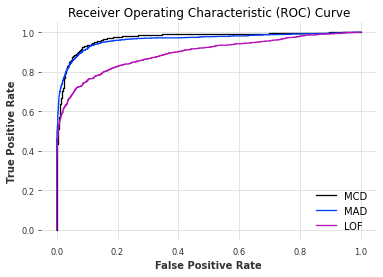

In [ ]:
# Using the optimized hyperparameters, iterate through each timeseries in the training dataset.
# Use each outlier detection method to classify N2OFlux as either hot moment (1) or background emission (0)

# Load alldata
alldata = pd.read_csv('HotMomentTreatments.csv')

# Load only the testing treatment_ids, perform outlier detection on each, and save the results
treatment_ids = pd.read_csv('test_train_split_actual.csv')['Training'].values.tolist()
print(treatment_ids)

# Filter alldata to only include the testing treatment_ids
alldata = alldata[alldata['TreatmentID'].isin(treatment_ids)]

# Drop rows where N2OFlux is None
alldata = alldata.dropna(subset=['N2OFlux'])

for treatment_id in treatment_ids:
    # Print the percentage completion of treatment_ids
    print(("Progress: {0:.2f}%".format((treatment_ids.index(treatment_id) + 1) / len(treatment_ids) * 100)))

    flux = alldata[alldata['TreatmentID'] == treatment_id][['N2OFlux']]
    true = alldata[alldata['TreatmentID'] == treatment_id][['HMTruth']]
    if(len(flux) < 20):
        print(treatment_id)
        print('skip')
        continue
    # Add column to flux dataframe counting upward from 0
    flux['index'] = np.arange(len(flux))

    # MCD
    mcd = MCD(contamination=0.5)
    mcd.fit(flux)
    mcd_pred = mcd.predict(flux)
    mcd_scores = mcd.decision_scores_

    # LOF
    lof = LOF(contamination=0.5, n_neighbors=17, algorithm='kd_tree', metric='manhattan', leaf_size=10)
    lof.fit(flux)
    lof_pred = lof.predict(flux)
    lof_scores = lof.decision_scores_

    # KNN
    knn = KNN(contamination=0.5, n_neighbors=10, method='mean', metric='manhattan')
    knn.fit(flux)
    knn_pred = knn.predict(flux)
    knn_scores = knn.decision_scores_

    # IForest
    iforest = IForest(contamination=0.5, n_estimators=150, max_samples=10, bootstrap=False, max_features=2)
    iforest.fit(flux)
    iforest_pred = iforest.predict(flux)
    iforest_scores = iforest.decision_scores_

    # ABOD
    abod = ABOD(contamination=0.5, method='fast', n_neighbors=75)
    abod.fit(flux)
    abod_pred = abod.predict(flux)
    abod_scores = abod.decision_scores_

    # COPOD
    copod = COPOD(contamination=0.5)
    copod.fit(flux)
    copod_pred = copod.predict(flux)
    copod_scores = copod.decision_scores_

    # HBOS
    hbos = HBOS(contamination=0.5, n_bins=40, alpha=0.9, tol=0.5)
    hbos.fit(flux)
    hbos_pred = hbos.predict(flux)
    hbos_scores = hbos.decision_scores_

    # MAD 1.5
    mad15 = MAD(threshold=1.2)
    mad15.fit(alldata[alldata['TreatmentID'] == treatment_id][['N2OFlux']])
    mad15_pred = mad15.predict(alldata[alldata['TreatmentID'] == treatment_id][['N2OFlux']])
    mad15_scores = mad15.decision_scores_

    # ARIMA
    arima = ARIMAModel(p=1, d=1, q=0)
    arima.fit(flux['N2OFlux'].values)
    arima_scores = arima.get_scores(flux['N2OFlux'].values)

    # Moving Average
    ma = MovingAverageModel(window=1)
    ma.fit(flux['N2OFlux'].values)
    ma_scores = ma.get_scores(flux['N2OFlux'].values, normalize=True)

    # 75th Percentile
    percentile_75 = np.percentile(flux['N2OFlux'], 75)
    percentile_75_pred = np.where(flux['N2OFlux'] > percentile_75, 1, 0)

    # Get the interquartile range
    q75, q25 = np.percentile(flux['N2OFlux'], [75 ,25])
    iqr = q75 - q25
    halfiqr = iqr/2
    median = np.median(flux['N2OFlux'])
    threshold = median + halfiqr

    # 3 IQR
    threshold_3 = median + 3 * iqr
    iqr_3 = np.where(flux['N2OFlux'] > threshold_3, 1, 0)

    # 1.5 IQR
    threshold_3 = median + 1.5 * iqr
    iqr_1p5 = np.where(flux['N2OFlux'] > threshold_3, 1, 0)

    # 4 standard deviations
    threshold_4sd = median + 4 * np.std(flux['N2OFlux'])
    sd4 = np.where(flux['N2OFlux'] > threshold_4sd, 1, 0)

    # Add results lists to dataframe
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'Percentile_75'] = percentile_75_pred
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'IQR3'] = iqr_3
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'IQR1p5'] = iqr_1p5
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'SD4'] = sd4
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'LOF_scores'] = lof_scores
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'KNN_scores'] = knn_scores
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'MCD_scores'] = mcd_scores
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'IForest_scores'] = iforest_scores
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'ABOD_scores'] = abod_scores
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'COPOD_scores'] = copod_scores
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'HBOS_scores'] = hbos_scores
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'MAD15_scores'] = mad15_scores
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'ARIMA_scores'] = arima_scores
    alldata.loc[alldata['TreatmentID'] == treatment_id, 'MovingAverage_scores'] = ma_scores

# Save all data to csv
alldata.to_csv('outlier_detection_training.csv', index=False)

In [ ]:
# Perform a precision - recall curve on the testing dataset
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import plotly.graph_objects as go

alldata = pd.read_csv('outlier_detection_testing.csv')
drop_columns = ['FluxStandardError'	,'HMMCD','HMKNN','VWC','WFPS','SoilT','AirT','Precip','NitrogenApplied','NitrogenType','AirTMax','AirTMin','PrimaryCrop','Management','Gracenet',	'MAP','MAT','Latitude','Longitude','Percentile_75','IQR3','IQR1p5'
]
# drop columns
for column in drop_columns:
    if column in alldata.columns:
        alldata = alldata.drop(column, axis=1)


# If present, drop the columns that are not needed for the analysis
drop_columns = ['IQRHM', 'DOY', 'N2OFlux', 'VWC', 'WFPS', 'SoilT', 'AirT', 'Precip', 'NitrogenApplied',
                'NitrogenForm', 'AirTMax', 'AirTMin', 'Sand', 'Silt', 'Clay', 'pH', 'PrimaryCrop',
                'Management', 'Tillage', 'airT_dm1', 'airT_dm2', 'airT_dm3', 'airT_dm4', 'airT_dm5',
                'airT_dm6', 'airT_dm7', 'vwc_dm1', 'vwc_dm2', 'vwc_dm3', 'vwc_dm4', 'vwc_dm5', 'vwc_dm6',
                'vwc_dm7', 'precip_dm1', 'precip_dm2', 'precip_dm3', 'precip_dm4', 'precip_dm5', 'precip_dm6',
                'precip_dm7', 'days_since_precip', 'last_precip', 'days_since_fert', 'last_fert',
                'RawID', 'ExperimentID', 'PubID', 'TreatmentID', 'Date',
                'NitrogenType', 'BulkDensity', 'SOM', 'TreatmentID',
                'Gracenet', 'MAP', 'MAT', 'Latitude', 'Longitude',]
for column in drop_columns:
    if column in alldata.columns:
        alldata = alldata.drop(column, axis=1)

# Drop unnamed column
alldata = alldata.loc[:, ~alldata.columns.str.contains('^Unnamed')]

# Drop na
alldata = alldata.dropna()

# Drop rows with NaN values for HMTruth
alldata = alldata.dropna(subset=['HMTruth'])
true = alldata['HMTruth'].values.tolist()
# Reset plot and figure
fig = px.area()
plt.clf()
# Set figure size
plt.figure(figsize=(18,15))

# Fill HBOS_scores with 0 if NaN
alldata['HBOS_scores'] = alldata['HBOS_scores'].fillna(0)

#For each outlier detection method, plot a PR curve. Calculate the average precision
precision, recall, thresholds = precision_recall_curve(true, alldata['HBOS_scores'].values.tolist())
hbos_ap = average_precision_score(true, alldata['HBOS_scores'].values.tolist())
hbos_ap = round(hbos_ap, 2)
fig.add_trace(go.Scatter(
    x=precision,
    y=recall,
    customdata=thresholds,
    name='HBOS (AP = %0.2f)' % (hbos_ap),
    hovertemplate='<b>x:%{x}</b><br>y:%{y} <br>Score Threshold: %{customdata} ',
    line=dict(width=5),
))

precision, recall, thresholds = precision_recall_curve(true, alldata['MAD15_scores'].values.tolist())
mad_ap = average_precision_score(true, alldata['MAD15_scores'].values.tolist())
mad_ap = round(mad_ap, 2)
fig.add_trace(go.Scatter(
    x=precision,
    y=recall,
    customdata=thresholds,
    name='MAD (AP = %0.2f)' % (mad_ap),
    hovertemplate='<b>x:%{x}</b><br>y:%{y} <br>Score Threshold: %{customdata} ',
    line=dict(width=5),
))

precision, recall, thresholds = precision_recall_curve(true, alldata['KNN_scores'].values.tolist())
knn_ap = average_precision_score(true, alldata['KNN_scores'].values.tolist())
knn_ap = round(knn_ap, 2)
fig.add_trace(go.Scatter(
    x=precision,
    y=recall,
    customdata=thresholds,
    name='KNN (AP = %0.2f)' % (knn_ap),
    hovertemplate='<b>x:%{x}</b><br>y:%{y} <br>Score Threshold: %{customdata} ',
    line=dict(width=5),
))

precision, recall, thresholds = precision_recall_curve(true, alldata['MCD_scores'].values.tolist())
mcd_ap = average_precision_score(true, alldata['MCD_scores'].values.tolist())
mcd_ap = round(mcd_ap, 2)
fig.add_trace(go.Scatter(
    x=precision,
    y=recall,
    customdata=thresholds,
    name='MCD (AP = %0.2f)' % (mcd_ap),
    hovertemplate='<b>x:%{x}</b><br>y:%{y} <br>Score Threshold: %{customdata} ',
    line=dict(width=5),
))

precision, recall, thresholds = precision_recall_curve(true, alldata['ABOD_scores'].values.tolist())
abod_ap = average_precision_score(true, alldata['ABOD_scores'].values.tolist())
abod_ap = round(abod_ap, 2)
fig.add_trace(go.Scatter(
    x=precision,
    y=recall,
    customdata=thresholds,
    name='ABOD (AP = %0.2f)' % (abod_ap),
    hovertemplate='<b>x:%{x}</b><br>y:%{y} <br>Score Threshold: %{customdata} ',
    line=dict(width=5),
))

precision, recall, thresholds = precision_recall_curve(true, alldata['IForest_scores'].values.tolist())
iforest_ap = average_precision_score(true, alldata['IForest_scores'].values.tolist())
iforest_ap = round(iforest_ap, 2)
fig.add_trace(go.Scatter(
    x=precision,
    y=recall,
    customdata=thresholds,
    name='IForest (AP = %0.2f)' % (iforest_ap),
    hovertemplate='<b>x:%{x}</b><br>y:%{y} <br>Score Threshold: %{customdata} ',
    line=dict(width=5),
))

precision, recall, thresholds = precision_recall_curve(true, alldata['LOF_scores'].values.tolist())
lof_ap = average_precision_score(true, alldata['LOF_scores'].values.tolist())
lof_ap = round(lof_ap, 2)
fig.add_trace(go.Scatter(
    x=precision,
    y=recall,
    customdata=thresholds,
    name='LOF (AP = %0.2f)' % (lof_ap),
    hovertemplate='<b>x:%{x}</b><br>y:%{y} <br>Score Threshold: %{customdata} ',
    line=dict(width=5),
))

precision, recall, thresholds = precision_recall_curve(true, alldata['COPOD_scores'].values.tolist())
copod_ap = average_precision_score(true, alldata['COPOD_scores'].values.tolist())
copod_ap = round(copod_ap, 2)
fig.add_trace(go.Scatter(
    x=precision,
    y=recall,
    customdata=thresholds,
    name='COPOD (AP = %0.2f)' % (copod_ap),
    hovertemplate='<b>x:%{x}</b><br>y:%{y} <br>Score Threshold: %{customdata} ',
    line=dict(width=5),
))

precision, recall, thresholds = precision_recall_curve(true, alldata['ARIMA_scores'].values.tolist())
arima_ap = average_precision_score(true, alldata['ARIMA_scores'].values.tolist())
arima_ap = round(arima_ap, 2)
fig.add_trace(go.Scatter(
    x=precision,
    y=recall,
    customdata=thresholds,
    name='ARIMA (AP = %0.2f)' % (arima_ap),
    hovertemplate='<b>x:%{x}</b><br>y:%{y} <br>Score Threshold: %{customdata} ',
    line=dict(width=5),
))

precision, recall, thresholds = precision_recall_curve(true, alldata['MovingAverage_scores'].values.tolist())
ma_ap = average_precision_score(true, alldata['MovingAverage_scores'].values.tolist())
ma_ap = round(ma_ap, 2)
fig.add_trace(go.Scatter(
    x=precision,
    y=recall,
    customdata=thresholds,
    name='Moving Average (AP = %0.2f)' % (ma_ap),
    hovertemplate='<b>x:%{x}</b><br>y:%{y} <br>Score Threshold: %{customdata} ',
    line=dict(width=5),
))

fig.update_layout(
    xaxis_title="Sensitivity",
    yaxis_title="Precision",
    legend_title="Legend Title",
    width=1800,
    height=1200,
)
# Set taxis itle  font size
fig.update_xaxes(title_font=dict(size=48))
fig.update_yaxes(title_font=dict(size=48))
# Set legend font size
fig.update_layout(legend_font_size=40)
# Set tick font size
fig.update_xaxes(tickfont=dict(size=40))
fig.update_yaxes(tickfont=dict(size=40))

# CHange plot theme to ggplot2
fig.update_layout(template="plotly_white")

# Set left margin
fig.update_layout(margin=dict(r=0, t=0, b=0))
# Set legend position
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.9,
))

# Set legend title
fig.update_layout(legend_title_text='')

# Set the position of the plot, but not the legend
fig.update_layout(
    autosize=False,
    width=1800,
    height=1200,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0,
        pad=00
    ),
)

# Title figure
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()


<Figure size 432x288 with 0 Axes>

<Figure size 1296x1080 with 0 Axes>

In [ ]:
# Create a CSV file for each outlier detection method. Include one column for all potential classification
# decision thresholds.
# Add another column for the F1 score associated with that threshold.

from sklearn.metrics import precision_score, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import matthews_corrcoef

# Load training data
alldata = pd.read_csv('outlier_detection_training.csv')
# If present, drop the columns that are not needed for the analysis
drop_columns = ['IQRHM', 'DOY', 'N2OFlux', 'VWC', 'WFPS', 'SoilT', 'AirT', 'Precip', 'NitrogenApplied',
                'NitrogenForm', 'AirTMax', 'AirTMin', 'Sand', 'Silt', 'Clay', 'pH', 'PrimaryCrop',
                'Management', 'Tillage', 'airT_dm1', 'airT_dm2', 'airT_dm3', 'airT_dm4', 'airT_dm5',
                'airT_dm6', 'airT_dm7', 'vwc_dm1', 'vwc_dm2', 'vwc_dm3', 'vwc_dm4', 'vwc_dm5', 'vwc_dm6',
                'vwc_dm7', 'precip_dm1', 'precip_dm2', 'precip_dm3', 'precip_dm4', 'precip_dm5', 'precip_dm6',
                'precip_dm7', 'days_since_precip', 'last_precip', 'days_since_fert', 'last_fert',
                'RawID', 'ExperimentID', 'PubID', 'TreatmentID', 'Date',
                'NitrogenType', 'BulkDensity', 'SOM', 'TreatmentID',
                'Gracenet', 'MAP', 'MAT', 'Latitude', 'Longitude', 'FluxStandardError', 'HMMCD', 'HMKNN', ]
for column in drop_columns:
    if column in alldata.columns:
        alldata = alldata.drop(column, axis=1)

# Drop unnamed column
alldata = alldata.loc[:, ~alldata.columns.str.contains('^Unnamed')]
print(alldata.columns)

# Drop rows with NaN values
alldata = alldata.dropna()
true = alldata['HMTruth'].values.tolist()

# MAD
print("MAD")
precision, recall, thresholds = precision_recall_curve(true, alldata['MAD15_scores'].values.tolist())
precision = precision[:-1]
recall = recall[:-1]
fscore = (2 * precision * recall) / (precision + recall)
zipped = list(zip(thresholds, fscore))
mad_df = pd.DataFrame(zipped, columns=['Threshold', 'F1'])

# MCD
precision, recall, thresholds = precision_recall_curve(true, alldata['MCD_scores'].values.tolist())
precision = precision[:-1]
recall = recall[:-1]
fscore = (2 * precision * recall) / (precision + recall)
zipped = list(zip(thresholds, fscore))
mcd_df = pd.DataFrame(zipped, columns=['Threshold', 'F1'])

# LOF
print("LOF")
precision, recall, thresholds = precision_recall_curve(true, alldata['LOF_scores'].values.tolist())
precision = precision[:-1]
recall = recall[:-1]
fscore = (2 * precision * recall) / (precision + recall)
zipped = list(zip(thresholds, fscore))
lof_df = pd.DataFrame(zipped, columns=['Threshold', 'F1'])

# ABOD
precision, recall, thresholds = precision_recall_curve(true, alldata['ABOD_scores'].values.tolist())
precision = precision[:-1]
recall = recall[:-1]
fscore = (2 * precision * recall) / (precision + recall)
zipped = list(zip(thresholds, fscore))
abod_df = pd.DataFrame(zipped, columns=['Threshold', 'F1'])

# COPOD
precision, recall, thresholds = precision_recall_curve(true, alldata['COPOD_scores'].values.tolist())
precision = precision[:-1]
recall = recall[:-1]
fscore = (2 * precision * recall) / (precision + recall)
zipped = list(zip(thresholds, fscore))
copod_df = pd.DataFrame(zipped, columns=['Threshold', 'F1'])

# HBOS
precision, recall, thresholds = precision_recall_curve(true, alldata['HBOS_scores'].values.tolist())
precision = precision[:-1]
recall = recall[:-1]
fscore = (2 * precision * recall) / (precision + recall)
zipped = list(zip(thresholds, fscore))
hbos_df = pd.DataFrame(zipped, columns=['Threshold', 'F1'])

# KNN
print("KNN")
precision, recall, thresholds = precision_recall_curve(true, alldata['KNN_scores'].values.tolist())
precision = precision[:-1]
recall = recall[:-1]
fscore = (2 * precision * recall) / (precision + recall)
zipped = list(zip(thresholds, fscore))
knn_df = pd.DataFrame(zipped, columns=['Threshold', 'F1'])

# IForest
precision, recall, thresholds = precision_recall_curve(true, alldata['IForest_scores'].values.tolist())
precision = precision[:-1]
recall = recall[:-1]
fscore = (2 * precision * recall) / (precision + recall)
zipped = list(zip(thresholds, fscore))
print(len(thresholds))
print(len(fscore))
iforest_df = pd.DataFrame(zipped, columns=['Threshold', 'F1'])

# ARIMA
print("ARIMA")
precision, recall, thresholds = precision_recall_curve(true, alldata['ARIMA_scores'].values.tolist())
precision = precision[:-1]
recall = recall[:-1]
fscore = (2 * precision * recall) / (precision + recall)
print(len(thresholds))
print(len(fscore))
zipped = list(zip(thresholds, fscore))
arima_df = pd.DataFrame(zipped, columns=['Threshold', 'F1'])

# Moving Average
print("MA")
# For the MovingAverage_scores column, any value less than 0.00001 is assigned 0
alldata.loc[alldata['MovingAverage_scores'] < 0.00001, 'MovingAverage_scores'] = 0
precision, recall, thresholds = precision_recall_curve(true, alldata['MovingAverage_scores'].values.tolist())
print("1")
precision = precision[:-1]
recall = recall[:-1]
fscore = (2 * precision * recall) / (precision + recall)

ma_df = pd.DataFrame(columns=['Threshold', 'F1'])
ma_df['Threshold'] = thresholds
ma_df['F1'] = fscore

#

hbos_df.to_csv('hbos_df.csv', index=False)
iforest_df.to_csv('iforest_df.csv', index=False)
knn_df.to_csv('knn_df.csv', index=False)
copod_df.to_csv('copod_df.csv', index=False)
abod_df.to_csv('abod_df.csv', index=False)
lof_df.to_csv('lof_df.csv', index=False)
mcd_df.to_csv('mcd_df.csv', index=False)
mad_df.to_csv('mad_df.csv', index=False)
arima_df.to_csv('arima_df.csv', index=False)
ma_df.to_csv('ma_df.csv', index=False)

In [ ]:
# Next, the Matthews Correlation Coefficient must be calculated for each potential threshold for each OD method.
# This will be done by iterating through each threshold, and for each threshold, the MCC will be calculated.

from sklearn.metrics import matthews_corrcoef
# For each row in hbos_df, take the threshold. Then using the training dataset, if HBOS_scores > threshold,
# then 1, else 0.
# Then calculate the Matthews correlation coefficient and save to a dataframe with the threshold
# Load training data
training = pd.read_csv('outlier_detection_training.csv')

# If present, drop the columns that are not needed for the analysis
drop_columns = ['IQRHM', 'DOY', 'N2OFlux', 'VWC', 'WFPS', 'SoilT', 'AirT', 'Precip', 'NitrogenApplied',
                'NitrogenForm', 'AirTMax', 'AirTMin', 'Sand', 'Silt', 'Clay', 'pH', 'PrimaryCrop',
                'Management', 'Tillage', 'airT_dm1', 'airT_dm2', 'airT_dm3', 'airT_dm4', 'airT_dm5',
                'airT_dm6', 'airT_dm7', 'vwc_dm1', 'vwc_dm2', 'vwc_dm3', 'vwc_dm4', 'vwc_dm5', 'vwc_dm6',
                'vwc_dm7', 'precip_dm1', 'precip_dm2', 'precip_dm3', 'precip_dm4', 'precip_dm5', 'precip_dm6',
                'precip_dm7', 'days_since_precip', 'last_precip', 'days_since_fert', 'last_fert',
                'RawID', 'ExperimentID', 'PubID', 'TreatmentID', 'Date',
                'NitrogenType', 'BulkDensity', 'SOM', 'TreatmentID',
                'Gracenet', 'MAP', 'MAT', 'Latitude', 'Longitude', 'FluxStandardError', 'HMMCD', 'HMKNN',]
for column in drop_columns:
    if column in alldata.columns:
        alldata = alldata.drop(column, axis=1)

# Drop unnamed column
alldata = alldata.loc[:, ~alldata.columns.str.contains('^Unnamed')]

# Drop rows with NaN values
alldata = alldata.dropna()
true = training['HMTruth'].values.tolist()

# Iterate through each OD method and each potential decision threshold
# All following code blocks with follow these same steps for each subsequent OD method
thresholds_df = pd.read_csv('hbos_df.csv')
for index, row in thresholds_df.iterrows():
    # Select the decision threshold
    hbos_threshold = row['Threshold']
    # Make all predictions as hot moment or background emission based on the threshold
    hbos_pred = [1 if x > hbos_threshold else 0 for x in training['HBOS_scores'].values.tolist()]
    # Add hbos_pred as a column to the training dataframe
    training['HBOS_pred'] = hbos_pred
    # Because hot moments are exclusively outliers which are higher in magnitude than the median N2OFlux,
    # we can set all N2OFlux values below the median to 0
    # Iterate through the treatment_ids in the training set, find the median N2OFlux, and if N2OFlux < median, set
    # HBOS_pred = 0
    for treatment_id in training['TreatmentID'].unique():
        median = training[training['TreatmentID'] == treatment_id]['N2OFlux'].median()
        training.loc[(training['TreatmentID'] == treatment_id) & (training['N2OFlux'] < median), 'HBOS_pred'] = 0
    # Calculate the MCC at this threshold
    hbos_mcc = matthews_corrcoef(training['HMTruth'].values.tolist(), training['HBOS_pred'].values.tolist())
    thresholds_df.loc[index, 'Matthews'] = hbos_mcc
# Save
thresholds_df.to_csv('hbos_df.csv', index=False)

thresholds_df = pd.read_csv('iforest_df.csv')
for index, row in thresholds_df.iterrows():
    iforest_threshold = row['Threshold']
    iforest_pred = [1 if x > iforest_threshold else 0 for x in training['IForest_scores'].values.tolist()]
    # Add hbos_pred as a column to the training dataframe
    training['IForest_pred'] = iforest_pred
    # Iterate through the treatment_ids in the training set, find the median N2OFlux, and if N2OFlux < median,
    # set pred = 0
    for treatment_id in training['TreatmentID'].unique():
        median = training[training['TreatmentID'] == treatment_id]['N2OFlux'].median()
        training.loc[(training['TreatmentID'] == treatment_id) & (training['N2OFlux'] < median), 'IForest_pred'] = 0
    iforest_mcc = matthews_corrcoef(training['HMTruth'].values.tolist(), training['IForest_pred'].values.tolist())
    thresholds_df.loc[index, 'Matthews'] = iforest_mcc
# Save
thresholds_df.to_csv('iforest_df.csv', index=False)

thresholds_df = pd.read_csv('knn_df.csv')
for index, row in thresholds_df.iterrows():
    knn_threshold = row['Threshold']
    knn_pred = [1 if x > knn_threshold else 0 for x in training['KNN_scores'].values.tolist()]
    # Add hbos_pred as a column to the training dataframe
    training['KNN_pred'] = knn_pred
    # Iterate through the treatment_ids in the training set, find the median N2OFlux, and if N2OFlux < median,
    # set pred = 0
    for treatment_id in training['TreatmentID'].unique():
        median = training[training['TreatmentID'] == treatment_id]['N2OFlux'].median()
        training.loc[(training['TreatmentID'] == treatment_id) & (training['N2OFlux'] < median), 'KNN_pred'] = 0
    knn_mcc = matthews_corrcoef(training['HMTruth'].values.tolist(), training['KNN_pred'].values.tolist())
    thresholds_df.loc[index, 'Matthews'] = knn_mcc
# Save
thresholds_df.to_csv('knn_df.csv', index=False)

thresholds_df = pd.read_csv('copod_df.csv')
for index, row in thresholds_df.iterrows():
    copod_threshold = row['Threshold']
    copod_pred = [1 if x > copod_threshold else 0 for x in training['COPOD_scores'].values.tolist()]
    # Add hbos_pred as a column to the training dataframe
    training['COPOD_pred'] = copod_pred
    # Iterate through the treatment_ids in the training set, find the median N2OFlux, and if N2OFlux < median,
    # set pred = 0
    for treatment_id in training['TreatmentID'].unique():
        median = training[training['TreatmentID'] == treatment_id]['N2OFlux'].median()
        training.loc[(training['TreatmentID'] == treatment_id) & (training['N2OFlux'] < median), 'COPOD_pred'] = 0
    copod_mcc = matthews_corrcoef(training['HMTruth'].values.tolist(), training['COPOD_pred'].values.tolist())
    thresholds_df.loc[index, 'Matthews'] = copod_mcc
# Save
thresholds_df.to_csv('copod_df.csv', index=False)

thresholds_df = pd.read_csv('abod_df.csv')
for index, row in thresholds_df.iterrows():
    abod_threshold = row['Threshold']
    abod_pred = [1 if x > abod_threshold else 0 for x in training['ABOD_scores'].values.tolist()]
    # Add hbos_pred as a column to the training dataframe
    training['ABOD_pred'] = abod_pred
    # Iterate through the treatment_ids in the training set, find the median N2OFlux, and if N2OFlux < median,
    # set pred = 0
    for treatment_id in training['TreatmentID'].unique():
        median = training[training['TreatmentID'] == treatment_id]['N2OFlux'].median()
        training.loc[(training['TreatmentID'] == treatment_id) & (training['N2OFlux'] < median), 'ABOD_pred'] = 0
    abod_mcc = matthews_corrcoef(training['HMTruth'].values.tolist(), training['ABOD_pred'].values.tolist())
    thresholds_df.loc[index, 'Matthews'] = abod_mcc
# Save
thresholds_df.to_csv('abod_df.csv', index=False)

thresholds_df = pd.read_csv('lof_df.csv')
for index, row in thresholds_df.iterrows():
    lof_threshold = row['Threshold']
    lof_pred = [1 if x > lof_threshold else 0 for x in training['LOF_scores'].values.tolist()]
    # Add hbos_pred as a column to the training dataframe
    training['LOF_pred'] = lof_pred
    # Iterate through the treatment_ids in the training set, find the median N2OFlux, and if N2OFlux < median,
    # set pred = 0
    for treatment_id in training['TreatmentID'].unique():
        median = training[training['TreatmentID'] == treatment_id]['N2OFlux'].median()
        training.loc[(training['TreatmentID'] == treatment_id) & (training['N2OFlux'] < median), 'LOF_pred'] = 0
    lof_mcc = matthews_corrcoef(training['HMTruth'].values.tolist(), training['LOF_pred'].values.tolist())
    thresholds_df.loc[index, 'Matthews'] = lof_mcc
# Save
thresholds_df.to_csv('lof_df.csv', index=False)

thresholds_df = pd.read_csv('mcd_df.csv')
for index, row in thresholds_df.iterrows():
    mcd_threshold = row['Threshold']
    mcd_pred = [1 if x > mcd_threshold else 0 for x in training['MCD_scores'].values.tolist()]
    # Add hbos_pred as a column to the training dataframe
    training['MCD_pred'] = mcd_pred
    # Iterate through the treatment_ids in the training set, find the median N2OFlux, and if N2OFlux < median,
    # set pred = 0
    for treatment_id in training['TreatmentID'].unique():
        median = training[training['TreatmentID'] == treatment_id]['N2OFlux'].median()
        training.loc[(training['TreatmentID'] == treatment_id) & (training['N2OFlux'] < median), 'MCD_pred'] = 0
    mcd_mcc = matthews_corrcoef(training['HMTruth'].values.tolist(), training['MCD_pred'].values.tolist())
    thresholds_df.loc[index, 'Matthews'] = mcd_mcc
# Save
thresholds_df.to_csv('mcd_df.csv', index=False)

thresholds_df = pd.read_csv('mad_df.csv')
for index, row in thresholds_df.iterrows():
    mad_threshold = row['Threshold']
    mad_pred = [1 if x > mad_threshold else 0 for x in training['MAD15_scores'].values.tolist()]
    # Add hbos_pred as a column to the training dataframe
    training['MAD_pred'] = mad_pred
    # Iterate through the treatment_ids in the training set, find the median N2OFlux, and if N2OFlux < median,
    # set pred = 0
    for treatment_id in training['TreatmentID'].unique():
        median = training[training['TreatmentID'] == treatment_id]['N2OFlux'].median()
        training.loc[(training['TreatmentID'] == treatment_id) & (training['N2OFlux'] < median), 'MAD_pred'] = 0
    mad_mcc = matthews_corrcoef(training['HMTruth'].values.tolist(), training['MAD_pred'].values.tolist())
    thresholds_df.loc[index, 'Matthews'] = mad_mcc
# Save
thresholds_df.to_csv('mad_df.csv', index=False)

thresholds_df = pd.read_csv('arima_df.csv')
for index, row in thresholds_df.iterrows():
    arima_threshold = row['Threshold']
    arima_pred = [1 if x > arima_threshold else 0 for x in training['ARIMA_scores'].values.tolist()]
    # Add hbos_pred as a column to the training dataframe
    training['ARIMA_pred'] = arima_pred
    # Iterate through the treatment_ids in the training set, find the median N2OFlux, and if N2OFlux < median,
    # set pred = 0
    for treatment_id in training['TreatmentID'].unique():
        median = training[training['TreatmentID'] == treatment_id]['N2OFlux'].median()
        training.loc[(training['TreatmentID'] == treatment_id) & (training['N2OFlux'] < median), 'ARIMA_pred'] = 0
    arima_mcc = matthews_corrcoef(training['HMTruth'].values.tolist(), training['ARIMA_pred'].values.tolist())
    thresholds_df.loc[index, 'Matthews'] = arima_mcc
# Save
thresholds_df.to_csv('arima_df.csv', index=False)

thresholds_df = pd.read_csv('ma_df.csv')
for index, row in thresholds_df.iterrows():
    ma_threshold = row['Threshold']
    ma_pred = [1 if x > ma_threshold else 0 for x in training['MovingAverage_scores'].values.tolist()]
    # Add hbos_pred as a column to the training dataframe
    training['MA_pred'] = ma_pred
    # Iterate through the treatment_ids in the training set, find the median N2OFlux, and if N2OFlux < median,
    # set pred = 0
    for treatment_id in training['TreatmentID'].unique():
        median = training[training['TreatmentID'] == treatment_id]['N2OFlux'].median()
        training.loc[(training['TreatmentID'] == treatment_id) & (training['N2OFlux'] < median), 'MA_pred'] = 0
    ma_mcc = matthews_corrcoef(training['HMTruth'].values.tolist(), training['MA_pred'].values.tolist())
    thresholds_df.loc[index, 'Matthews'] = ma_mcc
# Save
thresholds_df.to_csv('ma_df.csv', index=False)


In [ ]:
# Now that the MCC for each possible decision threshold has been calculated for all OD methods,
# the threshold with the highest MCC can be identified.
# Read each of the csv files created in the previous block to dataframes. Identify the row where Matthews
# is highest, and print the threshold and MCC
hbos_df = pd.read_csv('hbos_df.csv')
hbos_max_mcc = hbos_df['Matthews'].max()
hbos_max_mcc_index = hbos_df['Matthews'].idxmax()
hbos_max_mcc_threshold = hbos_df.loc[hbos_max_mcc_index, 'Threshold']
print('HBOS Max MCC: {} at threshold {}'.format(hbos_max_mcc, hbos_max_mcc_threshold))

iforest_df = pd.read_csv('iforest_df.csv')
iforest_max_mcc = iforest_df['Matthews'].max()
iforest_max_mcc_index = iforest_df['Matthews'].idxmax()
iforest_max_mcc_threshold = iforest_df.loc[iforest_max_mcc_index, 'Threshold']
print('IForest Max MCC: {} at threshold {}'.format(iforest_max_mcc, iforest_max_mcc_threshold))

knn_df = pd.read_csv('knn_df.csv')
knn_max_mcc = knn_df['Matthews'].max()
knn_max_mcc_index = knn_df['Matthews'].idxmax()
knn_max_mcc_threshold = knn_df.loc[knn_max_mcc_index, 'Threshold']
print('KNN Max MCC: {} at threshold {}'.format(knn_max_mcc, knn_max_mcc_threshold))

copod_df = pd.read_csv('copod_df.csv')
copod_max_mcc = copod_df['Matthews'].max()
copod_max_mcc_index = copod_df['Matthews'].idxmax()
copod_max_mcc_threshold = copod_df.loc[copod_max_mcc_index, 'Threshold']
print('COPOD Max MCC: {} at threshold {}'.format(copod_max_mcc, copod_max_mcc_threshold))

abod_df = pd.read_csv('abod_df.csv')
abod_max_mcc = abod_df['Matthews'].max()
abod_max_mcc_index = abod_df['Matthews'].idxmax()
abod_max_mcc_threshold = abod_df.loc[abod_max_mcc_index, 'Threshold']
print('ABOD Max MCC: {} at threshold {}'.format(abod_max_mcc, abod_max_mcc_threshold))

lof_df = pd.read_csv('lof_df.csv')
lof_max_mcc = lof_df['Matthews'].max()
lof_max_mcc_index = lof_df['Matthews'].idxmax()
lof_max_mcc_threshold = lof_df.loc[lof_max_mcc_index, 'Threshold']
print('LOF Max MCC: {} at threshold {}'.format(lof_max_mcc, lof_max_mcc_threshold))

mcd_df = pd.read_csv('mcd_df.csv')
mcd_max_mcc = mcd_df['Matthews'].max()
mcd_max_mcc_index = mcd_df['Matthews'].idxmax()
mcd_max_mcc_threshold = mcd_df.loc[mcd_max_mcc_index, 'Threshold']
print('MCD Max MCC: {} at threshold {}'.format(mcd_max_mcc, mcd_max_mcc_threshold))

mad_df = pd.read_csv('mad_df.csv')
mad_max_mcc = mad_df['Matthews'].max()
mad_max_mcc_index = mad_df['Matthews'].idxmax()
mad_max_mcc_threshold = mad_df.loc[mad_max_mcc_index, 'Threshold']
print('MAD Max MCC: {} at threshold {}'.format(mad_max_mcc, mad_max_mcc_threshold))

arima_df = pd.read_csv('arima_df.csv')
arima_max_mcc = arima_df['Matthews'].max()
arima_max_mcc_index = arima_df['Matthews'].idxmax()
arima_max_mcc_threshold = arima_df.loc[arima_max_mcc_index, 'Threshold']
print('ARIMA Max MCC: {} at threshold {}'.format(arima_max_mcc, arima_max_mcc_threshold))

ma_df = pd.read_csv('ma_df.csv')
ma_max_mcc = ma_df['Matthews'].max()
ma_max_mcc_index = ma_df['Matthews'].idxmax()
ma_max_mcc_threshold = ma_df.loc[ma_max_mcc_index, 'Threshold']
print('Moving Average Max MCC: {} at threshold {}'.format(ma_max_mcc, ma_max_mcc_threshold))


In [ ]:
 # Evaluate the accuracy of each outlier detection method for each timeseries at their optimal thresholds.
# The resulting file will be a CSV where each row refers to one perticular timeseries (identified by TreatmentID)
# and each additional column will be the accuracy of the outlier detection method for that timeseries.
# Block will also output a CSV with the classifications for each N2OFlux value in the testing dataset
# for each outlier detection method at their optimal thresholds.

import datetime
from statsmodels.tsa.stattools import adfuller
# Load testing dataset
alldata = pd.read_csv('outlier_detection_testing.csv')

# Dataset Accuracy
LOF_accuracy_list = []
MCD_accuracy_list = []
IForest_accuracy_list = []
PCA_accuracy_list = []
ABOD_accuracy_list = []
FB_accuracy_list = []
XGBOD_accuracy_list = []
LUNAR_accuracy_list = []
ECOD_accuracy_list = []
COPOD_accuracy_list = []
HBOS_accuracy_list = []
Sampling_accuracy_list = []
Percentile75_accuracy_list = []
IQR3_accuracy_list = []
iqr1_accuracy_list = []
Fivegn_accuracy_list = []
MAD_accuracy_list = []
IQR15_accuracy_list = []
KNN_accuracy_list = []
contamination_list = []
HBOS_final_accuracy_list = []
TreatmentID_list = []
median_frequency_list = []
stationarity_list = []
local_hot_moments_list = []
ARIMA_accuracy_list = []
MA_accuracy_list = []
sd4_accuracy_list = []
experiment_length_list = []
iqr_contamination_list = []
mad_contamination_list = []
mcd_contamination_list = []

# Set thresholds
hbos_threshold = 0.2545095151199819
mad_threshold =  2.0246760325291406
mcd_threshold = 16.9728572559294
lof_threshold = 1.0996907452804685
abod_threshold = -0.00003453
copod_threshold = 3.2736123267915103
knn_threshold = 8.676879
iforest_threshold = 0.0385161491428072
arima_threshold = 4.218050306015504
ma_threshold = 0.746540758240411

optimal_thresholds_predictions_df = pd.DataFrame(columns=['TreatmentID', 'HMTruth', 'HBOS_pred', 'MAD_pred',
                                                          'MCD_pred','LOF_pred', 'ABOD_pred',
                                                          'COPOD_pred', 'KNN_pred', 'IForest_pred', 'ARIMA_pred', 'MA_pred'])

treatment_ids = alldata['TreatmentID'].unique()
for treatment_id in treatment_ids:
    id_data = alldata[alldata['TreatmentID'] == treatment_id]

    true = id_data['HMTruth'].values.tolist()
    id_data['TreatmentID'] = id_data['TreatmentID'].astype(str)
    id_data['HBOS_pred']  = [1 if x > hbos_threshold else 0 for x in id_data['HBOS_scores'].values.tolist()]
    id_data['MAD_pred']  = [1 if x > mad_threshold else 0 for x in id_data['MAD15_scores'].values.tolist()]
    id_data['MCD_pred']  = [1 if x > mcd_threshold else 0 for x in id_data['MCD_scores'].values.tolist()]
    id_data['LOF_pred']  = [1 if x > lof_threshold else 0 for x in id_data['LOF_scores'].values.tolist()]
    id_data['ABOD_pred']  = [1 if x > abod_threshold else 0 for x in id_data['ABOD_scores'].values.tolist()]
    id_data['COPOD_pred']  = [1 if x > copod_threshold else 0 for x in id_data['COPOD_scores'].values.tolist()]
    id_data['KNN_pred']  = [1 if x > knn_threshold else 0 for x in id_data['KNN_scores'].values.tolist()]
    id_data['IForest_pred']  = [1 if x > iforest_threshold else 0 for x in id_data[
        'IForest_scores'].values.tolist()]
    id_data['ARIMA_pred']  = [1 if x > arima_threshold else 0 for x in id_data['ARIMA_scores'].values.tolist()]
    id_data['MA_pred']  = [1 if x > ma_threshold else 0 for x in id_data['MovingAverage_scores'].values.tolist()]

    # 75th Percentile
    percentile_75 = np.percentile(id_data['N2OFlux'], 75)
    id_data['75p'] = np.where(id_data['N2OFlux'] > percentile_75, 1, 0)

    # 5 gn/ha/d
    id_data['5gn'] = np.where(id_data['N2OFlux'] > 5, 1, 0)

    # Get the interquartile range
    q75, q25 = np.percentile(id_data['N2OFlux'], [75 ,25])
    iqr = q75 - q25
    halfiqr = iqr/2
    median = np.median(id_data['N2OFlux'])
    threshold = median + halfiqr

    # 3 IQR
    threshold_3 = median + 3 * iqr
    id_data['3iqr'] = np.where(id_data['N2OFlux'] > threshold_3, 1, 0)

    # 1.5 IQR
    threshold_15 = median + 1.5 * iqr
    id_data['1.5iqr'] = np.where(id_data['N2OFlux'] > threshold_15, 1, 0)

    # 1 IQR
    threshold_1 = median + iqr
    id_data['1iqr'] = np.where(id_data['N2OFlux'] > threshold_1, 1, 0)

    # 4 SD
    mean = np.mean(id_data['N2OFlux'])
    sd = np.std(id_data['N2OFlux'])
    threshold_4 = mean + 4*sd
    id_data['4sd'] = np.where(id_data['N2OFlux'] > threshold_4, 1, 0)

    #'''
    # If N2O Flux is less than median, reclassify all pred as 0
    id_data['HBOS_pred'] = np.where(id_data['N2OFlux'] <= median, 0, id_data['HBOS_pred'])
    id_data['MAD_pred'] = np.where(id_data['N2OFlux'] <= median, 0, id_data['MAD_pred'])
    id_data['MCD_pred'] = np.where(id_data['N2OFlux'] <= median, 0, id_data['MCD_pred'])
    id_data['LOF_pred'] = np.where(id_data['N2OFlux'] <= median, 0, id_data['LOF_pred'])
    id_data['ABOD_pred'] = np.where(id_data['N2OFlux'] <= median, 0, id_data['ABOD_pred'])
    id_data['COPOD_pred'] = np.where(id_data['N2OFlux'] <= median, 0, id_data['COPOD_pred'])
    id_data['KNN_pred'] = np.where(id_data['N2OFlux'] <= median, 0, id_data['KNN_pred'])
    id_data['IForest_pred'] = np.where(id_data['N2OFlux'] <= median, 0, id_data['IForest_pred'])
    id_data['ARIMA_pred'] = np.where(id_data['N2OFlux'] <= median, 0, id_data['ARIMA_pred'])
    id_data['MA_pred'] = np.where(id_data['N2OFlux'] <= median, 0, id_data['MA_pred'])

    #'''
    # Save the accuracy of each OD method for this timeseries to a list
    TreatmentID_list.append(treatment_id)
    HBOS_accuracy_list.append(sum(1 for x,y in zip(id_data['HBOS_pred'].to_list(),true) if x == y) / len(true))
    MAD_accuracy_list.append(sum(1 for x,y in zip(id_data['MAD_pred'].to_list(),true) if x == y) / len(true))
    MCD_accuracy_list.append(sum(1 for x,y in zip(id_data['MCD_pred'].to_list(),true) if x == y) / len(true))
    LOF_accuracy_list.append(sum(1 for x,y in zip(id_data['LOF_pred'].to_list(),true) if x == y) / len(true))
    ABOD_accuracy_list.append(sum(1 for x,y in zip(id_data['ABOD_pred'].to_list(),true) if x == y) / len(true))
    COPOD_accuracy_list.append(sum(1 for x,y in zip(id_data['COPOD_pred'].to_list(),true) if x == y) / len(true))
    KNN_accuracy_list.append(sum(1 for x,y in zip(id_data['KNN_pred'].to_list(),true) if x == y) / len(true))
    IForest_accuracy_list.append(sum(1 for x,y in zip(id_data[
        'IForest_pred'].to_list(),true) if x == y) / len(true))
    ARIMA_accuracy_list.append(sum(1 for x,y in zip(id_data['ARIMA_pred'].to_list(),true) if x == y) / len(true))
    MA_accuracy_list.append(sum(1 for x,y in zip(id_data['MA_pred'].to_list(),true) if x == y) / len(true))
    Percentile75_accuracy_list.append(sum(1 for x,y in zip(id_data['75p'].to_list(),true) if x == y) / len(true))
    Fivegn_accuracy_list.append(sum(1 for x,y in zip(id_data['5gn'].to_list(),true) if x == y) / len(true))
    IQR3_accuracy_list.append(sum(1 for x,y in zip(id_data['3iqr'].to_list(),true) if x == y) / len(true))
    IQR15_accuracy_list.append(sum(1 for x,y in zip(id_data['1.5iqr'].to_list(),true) if x == y) / len(true))
    sd4_accuracy_list.append(sum(1 for x,y in zip(id_data['4sd'].to_list(),true) if x == y) / len(true))
    iqr1_accuracy_list.append(sum(1 for x,y in zip(id_data['1iqr'].to_list(),true) if x == y) / len(true))

    contamination = sum(true) / len(true)
    contamination_list.append(contamination)

    # Get the predicted contamination rate of IQR, MCD, and MAD
    iqr_contamination_list.append(sum(id_data['1.5iqr']) / len(id_data))
    mcd_contamination_list.append(sum(id_data['MCD_pred']) / len(id_data))
    mad_contamination_list.append(sum(id_data['MAD_pred']) / len(id_data))


    # Calculate the number of dats between the first and last N2OFlux measurement
    first_day = id_data.iloc[0]['Date']
    # Convert to datetime
    first_day = datetime.datetime.strptime(first_day, '%Y-%m-%d')
    last_day = id_data.iloc[-1]['Date']
    # Convert to datetime
    last_day = datetime.datetime.strptime(last_day, '%Y-%m-%d')
    days_apart = (last_day - first_day).days
    experiment_length_list.append(days_apart)

    # Calculate the median days between N2OFlux measurements
    days_apart_list = []
    for i in range(1, len(id_data)):
        day = id_data.iloc[i]['Date']
        # Convert to datetime
        day = datetime.datetime.strptime(day, '%Y-%m-%d')
        day_before = id_data.iloc[i-1]['Date']
        # Convert to datetime
        day_before = datetime.datetime.strptime(day_before, '%Y-%m-%d')
        days_apart = (day - day_before).days
        days_apart_list.append(days_apart)

    # Calculate the median days between N2OFlux measurements
    median_days_apart = np.median(days_apart_list)
    median_frequency_list.append(median_days_apart)

    # Add rep data to prediction dataframe
    optimal_thresholds_predictions_df = optimal_thresholds_predictions_df.append(id_data, ignore_index=True)

    # Detect whether the N2OFlux time series is stationary using the Augmented Dickey-Fuller test
    # If the p-value is less than 0.05, the time series is stationary
    # First check if the data covers more than 365 days
    first_day = id_data.iloc[0]['Date']
    last_day = id_data.iloc[-1]['Date']
    day_range = (datetime.datetime.strptime(last_day, '%Y-%m-%d') - datetime.datetime.strptime(first_day, '%Y-%m-%d')).days
    if day_range > 365:
        result = adfuller(id_data['N2OFlux'])
        print(result)
        print(result[1])
        if result[1] < 0.05:
            stationarity_list.append(1)
        else:
            stationarity_list.append(0)
    else:
        stationarity_list.append(1)

    # Calculate the number of local hot moments in the time series
    # Identify the highest N2O flux where HMTruth = 0
    highest_bg = max(id_data[id_data['HMTruth'] == 0]['N2OFlux'])
    # Count the number of rows where N2OFlux < highest_bg and HMTruth = 1
    local_hot_moments = len(id_data[(id_data['N2OFlux'] < highest_bg) & (id_data['HMTruth'] == 1)])
    local_hot_moments_list.append(local_hot_moments)

# Save OD prediction classifications made by each OD method at their optimal thresholds to a CSV
optimal_thresholds_predictions_df.to_csv('optimal_thresholds_predictions_df.csv')

accuracydf = pd.DataFrame(columns=['TreatmentID', '1.5 IQRHM', 'LOF', 'KNN', 'MCD', 'IForest', 'PCA', 'ABOD', 'ECOD',
                                   'COPOD', 'HBOS', 'Sampling', '3IQR', '1IQR', '75th', '>5', 'MAD',
                                   'Contamination', 'MedianFrequency', 'Stationarity', 'LocalHotMoments', 'ExperimentLength'])

accuracydf['TreatmentID'] = TreatmentID_list
accuracydf['1.5 IQRHM'] = IQR15_accuracy_list
accuracydf['LOF'] = LOF_accuracy_list
accuracydf['KNN'] = KNN_accuracy_list
accuracydf['MCD'] = MCD_accuracy_list
accuracydf['IForest'] = IForest_accuracy_list
accuracydf['ABOD'] = ABOD_accuracy_list
accuracydf['COPOD'] = COPOD_accuracy_list
accuracydf['HBOS'] = HBOS_accuracy_list
accuracydf['ARIMA'] = ARIMA_accuracy_list
accuracydf['MA'] = MA_accuracy_list
accuracydf['3IQR'] = IQR3_accuracy_list
accuracydf['1IQR'] = iqr1_accuracy_list
accuracydf['75th'] = Percentile75_accuracy_list
accuracydf['>5'] = Fivegn_accuracy_list
accuracydf['MAD'] = MAD_accuracy_list
accuracydf['4SD'] = sd4_accuracy_list
accuracydf['Contamination'] = contamination_list
accuracydf['MedianFrequency'] = median_frequency_list
accuracydf['Stationarity'] = stationarity_list
accuracydf['LocalHotMoments'] = local_hot_moments_list
accuracydf['ExperimentLength'] = experiment_length_list
accuracydf['IQRContamination'] = iqr_contamination_list
accuracydf['MCDContamination'] = mcd_contamination_list
accuracydf['MADContamination'] = mad_contamination_list

pd.DataFrame(accuracydf).to_csv('OD_accuracydf_testing.csv', index=False)

/tmp/ipykernel_1418063/2817051414.py:42: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.

/tmp/ipykernel_1418063/2817051414.py:43: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.

/tmp/ipykernel_1418063/2817051414.py:44: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.



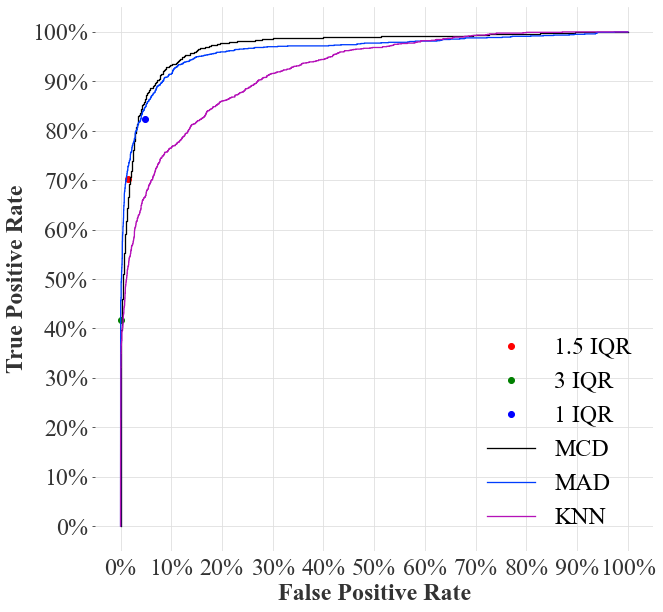

In [43]:
# Create receiver operating characteristic (ROC) curves for MCD and MAD
from sklearn.metrics import roc_curve


# Load alldata
alldata = pd.read_csv('outlier_detection_testing.csv')

# Drop rows where MCD_scores is NaN
alldata = alldata.dropna(subset=['MCD_scores'])

# Create ROC curves for MCD LOF and MAD
fpr_mcd, tpr_mcd, _ = roc_curve(alldata['HMTruth'], alldata['MCD_scores'])
fpr_mad, tpr_mad, _ = roc_curve(alldata['HMTruth'], alldata['MAD15_scores'])
fpr_lof, tpr_lof, _ = roc_curve(alldata['HMTruth'], alldata['KNN_scores'])

# Calculate the TPR and FPR of 1.5IQR as a single point based on the true values
# Read OD_accuracydf_testing.csv
accuracydf = pd.read_csv('optimal_thresholds_predictions_df.csv')
# Get the 1.5 IQR classifications where RawID is also in alldata
accuracydf = accuracydf[accuracydf['RawID'].isin(alldata['RawID'])]
# Get the TPR and FPR of 1.5IQR as a single point based on the true values in accuracydf
# Get length where IQR and HMTruth are both 1
iqr_tpr = accuracydf[(accuracydf['1.5iqr'] == 1) & (accuracydf['HMTruth'] == 1)].shape[0] / accuracydf['HMTruth'].sum()
# Get FPR where IQR = 1 and HMTruth = 0
iqr_fpr = accuracydf[(accuracydf['1.5iqr'] == 1) & (accuracydf['HMTruth'] == 0)].shape[0] / (accuracydf['HMTruth'] == 0).sum()

# Calculate the TPR and FPR of 3IQR as a single point based on the true values
# Get length where IQR and HMTruth are both 1
iqr3_tpr = accuracydf[(accuracydf['3iqr'] == 1) & (accuracydf['HMTruth'] == 1)].shape[0] / accuracydf['HMTruth'].sum()
# Get FPR where IQR = 1 and HMTruth = 0
iqr3_fpr = accuracydf[(accuracydf['3iqr'] == 1) & (accuracydf['HMTruth'] == 0)].shape[0] / (accuracydf['HMTruth'] == 0).sum()

# Calculate the TPR and FPR of 1 IQR as a single point based on the true values
# Get length where IQR and HMTruth are both 1
iqr1_tpr = accuracydf[(accuracydf['1iqr'] == 1) & (accuracydf['HMTruth'] == 1)].shape[0] / accuracydf['HMTruth'].sum()
# Get FPR where IQR = 1 and HMTruth = 0
iqr1_fpr = accuracydf[(accuracydf['1iqr'] == 1) & (accuracydf['HMTruth'] == 0)].shape[0] / (accuracydf['HMTruth'] == 0).sum()

# Set figure size
plt.figure(figsize=(10, 10))
# Plot the point
plt.plot(iqr_fpr, iqr_tpr, 'ro', label='1.5 IQR', color='r')
plt.plot(iqr3_fpr, iqr3_tpr, 'ro', label='3 IQR', color='g')
plt.plot(iqr1_fpr, iqr1_tpr, 'ro', label='1 IQR', color='b')

# Change all font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'


# Plot ROC curves
plt.plot(fpr_mcd, tpr_mcd, label='MCD')
plt.plot(fpr_mad, tpr_mad, label='MAD')
plt.plot(fpr_lof, tpr_lof, label='KNN')
plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)
# Set legent font to Times New Roman
plt.legend(fontsize=24)
# Set tick label font size
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# Set x and y tick labels to percentage format with a % and no decimal places
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
plt.show()


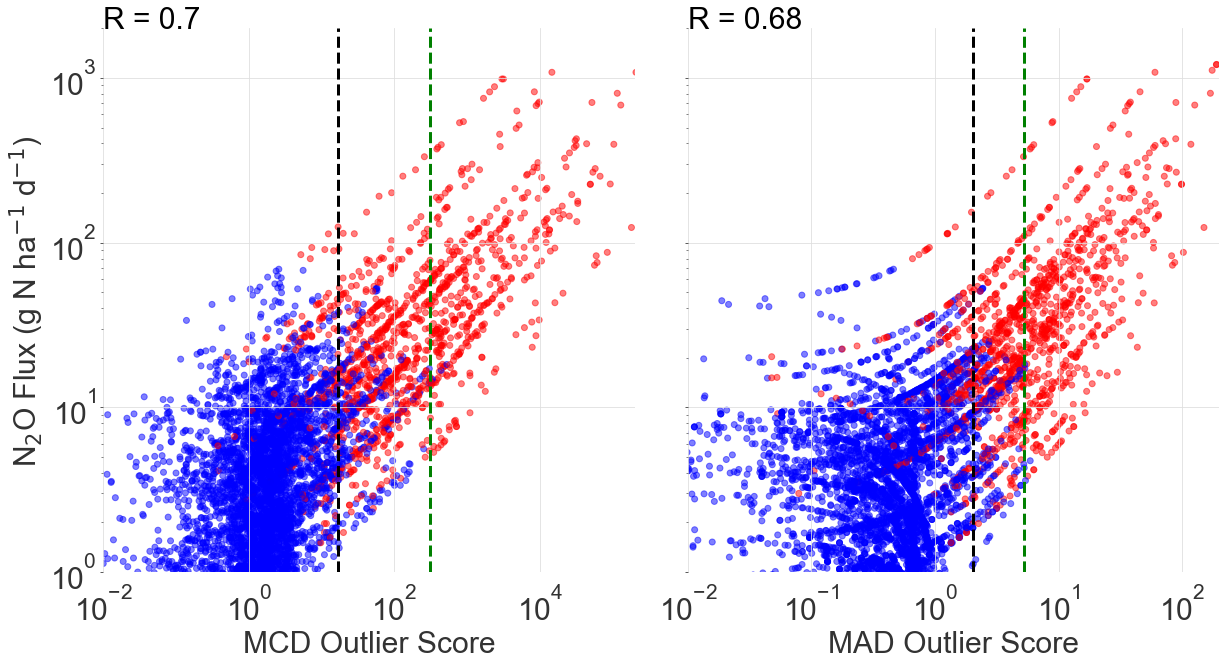

In [9]:
# Figure 9
# Create a scatterplot of MAD_scores and N2OFlux
# Import cmasher
import cmasher as cmr
# Load alldata
alldata = pd.read_csv('outlier_detection_testing.csv')

# Drop rows where MAD_scores is NaN
alldata = alldata.dropna(subset=['MCD_scores'])
# Drop rows where MCD_scores >1
#alldata = alldata[alldata['MCD_scores'] <= 5]

# Create scatterplot
# 2 columns
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)

# Subplot1
ax1 = plt.subplot(1, 2, 1)
# Set font to Times New Roman


ax1.scatter(alldata['MCD_scores'], alldata['N2OFlux'], c=alldata['HMTruth'], cmap='bwr', alpha=0.5)
ax1.set_xlabel('MCD Outlier Score', fontsize=30)
ax1.set_ylabel('N$_2$O Flux (g N ha$^{-1}$ d$^{-1}$)', fontsize=30)

# Plot a vertical red dashed line at x = 16.97
ax1.axvline(x=16.97, color='black', linestyle='--', linewidth=3)
ax1.axvline(x=310, color='green', linestyle='--', linewidth=3)

# Log scale
ax1.set_yscale('log')
ax1.set_xscale('log')
# Set y max and min
ax1.set_ylim(1, 2000)
ax1.set_xlim(0.01, 200000)

# Display the pearsons correlation of log transformed data
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
# Drop negative values
alldata = alldata[alldata['N2OFlux'] > 0]
alldata = alldata[alldata['MCD_scores'] > 15]
r2 = pearsonr(np.log(alldata['MCD_scores']), np.log(alldata['N2OFlux']))[0]
ax1.text(0.01, 2000, 'R = ' + str(round(r2, 2)), fontsize=30)

# Set tick label font size
ax1.tick_params(axis='both', which='major', labelsize=30)

# Subplot2
alldata = pd.read_csv('outlier_detection_testing.csv')
alldata = alldata.dropna(subset=['MAD15_scores'])

ax2 = plt.subplot(1, 2, 2)
cmap = ['blue', 'red']
ax2.scatter(alldata['MAD15_scores'], alldata['N2OFlux'], c=alldata['HMTruth'], cmap='bwr', alpha=0.5)
ax2.set_xlabel('MAD Outlier Score', fontsize=30)
# Plot a vertical red dashed line at x = 2.025
ax2.axvline(x=2.025, color='black', linestyle='--', linewidth=3)
ax2.axvline(x=5.28, color='green', linestyle='--', linewidth=3)

# Log scale
ax2.set_yscale('log')
ax2.set_xscale('log')
# Set y max and min
ax2.set_ylim(1, 2000)
ax2.set_xlim(0.01, 200)

# Display the pearsons correlation
from scipy.stats import pearsonr
# Drop negative values
alldata = alldata[alldata['N2OFlux'] > 0]
alldata = alldata[alldata['MAD15_scores'] > 2]
r2 = pearsonr(np.log(alldata['MAD15_scores']), np.log(alldata['N2OFlux']))[0]

ax2.text(0.01, 2000, 'R = ' + str(round(r2, 2)), fontsize=30)

# Set tick label font size
ax2.tick_params(axis='both', which='major', labelsize=30)
# Remove y tick labels
ax2.set_yticklabels([])
# Shift x axis tick labels down slightly
ax1.tick_params(axis='x', which='major', labelsize=30, pad=10)
ax2.tick_params(axis='x', which='major', labelsize=30, pad=10)

# Unbold the font for axis titles
ax1.set_xlabel('MCD Outlier Score', fontsize=30, fontweight='normal')
ax1.set_ylabel('N$_2$O Flux (g N ha$^{-1}$ d$^{-1}$)', fontsize=30, fontweight='normal')
ax2.set_xlabel('MAD Outlier Score', fontsize=30, fontweight='normal')

# Set spacing between subplots
plt.subplots_adjust(wspace=0.1)
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Times New Roman'
# Save figure as svg
plt.savefig('MCD_MAD_outlier_scores.svg', format='svg')

plt.show()


In [ ]:
# Read data
alldata = pd.read_csv('outlier_detection_testing.csv')

# Drop rows where MCD_scores is NaN
alldata = alldata.dropna(subset=['MCD_scores'])
# Convert HMTruth to int
alldata['HMTruth'] = alldata['HMTruth'].astype(int)

# Create new rows for HM classification based on the conservative thresholds
mcd_conservative = 310
mad_conservative = 6.1

# Create new rows for HM classification based on the optimized thresholds by iterating through the data
alldata['MCD_conservative'] = np.where(alldata['MCD_scores'] > mcd_conservative, 1, 0)
alldata['MAD_conservative'] = np.where(alldata['MAD15_scores'] > mad_conservative, 1, 0)

# Get the TP, FP, median N2O flux of HM and non-HM for conservative thresholds
tp_mcd_conservative = alldata.loc[(alldata['MCD_conservative'] == 1) & (alldata['HMTruth'] == 1)].shape[0] / alldata.loc[alldata['HMTruth'] == 1].shape[0]
fp_mcd_conservative = alldata.loc[(alldata['MCD_conservative'] == 1) & (alldata['HMTruth'] == 0)].shape[0] / alldata.loc[alldata['HMTruth'] == 0].shape[0]
median_n2o_mcd_conservative = alldata.loc[alldata['MCD_conservative'] == 1]['N2OFlux'].median()
median_n2o_nonhm_mcd_conservative = alldata.loc[alldata['MCD_conservative'] == 0]['N2OFlux'].median()
mcd_conservative_flux_contribution = alldata.loc[alldata['MCD_conservative'] == 1]['N2OFlux'].sum() / alldata['N2OFlux'].sum()
mcd_conservative_time_contribution = len(alldata.loc[alldata['MCD_conservative'] == 1]) / len(alldata)


print('MCD conservative TP: ', tp_mcd_conservative)
print('MCD conservative FP: ', fp_mcd_conservative)
print('MCD conservative median N2O flux of HM: ', median_n2o_mcd_conservative)
print('MCD conservative median N2O flux of non-HM: ', median_n2o_nonhm_mcd_conservative)
print('MCD conservative flux contribution: ', mcd_conservative_flux_contribution)
print('MCD conservative time contribution: ', mcd_conservative_time_contribution)

tp_mad_conservative = alldata.loc[(alldata['MAD_conservative'] == 1) & (alldata['HMTruth'] == 1)].shape[0] / alldata.loc[alldata['HMTruth'] == 1].shape[0]
fp_mad_conservative = alldata.loc[(alldata['MAD_conservative'] == 1) & (alldata['HMTruth'] == 0)].shape[0] / alldata.loc[alldata['HMTruth'] == 0].shape[0]
median_n2o_mad_conservative = alldata.loc[alldata['MAD_conservative'] == 1]['N2OFlux'].median()
median_n2o_nonhm_mad_conservative = alldata.loc[alldata['MAD_conservative'] == 0]['N2OFlux'].median()
mad_conservative_flux_contribution = alldata.loc[alldata['MAD_conservative'] == 1]['N2OFlux'].sum() / alldata['N2OFlux'].sum()
mad_conservative_time_contribution = len(alldata.loc[alldata['MAD_conservative'] == 1]) / len(alldata)

print('MAD conservative TP: ', tp_mad_conservative)
print('MAD conservative FP: ', fp_mad_conservative)
print('MAD conservative median N2O flux of HM: ', median_n2o_mad_conservative)
print('MAD conservative median N2O flux of non-HM: ', median_n2o_nonhm_mad_conservative)
print('MAD conservative flux contribution: ', mad_conservative_flux_contribution)
print('MAD conservative time contribution: ', mad_conservative_time_contribution)

tp_3iqr = alldata.loc[(alldata['IQR3'] == 1) & (alldata['HMTruth'] == 1)].shape[0] / alldata.loc[alldata['HMTruth'] == 1].shape[0]
fp_3iqr = alldata.loc[(alldata['IQR3'] == 1) & (alldata['HMTruth'] == 0)].shape[0] / alldata.loc[alldata['HMTruth'] == 0].shape[0]
median_n2o_3iqr = alldata.loc[alldata['IQR3'] == 1]['N2OFlux'].median()
median_n2o_nonhm_3iqr = alldata.loc[alldata['IQR3'] == 0]['N2OFlux'].median()
iqr3_flux_contribution = alldata.loc[alldata['IQR3'] == 1]['N2OFlux'].sum() / alldata['N2OFlux'].sum()
iqr3_time_contribution = len(alldata.loc[alldata['IQR3'] == 1]) / len(alldata)

print('3IQR TP: ', tp_3iqr)
print('3IQR FP: ', fp_3iqr)
print('3IQR median N2O flux of HM: ', median_n2o_3iqr)
print('3IQR median N2O flux of non-HM: ', median_n2o_nonhm_3iqr)
print('3IQR flux contribution: ', iqr3_flux_contribution)
print('3IQR time contribution: ', iqr3_time_contribution)

MCD conservative TP:  0.35004042037186744
MCD conservative FP:  0.0007600228006840206
MCD conservative median N2O flux of HM:  60.2909
MCD conservative median N2O flux of non-HM:  2.984
MCD conservative flux contribution:  0.5673689753936928
MCD conservative time contribution:  0.06723076923076923
MAD conservative TP:  0.4211802748585287
MAD conservative FP:  0.0
MAD conservative median N2O flux of HM:  52.297
MAD conservative median N2O flux of non-HM:  2.89479
MAD conservative flux contribution:  0.5863425090157788
MAD conservative time contribution:  0.08015384615384616
3IQR TP:  0.41632983023443815
3IQR FP:  0.0007600228006840206
3IQR median N2O flux of HM:  49.61
3IQR median N2O flux of non-HM:  2.90145
3IQR flux contribution:  0.5901127196890239
3IQR time contribution:  0.07984615384615384


In [ ]:
 # Evaluate the accuracy of each outlier detection method for each timeseries at their optimal thresholds using the Training dataset
# The resulting file will be a CSV where each row refers to one perticular timeseries (identified by TreatmentID)
# and each additional column will be the accuracy of the outlier detection method for that timeseries.
# Block will also output a CSV with the classifications for each N2OFlux value in the testing dataset
# for each outlier detection method at their optimal thresholds.

import datetime
from statsmodels.tsa.stattools import adfuller
# Load testing dataset
alldata = pd.read_csv('outlier_detection_training.csv')

# Dataset Accuracy
LOF_accuracy_list = []
MCD_accuracy_list = []
IForest_accuracy_list = []
PCA_accuracy_list = []
ABOD_accuracy_list = []
FB_accuracy_list = []
XGBOD_accuracy_list = []
LUNAR_accuracy_list = []
ECOD_accuracy_list = []
COPOD_accuracy_list = []
HBOS_accuracy_list = []
Sampling_accuracy_list = []
Percentile75_accuracy_list = []
IQR3_accuracy_list = []
Fivegn_accuracy_list = []
MAD_accuracy_list = []
IQR15_accuracy_list = []
KNN_accuracy_list = []
contamination_list = []
HBOS_final_accuracy_list = []
TreatmentID_list = []
median_frequency_list = []
stationarity_list = []
local_hot_moments_list = []
ARIMA_accuracy_list = []
MA_accuracy_list = []
sd4_accuracy_list = []
experiment_length_list = []

# Set thresholds
hbos_threshold = 0.2545095151199819
mad_threshold =  2.0246760325291406
mcd_threshold = 16.9728572559294
lof_threshold = 1.0996907452804685
abod_threshold = -0.00003453
copod_threshold = 3.2736123267915103
knn_threshold = 8.676879
iforest_threshold = 0.0385161491428072
arima_threshold = 4.218050306015504
ma_threshold = 0.746540758240411

optimal_thresholds_predictions_df = pd.DataFrame(columns=['TreatmentID', 'HMTruth', 'HBOS_pred', 'MAD_pred',
                                                          'MCD_pred','LOF_pred', 'ABOD_pred',
                                                          'COPOD_pred', 'KNN_pred', 'IForest_pred', 'ARIMA_pred', 'MA_pred'])

treatment_ids = alldata['TreatmentID'].unique()
for treatment_id in treatment_ids:
    id_data = alldata[alldata['TreatmentID'] == treatment_id]

    true = id_data['HMTruth'].values.tolist()
    id_data['TreatmentID'] = id_data['TreatmentID'].astype(str)
    id_data['HBOS_pred']  = [1 if x > hbos_threshold else 0 for x in id_data['HBOS_scores'].values.tolist()]
    id_data['MAD_pred']  = [1 if x > mad_threshold else 0 for x in id_data['MAD15_scores'].values.tolist()]
    id_data['MCD_pred']  = [1 if x > mcd_threshold else 0 for x in id_data['MCD_scores'].values.tolist()]
    id_data['LOF_pred']  = [1 if x > lof_threshold else 0 for x in id_data['LOF_scores'].values.tolist()]
    id_data['ABOD_pred']  = [1 if x > abod_threshold else 0 for x in id_data['ABOD_scores'].values.tolist()]
    id_data['COPOD_pred']  = [1 if x > copod_threshold else 0 for x in id_data['COPOD_scores'].values.tolist()]
    id_data['KNN_pred']  = [1 if x > knn_threshold else 0 for x in id_data['KNN_scores'].values.tolist()]
    id_data['IForest_pred']  = [1 if x > iforest_threshold else 0 for x in id_data[
        'IForest_scores'].values.tolist()]
    id_data['ARIMA_pred']  = [1 if x > arima_threshold else 0 for x in id_data['ARIMA_scores'].values.tolist()]
    id_data['MA_pred']  = [1 if x > ma_threshold else 0 for x in id_data['MovingAverage_scores'].values.tolist()]

    # 75th Percentile
    percentile_75 = np.percentile(id_data['N2OFlux'], 75)
    id_data['75p'] = np.where(id_data['N2OFlux'] > percentile_75, 1, 0)

    # 5 gn/ha/d
    id_data['5gn'] = np.where(id_data['N2OFlux'] > 5, 1, 0)

    # Get the interquartile range
    q75, q25 = np.percentile(id_data['N2OFlux'], [75 ,25])
    iqr = q75 - q25
    halfiqr = iqr/2
    median = np.median(id_data['N2OFlux'])
    threshold = median + halfiqr

    # 3 IQR
    threshold_3 = median + 3 * iqr
    id_data['3iqr'] = np.where(id_data['N2OFlux'] > threshold_3, 1, 0)

    # 1.5 IQR
    threshold_15 = median + 1.5 * iqr
    id_data['1.5iqr'] = np.where(id_data['N2OFlux'] > threshold_15, 1, 0)

    # 4 SD
    mean = np.mean(id_data['N2OFlux'])
    sd = np.std(id_data['N2OFlux'])
    threshold_4 = mean + 4*sd
    id_data['4sd'] = np.where(id_data['N2OFlux'] > threshold_4, 1, 0)

    #'''
    # If N2O Flux is less than median, reclassify all pred as 0
    id_data['HBOS_pred'] = np.where(id_data['N2OFlux'] <= median, 0, id_data['HBOS_pred'])
    id_data['MAD_pred'] = np.where(id_data['N2OFlux'] <= median, 0, id_data['MAD_pred'])
    id_data['MCD_pred'] = np.where(id_data['N2OFlux'] <= median, 0, id_data['MCD_pred'])
    id_data['LOF_pred'] = np.where(id_data['N2OFlux'] <= median, 0, id_data['LOF_pred'])
    id_data['ABOD_pred'] = np.where(id_data['N2OFlux'] <= median, 0, id_data['ABOD_pred'])
    id_data['COPOD_pred'] = np.where(id_data['N2OFlux'] <= median, 0, id_data['COPOD_pred'])
    id_data['KNN_pred'] = np.where(id_data['N2OFlux'] <= median, 0, id_data['KNN_pred'])
    id_data['IForest_pred'] = np.where(id_data['N2OFlux'] <= median, 0, id_data['IForest_pred'])
    id_data['ARIMA_pred'] = np.where(id_data['N2OFlux'] <= median, 0, id_data['ARIMA_pred'])
    id_data['MA_pred'] = np.where(id_data['N2OFlux'] <= median, 0, id_data['MA_pred'])

    #'''
    # Save the accuracy of each OD method for this timeseries to a list
    TreatmentID_list.append(treatment_id)
    HBOS_accuracy_list.append(sum(1 for x,y in zip(id_data['HBOS_pred'].to_list(),true) if x == y) / len(true))
    MAD_accuracy_list.append(sum(1 for x,y in zip(id_data['MAD_pred'].to_list(),true) if x == y) / len(true))
    MCD_accuracy_list.append(sum(1 for x,y in zip(id_data['MCD_pred'].to_list(),true) if x == y) / len(true))
    LOF_accuracy_list.append(sum(1 for x,y in zip(id_data['LOF_pred'].to_list(),true) if x == y) / len(true))
    ABOD_accuracy_list.append(sum(1 for x,y in zip(id_data['ABOD_pred'].to_list(),true) if x == y) / len(true))
    COPOD_accuracy_list.append(sum(1 for x,y in zip(id_data['COPOD_pred'].to_list(),true) if x == y) / len(true))
    KNN_accuracy_list.append(sum(1 for x,y in zip(id_data['KNN_pred'].to_list(),true) if x == y) / len(true))
    IForest_accuracy_list.append(sum(1 for x,y in zip(id_data[
        'IForest_pred'].to_list(),true) if x == y) / len(true))
    ARIMA_accuracy_list.append(sum(1 for x,y in zip(id_data['ARIMA_pred'].to_list(),true) if x == y) / len(true))
    MA_accuracy_list.append(sum(1 for x,y in zip(id_data['MA_pred'].to_list(),true) if x == y) / len(true))
    Percentile75_accuracy_list.append(sum(1 for x,y in zip(id_data['75p'].to_list(),true) if x == y) / len(true))
    Fivegn_accuracy_list.append(sum(1 for x,y in zip(id_data['5gn'].to_list(),true) if x == y) / len(true))
    IQR3_accuracy_list.append(sum(1 for x,y in zip(id_data['3iqr'].to_list(),true) if x == y) / len(true))
    IQR15_accuracy_list.append(sum(1 for x,y in zip(id_data['1.5iqr'].to_list(),true) if x == y) / len(true))
    sd4_accuracy_list.append(sum(1 for x,y in zip(id_data['4sd'].to_list(),true) if x == y) / len(true))

    contamination = sum(true) / len(true)
    contamination_list.append(contamination)

    # Calculate the number of dats between the first and last N2OFlux measurement
    first_day = id_data.iloc[0]['Date']
    # Convert to datetime
    first_day = datetime.datetime.strptime(first_day, '%Y-%m-%d')
    last_day = id_data.iloc[-1]['Date']
    # Convert to datetime
    last_day = datetime.datetime.strptime(last_day, '%Y-%m-%d')
    days_apart = (last_day - first_day).days
    experiment_length_list.append(days_apart)

    # Calculate the median days between N2OFlux measurements
    days_apart_list = []
    for i in range(1, len(id_data)):
        day = id_data.iloc[i]['Date']
        # Convert to datetime
        day = datetime.datetime.strptime(day, '%Y-%m-%d')
        day_before = id_data.iloc[i-1]['Date']
        # Convert to datetime
        day_before = datetime.datetime.strptime(day_before, '%Y-%m-%d')
        days_apart = (day - day_before).days
        days_apart_list.append(days_apart)

    # Calculate the median days between N2OFlux measurements
    median_days_apart = np.median(days_apart_list)
    median_frequency_list.append(median_days_apart)

    # Add rep data to prediction dataframe
    optimal_thresholds_predictions_df = optimal_thresholds_predictions_df.append(id_data, ignore_index=True)

    # Detect whether the N2OFlux time series is stationary using the Augmented Dickey-Fuller test
    # If the p-value is less than 0.05, the time series is stationary
    # First check if the data covers more than 365 days
    first_day = id_data.iloc[0]['Date']
    last_day = id_data.iloc[-1]['Date']
    day_range = (datetime.datetime.strptime(last_day, '%Y-%m-%d') - datetime.datetime.strptime(first_day, '%Y-%m-%d')).days
    if day_range > 365:
        result = adfuller(id_data['N2OFlux'])
        print(result)
        print(result[1])
        if result[1] < 0.05:
            stationarity_list.append(1)
        else:
            stationarity_list.append(0)
    else:
        stationarity_list.append(1)

    # Calculate the number of local hot moments in the time series
    # Identify the highest N2O flux where HMTruth = 0
    highest_bg = max(id_data[id_data['HMTruth'] == 0]['N2OFlux'])
    # Count the number of rows where N2OFlux < highest_bg and HMTruth = 1
    local_hot_moments = len(id_data[(id_data['N2OFlux'] < highest_bg) & (id_data['HMTruth'] == 1)])
    local_hot_moments_list.append(local_hot_moments)

# Save OD prediction classifications made by each OD method at their optimal thresholds to a CSV
optimal_thresholds_predictions_df.to_csv('optimal_thresholds_predictions_training.csv')

accuracydf = pd.DataFrame(columns=['TreatmentID', '1.5 IQRHM', 'LOF', 'KNN', 'MCD', 'IForest', 'PCA', 'ABOD', 'ECOD',
                                   'COPOD', 'HBOS', 'Sampling', '3IQR', '75th', '>5', 'MAD',
                                   'Contamination', 'MedianFrequency', 'Stationarity', 'LocalHotMoments' ,'ExperimentLength'])

accuracydf['TreatmentID'] = TreatmentID_list
accuracydf['1.5 IQRHM'] = IQR15_accuracy_list
accuracydf['LOF'] = LOF_accuracy_list
accuracydf['KNN'] = KNN_accuracy_list
accuracydf['MCD'] = MCD_accuracy_list
accuracydf['IForest'] = IForest_accuracy_list
accuracydf['ABOD'] = ABOD_accuracy_list
accuracydf['COPOD'] = COPOD_accuracy_list
accuracydf['HBOS'] = HBOS_accuracy_list
accuracydf['ARIMA'] = ARIMA_accuracy_list
accuracydf['MA'] = MA_accuracy_list
accuracydf['3IQR'] = IQR3_accuracy_list
accuracydf['75th'] = Percentile75_accuracy_list
accuracydf['>5'] = Fivegn_accuracy_list
accuracydf['MAD'] = MAD_accuracy_list
accuracydf['4SD'] = sd4_accuracy_list
accuracydf['Contamination'] = contamination_list
accuracydf['MedianFrequency'] = median_frequency_list
accuracydf['Stationarity'] = stationarity_list
accuracydf['LocalHotMoments'] = local_hot_moments_list
accuracydf['ExperimentLength'] = experiment_length_list

accuracydf.to_csv('OD_accuracydf_training.csv')

In [ ]:
# Evaluate outlier detection methods using a variety of performance metrics at their optimal thresholds.
# The resulting file will be a CSV where each row is an OD method, and the columns are F1, Recall, Precision,
# Accuracy, and MCC
# evaluated using the method's optimized decision threshold

from sklearn.metrics import precision_score, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
# Import Matthews correlation coefficient
from sklearn.metrics import matthews_corrcoef

# Load testing dataset
alldata = pd.read_csv('outlier_detection_testing.csv')
optimal_thresholds_predictions_df = pd.read_csv('optimal_thresholds_predictions_df.csv')
optimal_threshold_results_df = pd.DataFrame(columns=['Model', 'F1', 'Recall', 'Precision', 'Accuracy',
                                                     'Matthews', 'TPR', 'FPR', 'TNR', 'FNR'])
# Keep only prediction and true columsn
optimal_thresholds_predictions_df = optimal_thresholds_predictions_df[['TreatmentID', 'HMTruth', 'HBOS_pred', 'MAD_pred',
                                                                          'MCD_pred', 'LOF_pred', 'ABOD_pred',
                                                                            'COPOD_pred', 'KNN_pred', 'IForest_pred', 'ARIMA_pred',
                                                                            'MA_pred','Percentile_75', 'IQR3', 'IQR1p5', '4sd']]
# Drop rows with missing values
optimal_thresholds_predictions_df = optimal_thresholds_predictions_df.dropna()
true = optimal_thresholds_predictions_df['HMTruth'].to_list()


# Retrieve OD method predictions
hbos_pred = optimal_thresholds_predictions_df['HBOS_pred'].to_list()
# Compare predictions with True classifications. Calculate F1, Recall, Precision, Accuracy, MCC, TPR, FPR,
# TNR, FNR
hbos_f1 = f1_score(true, hbos_pred)
hbos_precision = precision_score(true, hbos_pred)
hbos_recall = recall_score(true, hbos_pred)
hbos_accuracy = accuracy_score(true, hbos_pred)
hbos_confusion_matrix = confusion_matrix(true, hbos_pred)
hbos_mcc = matthews_corrcoef(true, hbos_pred)
hbos_tpr = hbos_confusion_matrix[1][1] / (hbos_confusion_matrix[1][1] + hbos_confusion_matrix[1][0])
hbos_fpr = hbos_confusion_matrix[0][1] / (hbos_confusion_matrix[0][1] + hbos_confusion_matrix[0][0])
hbos_tnr = hbos_confusion_matrix[0][0] / (hbos_confusion_matrix[0][0] + hbos_confusion_matrix[0][1])
hbos_fnr = hbos_confusion_matrix[1][0] / (hbos_confusion_matrix[1][0] + hbos_confusion_matrix[1][1])
optimal_threshold_results_df = optimal_threshold_results_df.append({'Model': 'HBOS', 'F1': hbos_f1,
                                                                    'Recall': hbos_recall,
                                                                    'Precision': hbos_precision,
                                                                    'Accuracy': hbos_accuracy,
                                                                    'Matthews': hbos_mcc, 'TPR': hbos_tpr,
                                                                    'FPR': hbos_fpr, 'TNR': hbos_tnr,
                                                                    'FNR': hbos_fnr}, ignore_index=True)

mad_pred = optimal_thresholds_predictions_df['MAD_pred'].to_list()
mad_f1 = f1_score(true, mad_pred)
mad_precision = precision_score(true, mad_pred)
mad_recall = recall_score(true, mad_pred)
mad_accuracy = accuracy_score(true, mad_pred)
mad_confusion_matrix = confusion_matrix(true, mad_pred)
mad_mcc = matthews_corrcoef(true, mad_pred)
mad_tpr = mad_confusion_matrix[1][1] / (mad_confusion_matrix[1][1] + mad_confusion_matrix[1][0])
mad_fpr = mad_confusion_matrix[0][1] / (mad_confusion_matrix[0][1] + mad_confusion_matrix[0][0])
mad_tnr = mad_confusion_matrix[0][0] / (mad_confusion_matrix[0][0] + mad_confusion_matrix[0][1])
mad_fnr = mad_confusion_matrix[1][0] / (mad_confusion_matrix[1][0] + mad_confusion_matrix[1][1])
optimal_threshold_results_df = optimal_threshold_results_df.append({'Model': 'MAD', 'F1': mad_f1,
                                                                    'Recall': mad_recall,
                                                                    'Precision': mad_precision,
                                                                    'Accuracy': mad_accuracy,
                                                                    'Matthews': mad_mcc, 'TPR': mad_tpr,
                                                                    'FPR': mad_fpr, 'TNR': mad_tnr,
                                                                    'FNR': mad_fnr}, ignore_index=True)

mcd_pred = optimal_thresholds_predictions_df['MCD_pred'].to_list()
mcd_f1 = f1_score(true, mcd_pred)
mcd_precision = precision_score(true, mcd_pred)
mcd_recall = recall_score(true, mcd_pred)
mcd_accuracy = accuracy_score(true, mcd_pred)
mcd_confusion_matrix = confusion_matrix(true, mcd_pred)
mcd_mcc = matthews_corrcoef(true, mcd_pred)
mcd_tpr = mcd_confusion_matrix[1][1] / (mcd_confusion_matrix[1][1] + mcd_confusion_matrix[1][0])
mcd_fpr = mcd_confusion_matrix[0][1] / (mcd_confusion_matrix[0][1] + mcd_confusion_matrix[0][0])
mcd_tnr = mcd_confusion_matrix[0][0] / (mcd_confusion_matrix[0][0] + mcd_confusion_matrix[0][1])
mcd_fnr = mcd_confusion_matrix[1][0] / (mcd_confusion_matrix[1][0] + mcd_confusion_matrix[1][1])
optimal_threshold_results_df = optimal_threshold_results_df.append({'Model': 'MCD', 'F1': mcd_f1,
                                                                    'Recall': mcd_recall,
                                                                    'Precision': mcd_precision,
                                                                    'Accuracy': mcd_accuracy,
                                                                    'Matthews': mcd_mcc, 'TPR': mcd_tpr,
                                                                    'FPR': mcd_fpr, 'TNR': mcd_tnr,
                                                                    'FNR': mcd_fnr}, ignore_index=True)


lof_pred = optimal_thresholds_predictions_df['LOF_pred'].to_list()
lof_f1 = f1_score(true, lof_pred)
lof_precision = precision_score(true, lof_pred)
lof_recall = recall_score(true, lof_pred)
lof_accuracy = accuracy_score(true, lof_pred)
lof_confusion_matrix = confusion_matrix(true, lof_pred)
lof_mcc = matthews_corrcoef(true, lof_pred)
lof_tpr = lof_confusion_matrix[1][1] / (lof_confusion_matrix[1][1] + lof_confusion_matrix[1][0])
lof_fpr = lof_confusion_matrix[0][1] / (lof_confusion_matrix[0][1] + lof_confusion_matrix[0][0])
lof_tnr = lof_confusion_matrix[0][0] / (lof_confusion_matrix[0][0] + lof_confusion_matrix[0][1])
lof_fnr = lof_confusion_matrix[1][0] / (lof_confusion_matrix[1][0] + lof_confusion_matrix[1][1])
optimal_threshold_results_df = optimal_threshold_results_df.append({'Model': 'LOF', 'F1': lof_f1,
                                                                    'Recall': lof_recall,
                                                                    'Precision': lof_precision,
                                                                    'Accuracy': lof_accuracy,
                                                                    'Matthews': lof_mcc, 'TPR': lof_tpr,
                                                                    'FPR': lof_fpr, 'TNR': lof_tnr,
                                                                    'FNR': lof_fnr}, ignore_index=True)

knn_pred = optimal_thresholds_predictions_df['KNN_pred'].to_list()
knn_f1 = f1_score(true, knn_pred)
knn_precision = precision_score(true, knn_pred)
knn_recall = recall_score(true, knn_pred)
knn_accuracy = accuracy_score(true, knn_pred)
knn_confusion_matrix = confusion_matrix(true, knn_pred)
knn_mcc = matthews_corrcoef(true, knn_pred)
knn_tpr = knn_confusion_matrix[1][1] / (knn_confusion_matrix[1][1] + knn_confusion_matrix[1][0])
knn_fpr = knn_confusion_matrix[0][1] / (knn_confusion_matrix[0][1] + knn_confusion_matrix[0][0])
knn_tnr = knn_confusion_matrix[0][0] / (knn_confusion_matrix[0][0] + knn_confusion_matrix[0][1])
knn_fnr = knn_confusion_matrix[1][0] / (knn_confusion_matrix[1][0] + knn_confusion_matrix[1][1])
optimal_threshold_results_df = optimal_threshold_results_df.append({'Model': 'KNN', 'F1': knn_f1,
                                                                    'Recall': knn_recall,
                                                                    'Precision': knn_precision,
                                                                    'Accuracy': knn_accuracy,
                                                                    'Matthews': knn_mcc, 'TPR': knn_tpr,
                                                                    'FPR': knn_fpr, 'TNR': knn_tnr,
                                                                    'FNR': knn_fnr}, ignore_index=True)

iforest_pred = optimal_thresholds_predictions_df['IForest_pred'].to_list()
iforest_f1 = f1_score(true, iforest_pred)
iforest_precision = precision_score(true, iforest_pred)
iforest_recall = recall_score(true, iforest_pred)
iforest_accuracy = accuracy_score(true, iforest_pred)
iforest_confusion_matrix = confusion_matrix(true, iforest_pred)
iforest_mcc = matthews_corrcoef(true, iforest_pred)
iforest_tpr = iforest_confusion_matrix[1][1] / (iforest_confusion_matrix[1][1] + iforest_confusion_matrix[1][0])
iforest_fpr = iforest_confusion_matrix[0][1] / (iforest_confusion_matrix[0][1] + iforest_confusion_matrix[0][0])
iforest_tnr = iforest_confusion_matrix[0][0] / (iforest_confusion_matrix[0][0] + iforest_confusion_matrix[0][1])
iforest_fnr = iforest_confusion_matrix[1][0] / (iforest_confusion_matrix[1][0] + iforest_confusion_matrix[1][1])
optimal_threshold_results_df = optimal_threshold_results_df.append({'Model': 'IForest', 'F1': iforest_f1,
                                                                    'Recall': iforest_recall,
                                                                    'Precision': iforest_precision,
                                                                    'Accuracy': iforest_accuracy,
                                                                    'Matthews': iforest_mcc,
                                                                    'TPR': iforest_tpr, 'FPR': iforest_fpr,
                                                                    'TNR': iforest_tnr,
                                                                    'FNR': iforest_fnr}, ignore_index=True)

abod_pred = optimal_thresholds_predictions_df['ABOD_pred'].to_list()
abod_f1 = f1_score(true, abod_pred)
abod_precision = precision_score(true, abod_pred)
abod_recall = recall_score(true, abod_pred)
abod_accuracy = accuracy_score(true, abod_pred)
abod_confusion_matrix = confusion_matrix(true, abod_pred)
abod_mcc = matthews_corrcoef(true, abod_pred)
abod_tpr = abod_confusion_matrix[1][1] / (abod_confusion_matrix[1][1] + abod_confusion_matrix[1][0])
abod_fpr = abod_confusion_matrix[0][1] / (abod_confusion_matrix[0][1] + abod_confusion_matrix[0][0])
abod_tnr = abod_confusion_matrix[0][0] / (abod_confusion_matrix[0][0] + abod_confusion_matrix[0][1])
abod_fnr = abod_confusion_matrix[1][0] / (abod_confusion_matrix[1][0] + abod_confusion_matrix[1][1])
optimal_threshold_results_df = optimal_threshold_results_df.append({'Model': 'ABOD', 'F1': abod_f1,
                                                                    'Recall': abod_recall,
                                                                    'Precision': abod_precision,
                                                                    'Accuracy': abod_accuracy,
                                                                    'Matthews': abod_mcc, 'TPR': abod_tpr,
                                                                    'FPR': abod_fpr, 'TNR': abod_tnr,
                                                                    'FNR': abod_fnr}, ignore_index=True)



copod_pred = optimal_thresholds_predictions_df['COPOD_pred'].to_list()
copod_f1 = f1_score(true, copod_pred)
copod_precision = precision_score(true, copod_pred)
copod_recall = recall_score(true, copod_pred)
copod_accuracy = accuracy_score(true, copod_pred)
copod_confusion_matrix = confusion_matrix(true, copod_pred)
copod_mcc = matthews_corrcoef(true, copod_pred)
copod_tpr = copod_confusion_matrix[1][1] / (copod_confusion_matrix[1][1] + copod_confusion_matrix[1][0])
copod_fpr = copod_confusion_matrix[0][1] / (copod_confusion_matrix[0][1] + copod_confusion_matrix[0][0])
copod_tnr = copod_confusion_matrix[0][0] / (copod_confusion_matrix[0][0] + copod_confusion_matrix[0][1])
copod_fnr = copod_confusion_matrix[1][0] / (copod_confusion_matrix[1][0] + copod_confusion_matrix[1][1])
optimal_threshold_results_df = optimal_threshold_results_df.append({'Model': 'COPOD', 'F1': copod_f1,
                                                                    'Recall': copod_recall,
                                                                    'Precision': copod_precision,
                                                                    'Accuracy': copod_accuracy,
                                                                    'Matthews': copod_mcc, 'TPR': copod_tpr,
                                                                    'FPR': copod_fpr, 'TNR': copod_tnr,
                                                                    'FNR': copod_fnr}, ignore_index=True)

arima_pred = optimal_thresholds_predictions_df['ARIMA_pred'].to_list()
arima_f1 = f1_score(true, arima_pred)
arima_precision = precision_score(true, arima_pred)
arima_recall = recall_score(true, arima_pred)
arima_accuracy = accuracy_score(true, arima_pred)
arima_confusion_matrix = confusion_matrix(true, arima_pred)
arima_mcc = matthews_corrcoef(true, arima_pred)
arima_tpr = arima_confusion_matrix[1][1] / (arima_confusion_matrix[1][1] + arima_confusion_matrix[1][0])
arima_fpr = arima_confusion_matrix[0][1] / (arima_confusion_matrix[0][1] + arima_confusion_matrix[0][0])
arima_tnr = arima_confusion_matrix[0][0] / (arima_confusion_matrix[0][0] + arima_confusion_matrix[0][1])
arima_fnr = arima_confusion_matrix[1][0] / (arima_confusion_matrix[1][0] + arima_confusion_matrix[1][1])
optimal_threshold_results_df = optimal_threshold_results_df.append({'Model': 'ARIMA', 'F1': arima_f1,
                                                                    'Recall': arima_recall,
                                                                    'Precision': arima_precision,
                                                                    'Accuracy': arima_accuracy,
                                                                    'Matthews': arima_mcc, 'TPR': arima_tpr,
                                                                    'FPR': arima_fpr, 'TNR': arima_tnr,
                                                                    'FNR': arima_fnr}, ignore_index=True)

percentile_75_pred = optimal_thresholds_predictions_df['Percentile_75'].values.tolist()
percentile_75_f1 = f1_score(true, percentile_75_pred)
percentile_75_precision = precision_score(true, percentile_75_pred)
percentile_75_recall = recall_score(true, percentile_75_pred)
percentile_75_accuracy = accuracy_score(true, percentile_75_pred)
percentile_75_confusion_matrix = confusion_matrix(true, percentile_75_pred)
percentile_75_mcc = matthews_corrcoef(true, percentile_75_pred)
percentile_75_tpr = percentile_75_confusion_matrix[1][1] / (percentile_75_confusion_matrix[1][1] +
                                                            percentile_75_confusion_matrix[1][0])
percentile_75_fpr = percentile_75_confusion_matrix[0][1] / (percentile_75_confusion_matrix[0][1] +
                                                            percentile_75_confusion_matrix[0][0])
percentile_75_tnr = percentile_75_confusion_matrix[0][0] / (percentile_75_confusion_matrix[0][0] +
                                                            percentile_75_confusion_matrix[0][1])
percentile_75_fnr = percentile_75_confusion_matrix[1][0] / (percentile_75_confusion_matrix[1][0] +
                                                            percentile_75_confusion_matrix[1][1])
optimal_threshold_results_df = optimal_threshold_results_df.append({'Model': 'Percentile_75',
                                                                    'F1': percentile_75_f1,
                                                                    'Recall': percentile_75_recall,
                                                                    'Precision': percentile_75_precision,
                                                                    'Accuracy': percentile_75_accuracy,
                                                                    'Matthews': percentile_75_mcc,
                                                                    'TPR': percentile_75_tpr,
                                                                    'FPR': percentile_75_fpr,
                                                                    'TNR': percentile_75_tnr,
                                                                    'FNR': percentile_75_fnr}, ignore_index=True)

iqr3_pred = optimal_thresholds_predictions_df['IQR3'].values.tolist()
iqr3_f1 = f1_score(true, iqr3_pred)
iqr3_precision = precision_score(true, iqr3_pred)
iqr3_recall = recall_score(true, iqr3_pred)
iqr3_accuracy = accuracy_score(true, iqr3_pred)
iqr3_confusion_matrix = confusion_matrix(true, iqr3_pred)
iqr3_mcc = matthews_corrcoef(true, iqr3_pred)
iqr3_tpr = iqr3_confusion_matrix[1][1] / (iqr3_confusion_matrix[1][1] + iqr3_confusion_matrix[1][0])
iqr3_fpr = iqr3_confusion_matrix[0][1] / (iqr3_confusion_matrix[0][1] + iqr3_confusion_matrix[0][0])
iqr3_tnr = iqr3_confusion_matrix[0][0] / (iqr3_confusion_matrix[0][0] + iqr3_confusion_matrix[0][1])
iqr3_fnr = iqr3_confusion_matrix[1][0] / (iqr3_confusion_matrix[1][0] + iqr3_confusion_matrix[1][1])
optimal_threshold_results_df = optimal_threshold_results_df.append({'Model': 'IQR3', 'F1': iqr3_f1,
                                                                    'Recall': iqr3_recall,
                                                                    'Precision': iqr3_precision,
                                                                    'Accuracy': iqr3_accuracy,
                                                                    'Matthews': iqr3_mcc, 'TPR': iqr3_tpr,
                                                                    'FPR': iqr3_fpr, 'TNR': iqr3_tnr,
                                                                    'FNR': iqr3_fnr}, ignore_index=True)

iqr15_pred = optimal_thresholds_predictions_df['IQR1p5'].values.tolist()
iqr15_f1 = f1_score(true, iqr15_pred)
iqr15_precision = precision_score(true, iqr15_pred)
iqr15_recall = recall_score(true, iqr15_pred)
iqr15_accuracy = accuracy_score(true, iqr15_pred)
iqr15_confusion_matrix = confusion_matrix(true, iqr15_pred)
iqr15_mcc = matthews_corrcoef(true, iqr15_pred)
iqr15_tpr = iqr15_confusion_matrix[1][1] / (iqr15_confusion_matrix[1][1] + iqr15_confusion_matrix[1][0])
iqr15_fpr = iqr15_confusion_matrix[0][1] / (iqr15_confusion_matrix[0][1] + iqr15_confusion_matrix[0][0])
iqr15_tnr = iqr15_confusion_matrix[0][0] / (iqr15_confusion_matrix[0][0] + iqr15_confusion_matrix[0][1])
iqr15_fnr = iqr15_confusion_matrix[1][0] / (iqr15_confusion_matrix[1][0] + iqr15_confusion_matrix[1][1])
optimal_threshold_results_df = optimal_threshold_results_df.append({'Model': 'IQR15', 'F1': iqr15_f1,
                                                                    'Recall': iqr15_recall,
                                                                    'Precision': iqr15_precision,
                                                                    'Accuracy': iqr15_accuracy,
                                                                    'Matthews': iqr15_mcc, 'TPR': iqr15_tpr,
                                                                    'FPR': iqr15_fpr, 'TNR': iqr15_tnr,
                                                                    'FNR': iqr15_fnr}, ignore_index=True)

sd4_pred = optimal_thresholds_predictions_df['4sd'].values.tolist()
sd4_f1 = f1_score(true, sd4_pred)
sd4_precision = precision_score(true, sd4_pred)
sd4_recall = recall_score(true, sd4_pred)
sd4_accuracy = accuracy_score(true, sd4_pred)
sd4_confusion_matrix = confusion_matrix(true, sd4_pred)
sd4_mcc = matthews_corrcoef(true, sd4_pred)
sd4_tpr = sd4_confusion_matrix[1][1] / (sd4_confusion_matrix[1][1] + sd4_confusion_matrix[1][0])
sd4_fpr = sd4_confusion_matrix[0][1] / (sd4_confusion_matrix[0][1] + sd4_confusion_matrix[0][0])
sd4_tnr = sd4_confusion_matrix[0][0] / (sd4_confusion_matrix[0][0] + sd4_confusion_matrix[0][1])
sd4_fnr = sd4_confusion_matrix[1][0] / (sd4_confusion_matrix[1][0] + sd4_confusion_matrix[1][1])
optimal_threshold_results_df = optimal_threshold_results_df.append({'Model': 'SD4', 'F1': sd4_f1,
                                                                    'Recall': sd4_recall,
                                                                    'Precision': sd4_precision,
                                                                    'Accuracy': sd4_accuracy,
                                                                    'Matthews': sd4_mcc, 'TPR': sd4_tpr,
                                                                    'FPR': sd4_fpr, 'TNR': sd4_tnr,
                                                                    'FNR': sd4_fnr}, ignore_index=True)

# Save results
optimal_threshold_results_df.to_csv('optimal_threshold_results_df.csv')

In [ ]:
# Figure 8
# Scatter: proportion of outliers (x) vs accuracy rate (y)

# Load the CSV file holding the accuracy of each OD method for each individual time series
# Combine both training and testing data
accuracydf = pd.read_csv('OD_accuracydf_training.csv')
accuracydf = accuracydf.append(pd.read_csv('OD_accuracydf_testing.csv'))

from scipy.stats import linregress

mcd_r2 = linregress(accuracydf['Contamination'], accuracydf['MCD'])
iqr_r2 = linregress(accuracydf['Contamination'], accuracydf['1.5 IQRHM'])
mad_r2 = linregress(accuracydf['Contamination'], accuracydf['MAD'])
knn_r2 = linregress(accuracydf['Contamination'], accuracydf['KNN'])
# for 75 percentile, split the data into 2 groups- contamination below and above 25%, then calculate the slope and r2
accuracydf_75_low = accuracydf[accuracydf['Contamination'] < 0.25]
accuracydf_75_high = accuracydf[accuracydf['Contamination'] > 0.25]
percentile75_high = linregress(accuracydf_75_high['Contamination'], accuracydf_75_high['75th'])
percentile75_low = linregress(accuracydf_75_low['Contamination'], accuracydf_75_low['75th'])
abod_r2 = linregress(accuracydf['Contamination'], accuracydf['ABOD'])
lof_r2 = linregress(accuracydf['Contamination'], accuracydf['LOF'])
copod_r2 = linregress(accuracydf['Contamination'], accuracydf['COPOD'])
hbos_r2 = linregress(accuracydf['Contamination'], accuracydf['HBOS'])
iqr3_r2 = linregress(accuracydf['Contamination'], accuracydf['3IQR'])
if_r2 = linregress(accuracydf['Contamination'], accuracydf['IForest'])
arima_r2 = linregress(accuracydf['Contamination'], accuracydf['ARIMA'])
sd4_r2 = linregress(accuracydf['Contamination'], accuracydf['4SD'])

#Print the slope, r2, and p-value for each OD method
print('MCD slope: ' + str(mcd_r2[0]) + ', r2: ' + str(mcd_r2[2]) + ', p-value: ' + str(mcd_r2[3]))
print('IQR slope: ' + str(iqr_r2[0]) + ', r2: ' + str(iqr_r2[2]) + ', p-value: ' + str(iqr_r2[3]))
print('MAD slope: ' + str(mad_r2[0]) + ', r2: ' + str(mad_r2[2]) + ', p-value: ' + str(mad_r2[3]))
print('KNN slope: ' + str(knn_r2[0]) + ', r2: ' + str(knn_r2[2]) + ', p-value: ' + str(knn_r2[3]))
print('75 Percentile (low contamination) slope: ' + str(percentile75_low[0]) + ', r2: ' + str(percentile75_low[2]) + ', p-value: ' + str(percentile75_low[3]))
print('75 Percentile (high contamination) slope: ' + str(percentile75_high[0]) + ', r2: ' + str(percentile75_high[2]) + ', p-value: ' + str(percentile75_high[3]))

print('ABOD slope: ' + str(abod_r2[0]) + ', r2: ' + str(abod_r2[2]) + ', p-value: ' + str(abod_r2[3]))
print('LOF slope: ' + str(lof_r2[0]) + ', r2: ' + str(lof_r2[2]) + ', p-value: ' + str(lof_r2[3]))
print('COPOD slope: ' + str(copod_r2[0]) + ', r2: ' + str(copod_r2[2]) + ', p-value: ' + str(copod_r2[3]))
print('HBOS slope: ' + str(hbos_r2[0]) + ', r2: ' + str(hbos_r2[2]) + ', p-value: ' + str(hbos_r2[3]))
print('3IQR slope: ' + str(iqr3_r2[0]) + ', r2: ' + str(iqr3_r2[2]) + ', p-value: ' + str(iqr3_r2[3]))
print('IForest slope: ' + str(if_r2[0]) + ', r2: ' + str(if_r2[2]) + ', p-value: ' + str(if_r2[3]))
print('ARIMA slope: ' + str(arima_r2[0]) + ', r2: ' + str(arima_r2[2]) + ', p-value: ' + str(arima_r2[3]))
print('4SD slope: ' + str(sd4_r2[0]) + ', r2: ' + str(sd4_r2[2]) + ', p-value: ' + str(sd4_r2[3]))


In [ ]:
accuracydf = pd.read_csv('OD_accuracydf_testing.csv')

# Print the mean accuracy of each OD method
print('MCD mean accuracy: ' + str(accuracydf['MCD'].mean()))
print('IQR mean accuracy: ' + str(accuracydf['1.5 IQRHM'].mean()))
print('MAD mean accuracy: ' + str(accuracydf['MAD'].mean()))
print('KNN mean accuracy: ' + str(accuracydf['KNN'].mean()))
print('75th percentile mean accuracy: ' + str(accuracydf['75th'].mean()))
print('ABOD mean accuracy: ' + str(accuracydf['ABOD'].mean()))
print('LOF mean accuracy: ' + str(accuracydf['LOF'].mean()))
print('COPOD mean accuracy: ' + str(accuracydf['COPOD'].mean()))
print('HBOS mean accuracy: ' + str(accuracydf['HBOS'].mean()))
print('3IQR mean accuracy: ' + str(accuracydf['3IQR'].mean()))
print('IForest mean accuracy: ' + str(accuracydf['IForest'].mean()))
print('ARIMA mean accuracy: ' + str(accuracydf['ARIMA'].mean()))
print('4SD mean accuracy: ' + str(accuracydf['4SD'].mean()))

In [ ]:
# Figure 9
# Scatter: median frequency (x) vs accuracy rate (y)

# Load the CSV file holding the accuracy of each OD method for each individual time series
accuracydf = pd.read_csv('OD_accuracydf_testing.csv')

# Calculate the R2 between median frequency and accuracy
mcd_r2 = linregress(accuracydf['MedianFrequency'], accuracydf['MCD'])
iqr_r2 = linregress(accuracydf['MedianFrequency'], accuracydf['1.5 IQRHM'])
mad_r2 = linregress(accuracydf['MedianFrequency'], accuracydf['MAD'])
knn_r2 = linregress(accuracydf['MedianFrequency'], accuracydf['KNN'])
percentile_r2 = linregress(accuracydf['MedianFrequency'], accuracydf['75th'])
abod_r2 = linregress(accuracydf['MedianFrequency'], accuracydf['ABOD'])
lof_r2 = linregress(accuracydf['MedianFrequency'], accuracydf['LOF'])
copod_r2 = linregress(accuracydf['MedianFrequency'], accuracydf['COPOD'])
hbos_r2 = linregress(accuracydf['MedianFrequency'], accuracydf['HBOS'])
iqr3_r2 = linregress(accuracydf['MedianFrequency'], accuracydf['3IQR'])
if_r2 = linregress(accuracydf['MedianFrequency'], accuracydf['IForest'])
arima_r2 = linregress(accuracydf['MedianFrequency'], accuracydf['ARIMA'])
sd4_r2 = linregress(accuracydf['MedianFrequency'], accuracydf['4SD'])

#Print the slope, r2, and p-value for each OD method
print('MCD slope: ' + str(mcd_r2[0]) + ', r2: ' + str(mcd_r2[2]) + ', p-value: ' + str(mcd_r2[3]))
print('IQR slope: ' + str(iqr_r2[0]) + ', r2: ' + str(iqr_r2[2]) + ', p-value: ' + str(iqr_r2[3]))
print('MAD slope: ' + str(mad_r2[0]) + ', r2: ' + str(mad_r2[2]) + ', p-value: ' + str(mad_r2[3]))
print('KNN slope: ' + str(knn_r2[0]) + ', r2: ' + str(knn_r2[2]) + ', p-value: ' + str(knn_r2[3]))
print('Percentile slope: ' + str(percentile_r2[0]) + ', r2: ' + str(percentile_r2[2]) + ', p-value: ' + str(percentile_r2[3]))
print('ABOD slope: ' + str(abod_r2[0]) + ', r2: ' + str(abod_r2[2]) + ', p-value: ' + str(abod_r2[3]))
print('LOF slope: ' + str(lof_r2[0]) + ', r2: ' + str(lof_r2[2]) + ', p-value: ' + str(lof_r2[3]))
print('COPOD slope: ' + str(copod_r2[0]) + ', r2: ' + str(copod_r2[2]) + ', p-value: ' + str(copod_r2[3]))
print('HBOS slope: ' + str(hbos_r2[0]) + ', r2: ' + str(hbos_r2[2]) + ', p-value: ' + str(hbos_r2[3]))
print('3IQR slope: ' + str(iqr3_r2[0]) + ', r2: ' + str(iqr3_r2[2]) + ', p-value: ' + str(iqr3_r2[3]))
print('IForest slope: ' + str(if_r2[0]) + ', r2: ' + str(if_r2[2]) + ', p-value: ' + str(if_r2[3]))
print('ARIMA slope: ' + str(arima_r2[0]) + ', r2: ' + str(arima_r2[2]) + ', p-value: ' + str(arima_r2[3]))
print('4SD slope: ' + str(sd4_r2[0]) + ', r2: ' + str(sd4_r2[2]) + ', p-value: ' + str(sd4_r2[3]))



In [ ]:
# Print the average accuracy of OD methods when median frequency daily
high_frequency_df = accuracydf.query('MedianFrequency < 2')

print('Average MCD accuracy at high frequency: ' + str(high_frequency_df['MCD'].mean()))
print('Average MAD accuracy at high frequency: ' + str(high_frequency_df['MAD'].mean()))
print('Average LOF accuracy at high frequency: ' + str(high_frequency_df['LOF'].mean()))
print('Average KNN accuracy at high frequency: ' + str(high_frequency_df['KNN'].mean()))
print('Average HBOS accuracy at high frequency: ' + str(high_frequency_df['HBOS'].mean()))
print('Average 1.5 IQR accuracy at high frequency: ' + str(high_frequency_df['1.5 IQRHM'].mean()))

In [ ]:
# Print the average accuracy of OD methods when contamination rate is above 0.25
high_contamination_df = accuracydf.query('Contamination > 0.25')

print('Average MCD accuracy at high contamination: ' + str(high_contamination_df['MCD'].mean()))
print('Average MAD accuracy at high contamination: ' + str(high_contamination_df['MAD'].mean()))
print('Average LOF accuracy at high contamination: ' + str(high_contamination_df['LOF'].mean()))
print('Average KNN accuracy at high contamination: ' + str(high_contamination_df['KNN'].mean()))
print('Average 1.5 IQR accuracy at high contamination: ' + str(high_contamination_df['1.5 IQRHM'].mean()))
print('Average 3 IQR accuracy at high contamination: ' + str(high_contamination_df['3IQR'].mean()))
print('Average 4SD accuracy at high contamination: ' + str(high_contamination_df['4SD'].mean()))

In [ ]:
# Print the average accuracy of OD methods when contamination rate is 0
background_df = accuracydf.query('Contamination < 0.01')

print('Average MCD accuracy at low contamination: ' + str(background_df['MCD'].mean()))
print('Average MAD accuracy at low contamination: ' + str(background_df['MAD'].mean()))
print('Average LOF accuracy at low contamination: ' + str(background_df['LOF'].mean()))
print('Average KNN accuracy at low contamination: ' + str(background_df['KNN'].mean()))
print('Average 1.5 IQR accuracy at low contamination: ' + str(background_df['1.5 IQRHM'].mean()))
print('Average 3 IQR accuracy at low contamination: ' + str(background_df['3IQR'].mean()))
print('Average 4SD accuracy at low contamination: ' + str(background_df['4SD'].mean()))

/tmp/ipykernel_1418063/3360554177.py:42: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_1418063/3360554177.py:43: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_1418063/3360554177.py:54: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



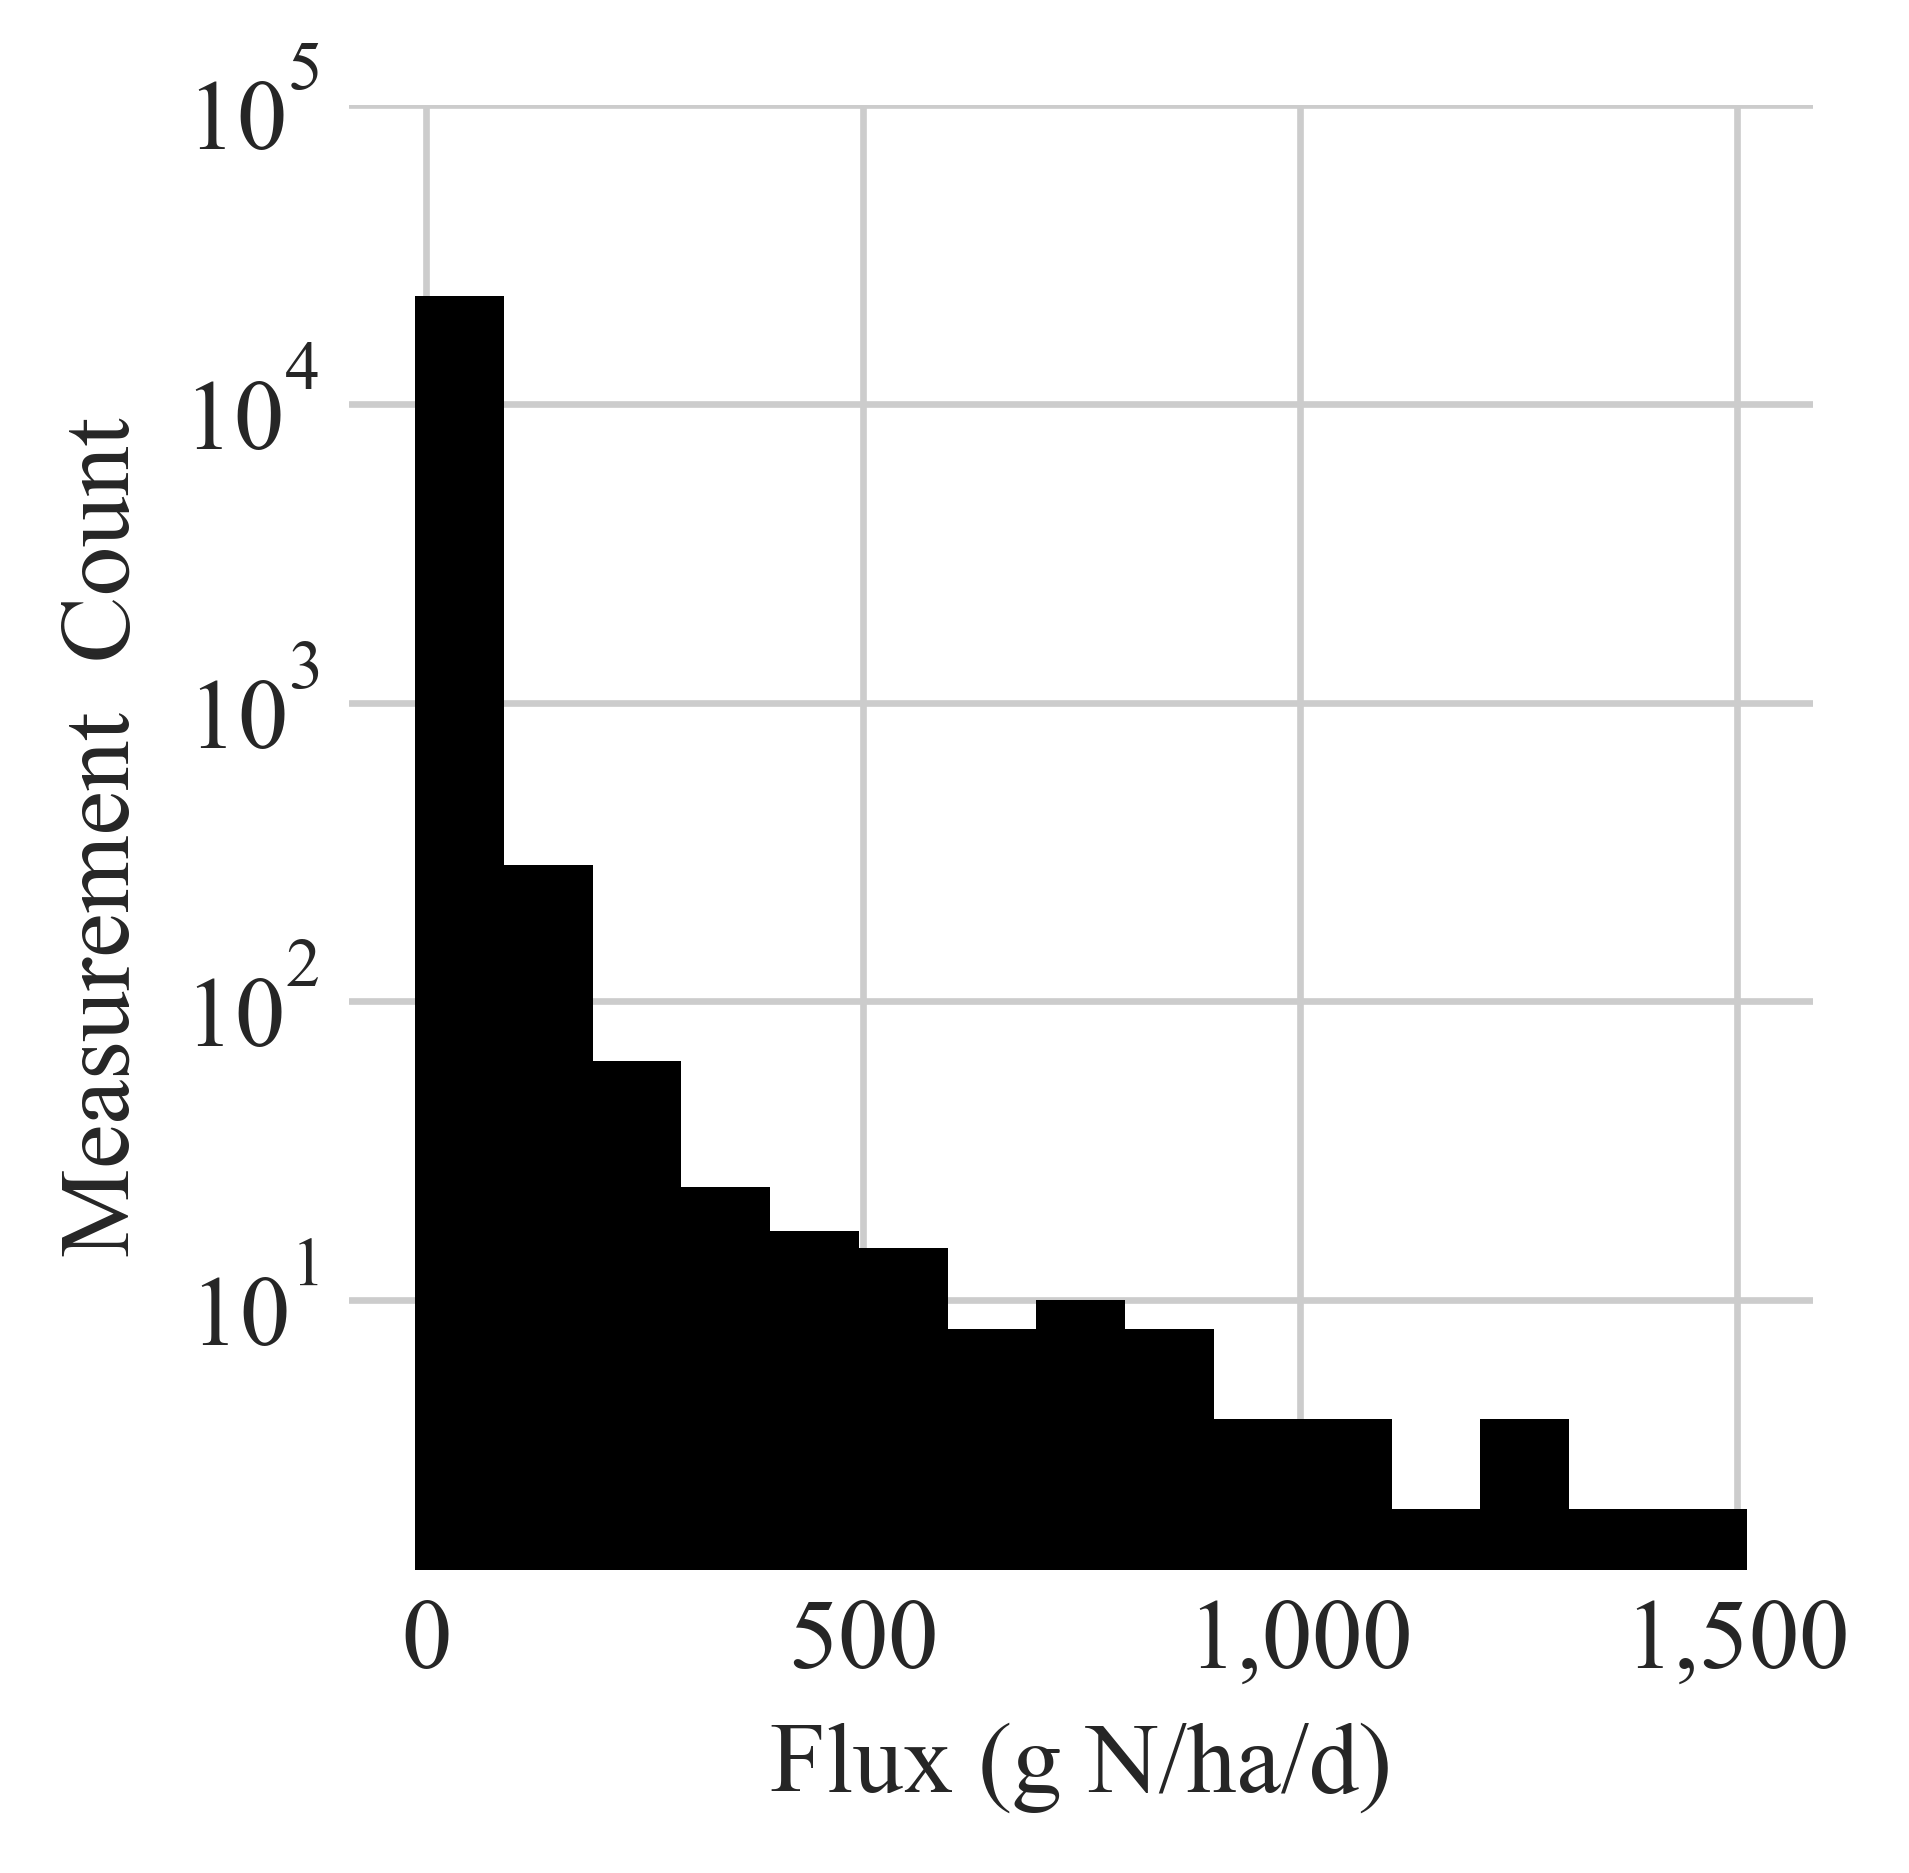

In [ ]:
# Figure 4
# Plot a histogram of the N2O flux values across all timeseries with 100 bins

# Load data
alldata = pd.read_csv('OD_accuracydf_testing.csv')
# Add the training dataset
alldata = pd.concat([alldata, pd.read_csv('OD_accuracydf_training.csv')], ignore_index=True)
rowdata = pd.read_csv('classification_data_ts.csv')

import matplotlib.ticker as mtick

plt.style.use('seaborn-whitegrid')
# Set fig size
fig = plt.figure(figsize=(3.15, 3.15), dpi=600)

# Get range of N2OFlux values
minflux = min([float(i) for i in rowdata['N2OFlux'].to_list()])
maxflux = max([float(i) for i in rowdata['N2OFlux'].to_list()])
fluxrange = maxflux - minflux
# Use bins of size 100
bins = fluxrange / 100
# round bins to nearest integer
bins = int(round(bins))
ax2 = rowdata['N2OFlux'].hist(log=True, bins=bins)
# Set white background
ax2.set_facecolor('white')
# Change axis label font size
ax2.tick_params(axis='both', which='major')
# Set x-axis tick labels to zero decimal places
ax2.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

# Set X and Y axis titles
ax2.set_xlabel('Flux (g N/ha/d)', fontsize=12, font=my_font)
ax2.set_ylabel('Measurement  Count', fontsize=12, font=my_font)
# Set tick label font size
ax2.tick_params(axis='both', which='major', labelsize=12)
# Set subplot title
ax2.set_ylim(top=100000)
ax2.set_yscale('log')

ax2.set_xticklabels(['{:.0}'.format(x) for x in  ax2.get_xticks()], fontsize=12, font=my_font)
ax2.set_yticklabels(['{:.0}'.format(x) for x in ax2.get_yticks()], fontsize=12, font=my_font)
ax2.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax2.set_yscale('log')


plt.subplots_adjust(top=0.9)

#Add padding between subplots
plt.subplots_adjust(wspace=0.3)

# Set label font size
fig.show()
# Save fig as png, use wider margins
plt.savefig('contamination_hist.svg', format='svg',bbox_inches='tight', )


/tmp/ipykernel_1418063/3377897030.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1418063/3377897030.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1418063/3377897030.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1418063/3377897030.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

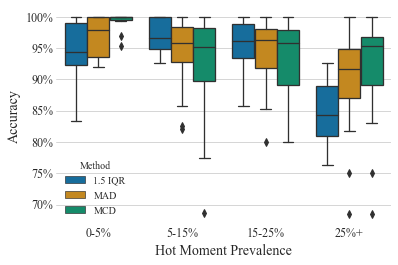

In [ ]:
# Figure 6
# Load the testing dataset
rowdata = pd.read_csv('OD_accuracydf_testing.csv')
import matplotlib.ticker as mtick


# Create a binned side by side box plot of the accuracy of IQR, MAD and MCD
# Bins based on contamination rate and set to 0%, 0-10%, 10-20%, 20-30%, 30+%

# Create a marker in rowdata for each bin
rowdata['Bin'] = None
for index, row in rowdata.iterrows():
    if row['Contamination'] < 0.05:
        rowdata.at[index, 'Bin'] = '0-5%'
    elif row['Contamination'] < 0.15:
        rowdata.at[index, 'Bin'] = '5-15%'
    elif row['Contamination'] < 0.25:
        rowdata.at[index, 'Bin'] = '15-25%'
    else:
        rowdata.at[index, 'Bin'] = '25%+'

# Create a df which includes a Method, Bin, and Accuracy column for IQR, MAD, and MCD
df = pd.DataFrame(columns=['Method', 'Bin', 'Accuracy'])
iqrdf = rowdata[['Bin', '1.5 IQRHM']]
maddf = rowdata[['Bin', 'MAD']]
mcd_df = rowdata[['Bin', 'MCD']]
# Rename columns to Accuracy
iqrdf.rename(columns={'1.5 IQRHM': 'Accuracy'}, inplace=True)
maddf.rename(columns={'MAD': 'Accuracy'}, inplace=True)
mcd_df.rename(columns={'MCD': 'Accuracy'}, inplace=True)
# Add method
iqrdf['Method'] = '1.5 IQR'
maddf['Method'] = 'MAD'
mcd_df['Method'] = 'MCD'
df = df.append(iqrdf, ignore_index=True)
df = df.append(maddf, ignore_index=True)
df = df.append(mcd_df, ignore_index=True)

# Order df by bin in order of 0, 0-10, 10-20, 20-30, 30+
order = ['0-5%', '5-15%', '15-25%', '25%+']
df['Bin'] = pd.Categorical(df['Bin'], categories=order, ordered=True)

# Plot the side-by-side box plot
ax = sns.boxplot(data=df, x='Bin', y='Accuracy', hue='Method', palette='colorblind')

# Set y axis tick labels
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])

# Set legend font
plt.rcParams['legend.fontsize'] = 12
plt.legend(title='Method', prop=my_font)

# Set legend font to my_font
for text in ax.get_legend().get_texts():
    text.set_fontproperties(my_font)
# Set legent title fonttttttttttttttttttttttttttttttttttttttt
legend = ax.get_legend()
plt.setp(legend.get_title(), fontproperties=my_font)


# Set font to Times New Roman
ax.set_facecolor('white')
ax.set_xlabel('Hot Moment Prevalence', fontsize=14, font=my_font)
ax.set_ylabel('Accuracy', fontsize=14, font=my_font)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, font=my_font)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, font=my_font)


# Show plot
plt.show()

# Save the seaborn fig as svg
ax.figure.savefig('Figure_6.svg', dpi=600, bbox_inches='tight')


In [ ]:
# Load the CSV file holding predictions for each OD method of each N2OFlux
rowdata = pd.read_csv('optimal_thresholds_predictions_df.csv')


# Create a column called LocalHM, = None
rowdata['LocalHM'] = None
# Convert N2OFlux to float
rowdata['N2OFlux'] = rowdata['N2OFlux'].astype(float)

# For each unique TreatmentID, check each row where HmTruth = 1. If there is another row where HMTruth = 0 and N2OFlux is greater, set LocalHM = 1
for TreatmentID in rowdata['TreatmentID'].unique():
    repdata = rowdata.query('TreatmentID == @TreatmentID')
    for index, row in repdata.iterrows():
        rowflux = row['N2OFlux']
        if row['HMTruth'] == 1:
            if len(repdata.query('HMTruth == 0 and N2OFlux > @rowflux')) > 0:
                rowdata.at[index, 'LocalHM'] = 1
            else:
                rowdata.at[index, 'LocalHM'] = 0

# For each of the OD methods, calculate the accuracy rate of detecting local hot moments
# HBOS
hbos_localhm = rowdata.query('HBOS_pred == 1 and LocalHM == 1')
hbos_localhm_accuracy = len(hbos_localhm.index) / len(rowdata.query('LocalHM == 1').index)

# MAD
mad_localhm = rowdata.query('MAD_pred == 1 and LocalHM == 1')
mad_localhm_accuracy = len(mad_localhm.index) / len(rowdata.query('LocalHM == 1').index)

# MCD
mcd_localhm = rowdata.query('MCD_pred == 1 and LocalHM == 1')
mcd_localhm_accuracy = len(mcd_localhm.index) / len(rowdata.query('LocalHM == 1').index)

# KNN
knn_localhm = rowdata.query('KNN_pred == 1 and LocalHM == 1')
knn_localhm_accuracy = len(knn_localhm.index) / len(rowdata.query('LocalHM == 1').index)

# 1.5 IQR
iqr15_localhm = rowdata.query('IQR1p5 == 1 and LocalHM == 1')
iqr15_localhm_accuracy = len(iqr15_localhm.index) / len(rowdata.query('LocalHM == 1').index)

# LOF
lof_localhm = rowdata.query('LOF_pred == 1 and LocalHM == 1')
lof_localhm_accuracy = len(lof_localhm.index) / len(rowdata.query('LocalHM == 1').index)

# IForest
iforest_localhm = rowdata.query('IForest_pred == 1 and LocalHM == 1')
iforest_localhm_accuracy = len(iforest_localhm.index) / len(rowdata.query('LocalHM == 1').index)

# ARIMA
arima_localhm = rowdata.query('ARIMA_pred == 1 and LocalHM == 1')
arima_localhm_accuracy = len(arima_localhm.index) / len(rowdata.query('LocalHM == 1').index)

# Moving Average
ma_localhm = rowdata.query('MA_pred == 1 and LocalHM == 1')
ma_localhm_accuracy = len(ma_localhm.index) / len(rowdata.query('LocalHM == 1').index)

# 75 Percentile
percentile75_localhm = rowdata.query('Percentile_75 == 1 and LocalHM == 1')
percentile75_localhm_accuracy = len(percentile75_localhm.index) / len(rowdata.query('LocalHM == 1').index)

# COPOD
copod_localhm = rowdata.query('COPOD_pred == 1 and LocalHM == 1')
copod_localhm_accuracy = len(copod_localhm.index) / len(rowdata.query('LocalHM == 1').index)

# 3 IQR
iqr3_localhm = rowdata.query('IQR3 == 1 and LocalHM == 1')
iqr3_localhm_accuracy = len(iqr3_localhm.index) / len(rowdata.query('LocalHM == 1').index)

# ABOD
abod_localhm = rowdata.query('ABOD_pred == 1 and LocalHM == 1')
abod_localhm_accuracy = len(abod_localhm.index) / len(rowdata.query('LocalHM == 1').index)

# 4SD
sd4_localhm = rowdata.query('SD4 == 1 and LocalHM == 1')
sd4_localhm_accuracy = len(sd4_localhm.index) / len(rowdata.query('LocalHM == 1').index)

# Print
print('HBOS Local HM Accuracy: ' + str(hbos_localhm_accuracy))
print('MAD Local HM Accuracy: ' + str(mad_localhm_accuracy))
print('MCD Local HM Accuracy: ' + str(mcd_localhm_accuracy))
print('KNN Local HM Accuracy: ' + str(knn_localhm_accuracy))
print('LOF Local HM Accuracy: ' + str(lof_localhm_accuracy))
print('IForest Local HM Accuracy: ' + str(iforest_localhm_accuracy))
print('1.5 IQR Local HM Accuracy: ' + str(iqr15_localhm_accuracy))
print('ARIMA Local HM Accuracy: ' + str(arima_localhm_accuracy))
print('Moving Average Local HM Accuracy: ' + str(ma_localhm_accuracy))
print('75th Percentile Local HM Accuracy: ' + str(percentile75_localhm_accuracy))
print('COPOD Local HM Accuracy: ' + str(copod_localhm_accuracy))
print('3 IQR Local HM Accuracy: ' + str(iqr3_localhm_accuracy))
print('ABOD Local HM Accuracy: ' + str(abod_localhm_accuracy))
print('4SD Local HM Accuracy: ' + str(sd4_localhm_accuracy))


/tmp/ipykernel_360007/2582541044.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.0f}'.format(x) for x in ax.get_xticks()], font=my_font)


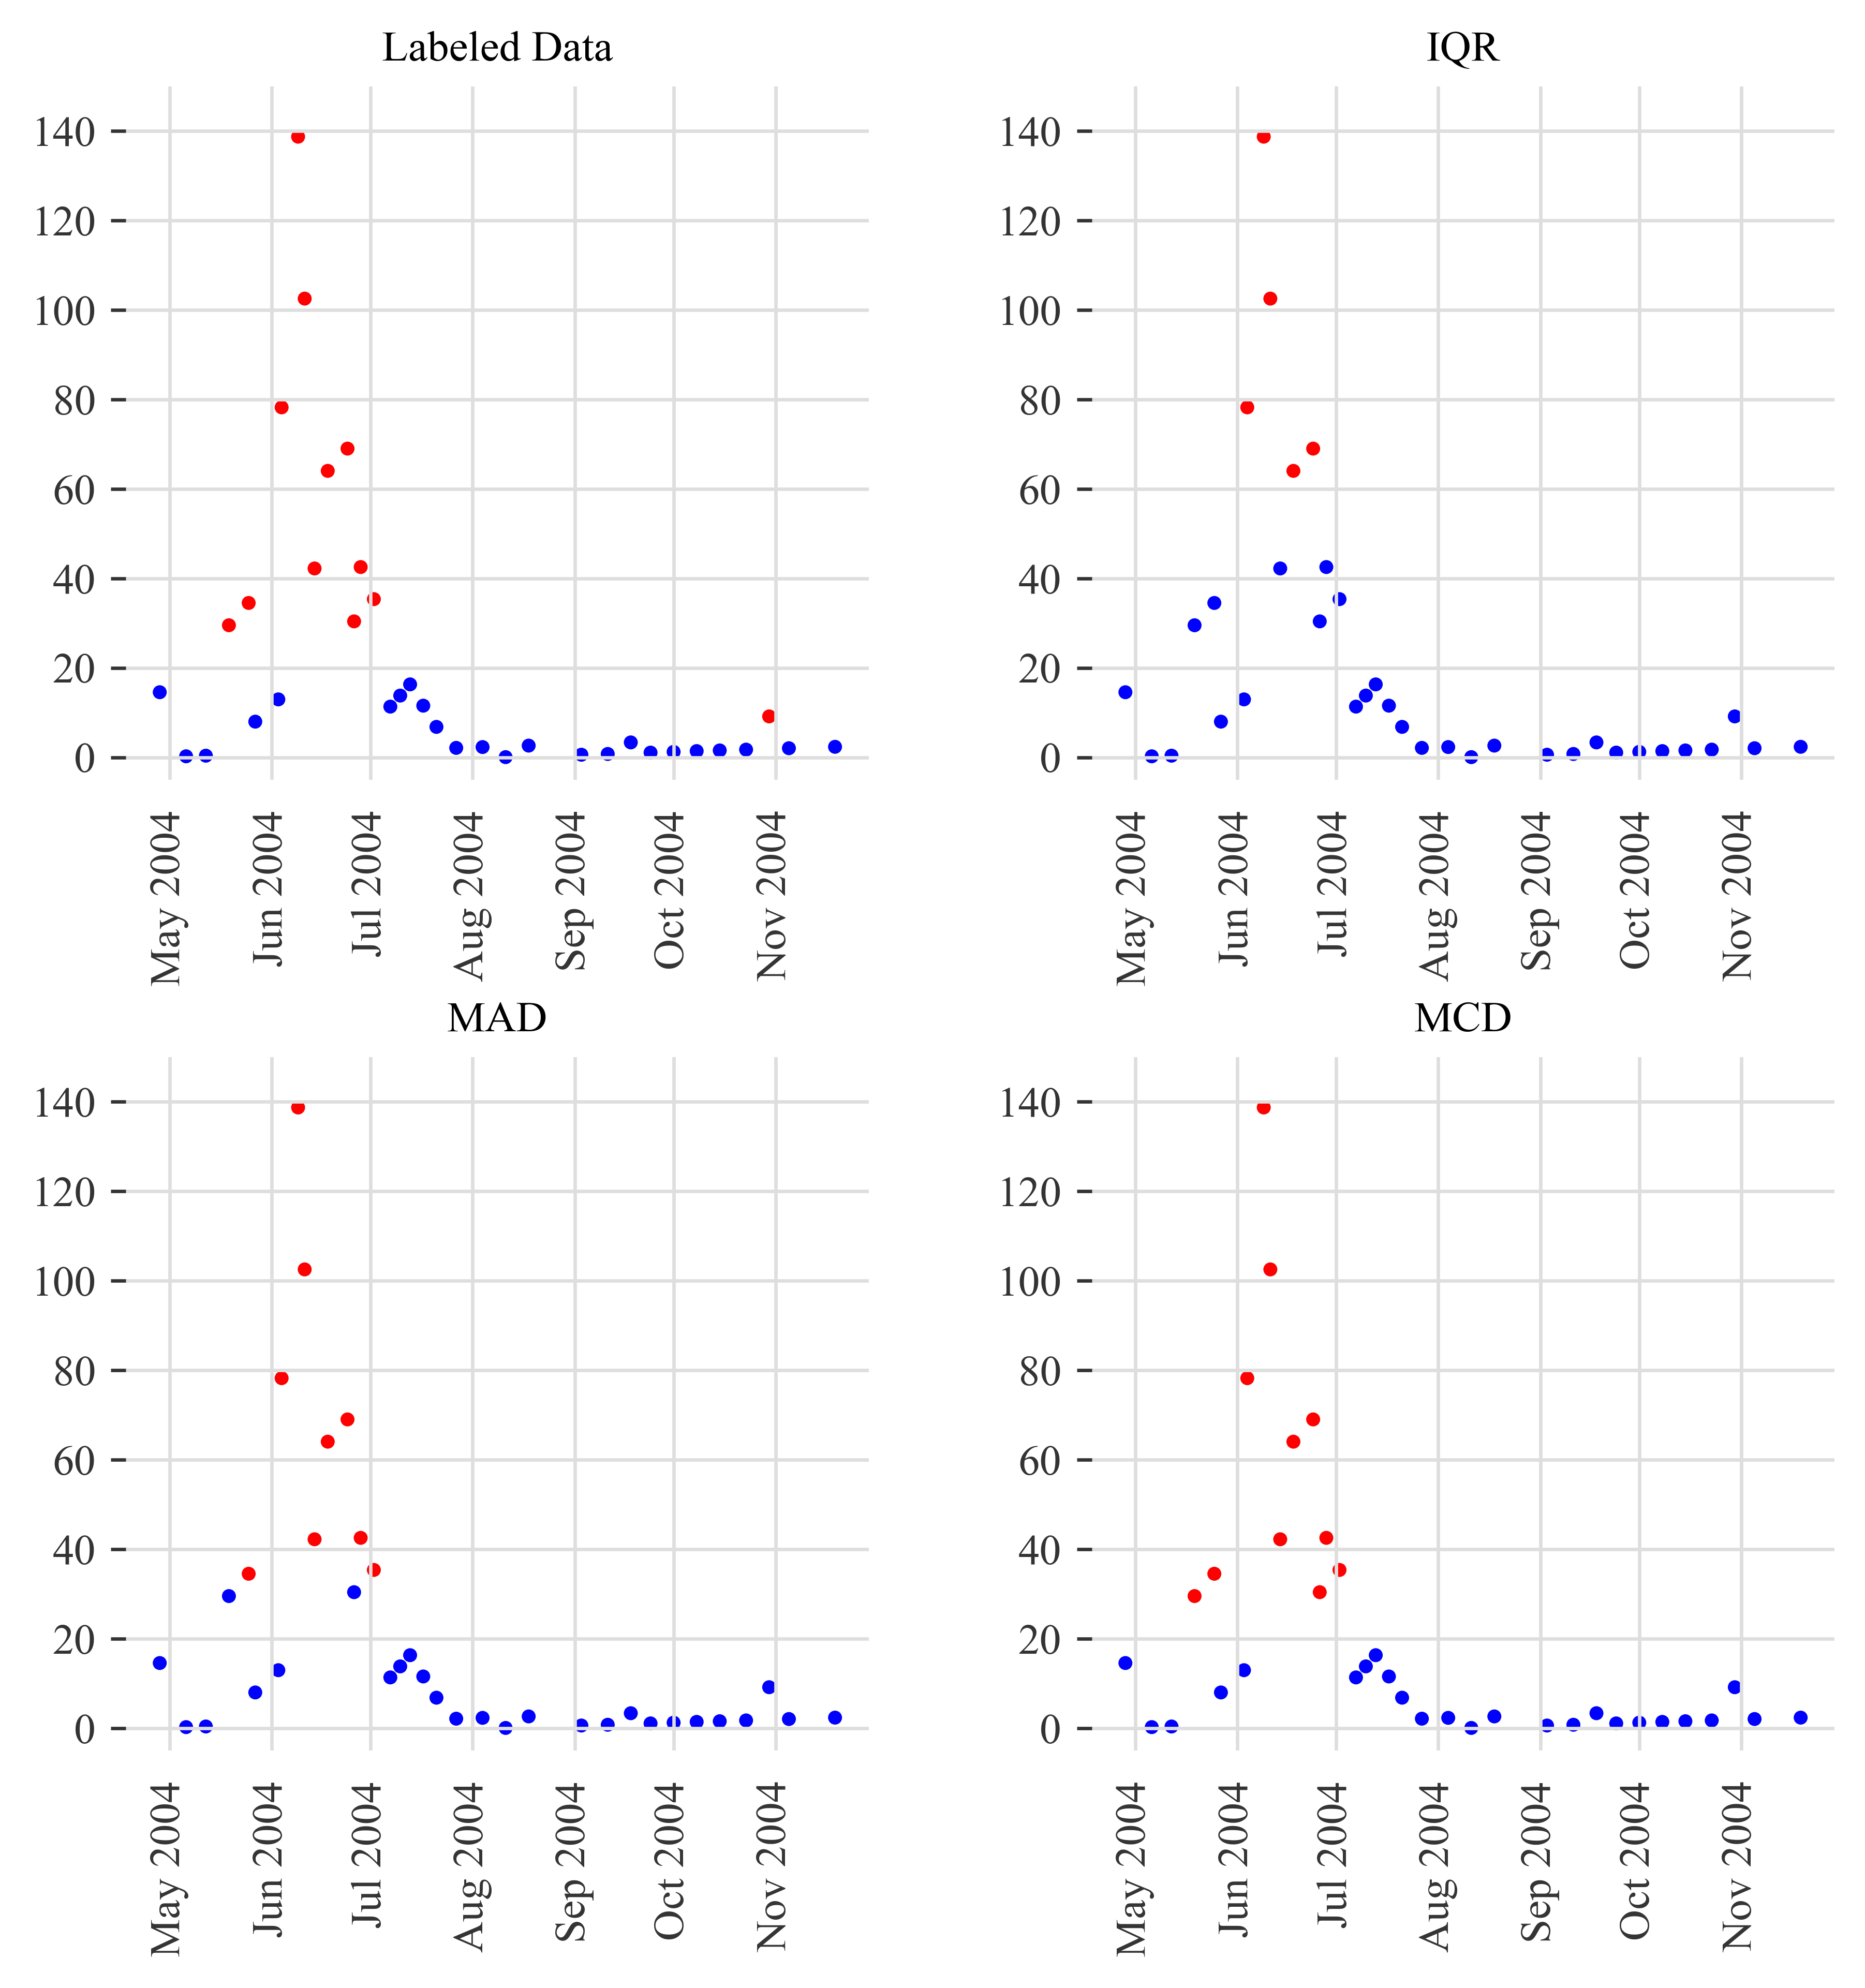

In [6]:
# Figure 8
# Load the CSV file holding predictions for each OD method of each N2OFlux
rowdata = pd.read_csv('optimal_thresholds_predictions_df.csv')

#test_treatment = 325
test_treatment = 18
rowdata = rowdata[rowdata['TreatmentID'] == test_treatment]
# Convert Date column to datetime
rowdata['Date'] = pd.to_datetime(rowdata['Date'], format='%Y-%m-%d')

# Create a 2 x 2 grid of subplots
fig, ax = plt.subplots(2, 2, figsize=(7.1, 7.1), dpi=600)
cmap_name = 'HM'
colors = ['blue', 'red']
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)
# Plot a scatterplot of the N2O Flux and the date on all subplots. Color the markers based on the prediction of IQR, MCD, MAD, and KNN

# Blank data
ax[0, 0].scatter(rowdata['Date'], rowdata['N2OFlux'], c=rowdata['HMTruth'], cmap=cmap, s=5)
ax[0, 0].set_title('Labeled Data', font=my_font)
# Set ylim
ax[0, 0].set_ylim(-5, 150)
# Set y axis ticks to
ax[0,0].set_yticks([0, 20, 40, 60, 80, 100, 120, 140], font=my_font)
ax[0,0].set_yticklabels([0, 20, 40, 60, 80, 100, 120, 140], font=my_font)
# Set x and y ticks to my_font
plt.xticks(font=my_font)
plt.yticks(font=my_font)

# IQR
ax[0, 1].scatter(rowdata['Date'], rowdata['N2OFlux'], c=rowdata['1.5iqr'], cmap=cmap, s=5)
ax[0, 1].set_title('IQR', font=my_font)
ax[0, 1].set_ylim(-5, 150)
ax[0,1].set_yticks([0, 20, 40, 60, 80, 100, 120, 140], font=my_font)
ax[0,1].set_yticklabels([0, 20, 40, 60, 80, 100, 120, 140], font=my_font)
# Set x and y ticks to my_font
plt.xticks(font=my_font)
plt.yticks(font=my_font)


# MAD
ax[1, 0].scatter(rowdata['Date'], rowdata['N2OFlux'], c=rowdata['MAD_pred'], cmap=cmap, s=5)
ax[1, 0].set_title('MAD', font=my_font)
ax[1, 0].set_ylim(-5, 150)
ax[1,0].set_yticks([0, 20, 40, 60, 80, 100, 120, 140], font=my_font)
ax[1,0].set_yticklabels([0, 20, 40, 60, 80, 100, 120, 140], font=my_font)
# Set x and y ticks to my_font
plt.xticks(font=my_font)
plt.yticks(font=my_font)

# MCD
ax[1, 1].scatter(rowdata['Date'], rowdata['N2OFlux'], c=rowdata['MCD_pred'], cmap=cmap, s=5)
ax[1, 1].set_title('MCD', font=my_font)
ax[1, 1].set_ylim(-5, 150)
ax[1,1].set_yticks([0, 20, 40, 60, 80, 100, 120, 140], font=my_font)
ax[1,1].set_yticklabels([0, 20, 40, 60, 80, 100, 120, 140], font=my_font)

# Set x and y ticks to my_font
plt.xticks(font=my_font)
plt.yticks(font=my_font)


# Import mdates
import matplotlib.dates as mdates

# Rotate x-axis tick labels
for ax in fig.get_axes():
    ax.tick_params(axis='x', rotation=90, labelsize=12)
    # Set font family
    # Use dateformatter to use the abbreviated month name
    ax.set_xticklabels(['{:,.0f}'.format(x) for x in ax.get_xticks()], font=my_font)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Increase the padding between subplots
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Set white background behind axis and between plots
fig.patch.set_facecolor('white')


# Show the plot
plt.show()

# Save figure
fig.savefig('method_predictions.tif', dpi=600, bbox_inches='tight')

In [ ]:
# Read csv file
alldata = pd.read_csv('HotMomentTreatments.csv')

long_treatments = []
duration = []
measurements = []
longest_gap = []
# Find the TreatmentID of all treatments which collect N2OFlux data across a time period of at least one year
for TreatmentID in alldata['TreatmentID'].unique():
    treatmentdata = alldata.query('TreatmentID == ' + str(TreatmentID))
    treatmentdata = treatmentdata.dropna(subset=['N2OFlux'])
    first_date = treatmentdata['Date'].min()
    last_date = treatmentdata['Date'].max()
    if (last_date - first_date).days >= 365:
        long_treatments.append(TreatmentID)
        duration.append((last_date - first_date).days)
        measurements.append(len(treatmentdata))
        # Find the longest gap in time between N2OFlux measurements
        gap = treatmentdata['Date'].diff()
        longest_gap.append(gap.max())

long_experiments_df = pd.DataFrame({'TreatmentID': long_treatments, 'Duration': duration, 'Measurements': measurements, 'Longest Gap': longest_gap})
# Sort by longest gap ascending
long_experiments_df = long_experiments_df.sort_values(by=['Longest Gap'])

# Convert Longest Gap column from timedelta to int
long_experiments_df['Longest Gap'] = long_experiments_df['Longest Gap'].dt.days

# Drop rows where Longest Gap > 14
long_experiments_df = long_experiments_df.drop(long_experiments_df[long_experiments_df['Longest Gap'] > 20].index)

long_experiments_df.to_csv('LongExperiments.csv')


/tmp/ipykernel_1418063/4134261722.py:33: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_1418063/4134261722.py:39: UserWarning:

FixedFormatter should only be used together with FixedLocator

2025-08-09 16:18:38 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_1418063/4134261722.py:50: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_1418063/4134261722.py:54: UserWarning:

FixedFormatter should only be used together with FixedLocator

2025-08-09 16:18:38 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-08-09 16:18:38 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose l

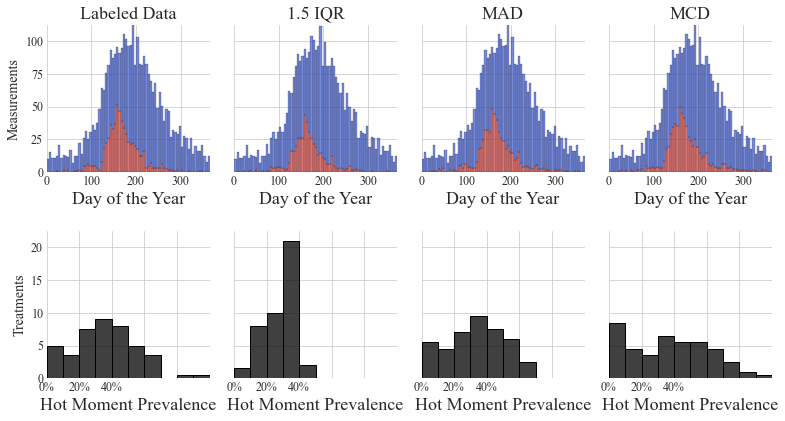

In [ ]:
# Figure 7
# Load the testing predictions
rowdata = pd.read_csv('optimal_thresholds_predictions_df.csv')
# Add training data
#rowdata.append(pd.read_csv('optimal_thresholds_predictions_training.csv'))

column_order = ['HMTruth', 'IQR1p5', 'MAD_pred', 'MCD_pred']

# Create 2 rows and 4 columns of subplots
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(13, 6.5))

# Create the top left subplot
sns.histplot(rowdata, x='DOY', hue='HMTruth', ax=ax[0, 0], kde=False, palette=['#4965d1', '#d14949'], binwidth=5, multiple='stack')
sns.histplot(rowdata, x='DOY', hue='IQR1p5', ax=ax[0, 1], kde=False, palette=['#4965d1', '#d14949'],binwidth=5, multiple='stack')
sns.histplot(rowdata, x='DOY', hue='MAD_pred', ax=ax[0, 2], kde=False, palette=['#4965d1', '#d14949'],  binwidth=5, multiple='stack')
sns.histplot(rowdata, x='DOY', hue='MCD_pred', ax=ax[0, 3], kde=False, palette=['#4965d1', '#d14949'], binwidth=5, multiple='stack')

# For the second row, plot a histogram of the actual/predicted contamination rates
rowdata = pd.read_csv('OD_accuracydf_testing.csv')

sns.histplot(rowdata, x='Contamination', ax=ax[1, 0], binwidth=0.05)
sns.histplot(rowdata, x='IQRContamination', ax=ax[1, 1], binwidth=0.05)
sns.histplot(rowdata, x='MADContamination', ax=ax[1, 2], binwidth=0.05)
sns.histplot(rowdata, x='MCDContamination', ax=ax[1, 3], binwidth=0.05)

# Set max x lim for all bottom row subplots
for i in range(4):
    ax[1, i].set_xlim(0, 0.5)
    ax[1,i].set_ylim(0, 45)
    # Make x labels percentage
    #ax[1, i].set_xticklabels(['{:,.0%}'.format(x/2) for x in ax[1, i].get_xticks()],  fontsize=12, font=my_font)
    # Set y tick label font
    if i == 0:
        ax[1, i].set_yticklabels(['{:,.0f}'.format(x) for x in ax[1, i].get_yticks()], fontsize=12, font=my_font)
    else:
        # Remove tick labels
        ax[1, i].set_yticklabels([])
    # Remove y title
    ax[1, i].set_ylabel('')
    ax[1, i].set_xticklabels(['0%', '20%', '40%', ], fontsize=12, font=my_font)

# Set max y lim for all top row subplots
for i in range(4):
    ax[0, i].set_ylim(0, 225)
    ax[0, i].set_xlim(0, 365)
    # Remove legend
    ax[0, i].legend().remove()
    # Remove y title
    ax[0, i].set_ylabel('')
    if i == 0:
        ax[0, i].set_yticklabels(['{:,.0f}'.format(x) for x in ax[0, i].get_yticks()], fontsize=12, font=my_font)
    else:
        # Remove tick labels
        ax[0, i].set_yticklabels([])
    ax[0, i].set_xticklabels(['{:,.0f}'.format(x) for x in ax[0, i].get_xticks()], fontsize=12, font=my_font)


# Set font to Times New Roman
ax[0, 0].set_facecolor('white')
ax[0, 1].set_facecolor('white')
ax[0, 2].set_facecolor('white')
ax[0, 3].set_facecolor('white')
ax[1, 0].set_facecolor('white')
ax[1, 1].set_facecolor('white')
ax[1, 2].set_facecolor('white')
ax[1, 3].set_facecolor('white')

ax[0, 0].set_xlabel('Day of the Year', fontsize=18, font=my_font)
ax[0, 1].set_xlabel('Day of the Year', fontsize=18, font=my_font)
ax[0, 2].set_xlabel('Day of the Year', fontsize=18, font=my_font)
ax[0, 3].set_xlabel('Day of the Year', fontsize=18, font=my_font)
ax[1, 0].set_xlabel('Hot Moment Prevalence', fontsize=18, font=my_font)
ax[1, 1].set_xlabel('Hot Moment Prevalence', fontsize=18, font=my_font)
ax[1, 2].set_xlabel('Hot Moment Prevalence', fontsize=18, font=my_font)
ax[1, 3].set_xlabel('Hot Moment Prevalence', fontsize=18, font=my_font)

ax[0, 0].set_ylabel('Measurements', fontsize=14, font=my_font)
ax[1, 0].set_ylabel('Treatments', fontsize=14, font=my_font)

ax[0, 0].set_title('Labeled Data', loc='center', fontsize=18, font=my_font)
ax[0, 1].set_title('1.5 IQR', loc='center', fontsize=18, font=my_font)
ax[0, 2].set_title('MAD', loc='center', fontsize=18, font=my_font)
ax[0, 3].set_title('MCD', loc='center', fontsize=18, font=my_font)

# Add spacing between the top and bottom subplots
plt.subplots_adjust(hspace=0.4)
# Reduce spacing between the left and right subplots
plt.subplots_adjust(wspace=0.15)

# Save plot
plt.savefig('Figure_7.svg', dpi=600, bbox_inches='tight')



In [ ]:
# Table 4: Get the time and cumulative flux proportion of hot moments using year-round experiment datasets

# # Load the predictions dataset
rowdata = pd.read_csv('optimal_thresholds_predictions_df.csv')
rowdata2 = pd.read_csv('optimal_thresholds_predictions_training.csv')
# combine test and training data
rowdata = pd.concat([rowdata, rowdata2], ignore_index=True)
# Load long term experiments
long_experiments_df = pd.read_csv('LongExperiments.csv')

# Drop all rows where the TreatmentID is not in long_experiments_df
rowdata = rowdata[rowdata['TreatmentID'].isin(long_experiments_df['TreatmentID'])]

HMTruth = rowdata.query('HMTruth > 0')
mcdhm = rowdata.query('MCD_pred > 0')
percentilehm = rowdata.query('Percentile_75 > 0')
BGTruth = rowdata.query('HMTruth == 0')
mcdbg = rowdata.query('MCD_pred == 0')
madhm = rowdata.query('MAD_pred > 0')
madbg = rowdata.query('MAD_pred == 0')
iqrhm = rowdata.query('IQR1p5 > 0')
iqrbg = rowdata.query('IQR1p5 == 0')

hm_time_proportion = len(HMTruth.index) / len(rowdata.index)
print('True HM time proportion: ' + str(hm_time_proportion))
hm_flux_proportion = sum(list(HMTruth.N2OFlux)) / sum(list(rowdata.N2OFlux))
print('True HM flux proportion: ' + str(hm_flux_proportion))

hm_time_proportion = len(mcdhm.index) / len(rowdata.index)
print('MCD HM time proportion: ' + str(hm_time_proportion))
hm_flux_proportion = sum(list(mcdhm.N2OFlux)) / sum(list(rowdata.N2OFlux))
print('MCD HM flux proportion: ' + str(hm_flux_proportion))

hm_time_proportion = len(madhm.index) / len(rowdata.index)
print('MAD HM time proportion: ' + str(hm_time_proportion))
hm_flux_proportion = sum(list(madhm.N2OFlux)) / sum(list(rowdata.N2OFlux))
print('MAD HM flux proportion: ' + str(hm_flux_proportion))

hm_time_proportion = len(iqrhm.index) / len(rowdata.index)
print('IQR HM time proportion: ' + str(hm_time_proportion))
hm_flux_proportion = sum(list(iqrhm.N2OFlux)) / sum(list(rowdata.N2OFlux))
print('IQR HM flux proportion: ' + str(hm_flux_proportion))


print("Total datasett count: " + str(len(rowdata['TreatmentID'].unique())))
print("Total datasett days: " + str(len(rowdata.index)))

In [7]:
# Table 3, 4: Get the mean and median flux of hot moments, as well as the 95% confidence interval
# Also, get the time and flux proportion of hot moments from the entire dataset

# # Load the predictions dataset
rowdata = pd.read_csv('optimal_thresholds_predictions_df.csv')

HMTruth = rowdata.query('HMTruth > 0')
mcdhm = rowdata.query('MCD_pred > 0')
percentilehm = rowdata.query('Percentile_75 > 0')
BGTruth = rowdata.query('HMTruth == 0')
mcdbg = rowdata.query('MCD_pred == 0')
madhm = rowdata.query('MAD_pred > 0')
madbg = rowdata.query('MAD_pred == 0')
iqrhm = rowdata.query('IQR1p5 > 0')
iqrbg = rowdata.query('IQR1p5 == 0')

hm_time_proportion = len(HMTruth.index) / len(rowdata.index)
print('True HM time proportion: ' + str(hm_time_proportion))
hm_flux_proportion = sum(list(HMTruth.N2OFlux)) / sum(list(rowdata.N2OFlux))
print('True HM flux proportion: ' + str(hm_flux_proportion))

hm_time_proportion = len(mcdhm.index) / len(rowdata.index)
print('MCD HM time proportion: ' + str(hm_time_proportion))
hm_flux_proportion = sum(list(mcdhm.N2OFlux)) / sum(list(rowdata.N2OFlux))
print('MCD HM flux proportion: ' + str(hm_flux_proportion))

hm_time_proportion = len(madhm.index) / len(rowdata.index)
print('MAD HM time proportion: ' + str(hm_time_proportion))
hm_flux_proportion = sum(list(madhm.N2OFlux)) / sum(list(rowdata.N2OFlux))
print('MAD HM flux proportion: ' + str(hm_flux_proportion))

hm_time_proportion = len(iqrhm.index) / len(rowdata.index)
print('IQR HM time proportion: ' + str(hm_time_proportion))
hm_flux_proportion = sum(list(iqrhm.N2OFlux)) / sum(list(rowdata.N2OFlux))
print('IQR HM flux proportion: ' + str(hm_flux_proportion))

print("Total datasett count: " + str(len(rowdata['TreatmentID'].unique())))
print("Total datasett days: " + str(len(rowdata.index)))

print("")
true_mean_bg = BGTruth['N2OFlux'].mean()
# Calculate 95% confidence interval of the mean
import scipy.stats as st
# Round to 3 decimal places
bg_mean_confidence_interval = st.t.interval(0.98, len(BGTruth['N2OFlux'])-1, loc=true_mean_bg,
                                            scale=st.sem(BGTruth['N2OFlux']))
true_median_bg = BGTruth['N2OFlux'].median()
print(bg_mean_confidence_interval)
print('True Background Mean = ' + str(true_mean_bg) + ' +- ' + str(bg_mean_confidence_interval[1] - true_mean_bg))
print('True Background Median = ' + str(true_median_bg))

mcd_mean_bg = mcdbg['N2OFlux'].mean()
# Calculate 95% confidence interval of the mean
mcdbg_mean_confidence_interval = st.t.interval(0.98, len(mcdbg['N2OFlux'])-1, loc=mcd_mean_bg,
                                                scale=st.sem(mcdbg['N2OFlux']))
mcd_median_bg = mcdbg['N2OFlux'].median()
print('MCD Background Mean = ' + str(mcd_mean_bg) + ' +- ' + str(mcdbg_mean_confidence_interval[1] -
                                                                   mcd_mean_bg))
print('MCD Background Median = ' + str(mcd_median_bg))

mad_mean_bg = madbg['N2OFlux'].mean()
# Calculate 95% confidence interval of the mean
madbg_mean_confidence_interval = st.t.interval(0.98, len(madbg['N2OFlux'])-1, loc=mad_mean_bg,
                                                scale=st.sem(madbg['N2OFlux']))
mad_median_bg = madbg['N2OFlux'].median()
print('MAD Background Mean = ' + str(mad_mean_bg) + ' +- ' + str(madbg_mean_confidence_interval[1] -
                                                                   mad_mean_bg))
print('MAD Background Median = ' + str(mad_median_bg))

iqr_mean_bg = iqrbg['N2OFlux'].mean()
# Calculate 95% confidence interval of the mean
iqrbg_mean_confidence_interval = st.t.interval(0.98, len(iqrbg['N2OFlux'])-1, loc=iqr_mean_bg,
                                                scale=st.sem(iqrbg['N2OFlux']))
iqr_median_bg = iqrbg['N2OFlux'].median()
print('IQR Background Mean = ' + str(iqr_mean_bg) + ' +- ' + str(iqrbg_mean_confidence_interval[1] -
                                                                   iqr_mean_bg))
print('IQR Background Median = ' + str(iqr_median_bg))

print("")
true_mean_hm = HMTruth['N2OFlux'].mean()
# Calculate 95% confidence interval of the mean
hm_mean_confidence_interval = st.t.interval(0.98, len(HMTruth['N2OFlux'])-1, loc=true_mean_hm,
                                            scale=st.sem(HMTruth['N2OFlux']))
true_median_hm = HMTruth['N2OFlux'].median()
print('True HM Mean = ' + str(true_mean_hm) + ' +- ' + str(hm_mean_confidence_interval[1] - true_mean_hm))
print('True HM Median = ' + str(true_median_hm))

mcd_mean_hm = mcdhm['N2OFlux'].mean()
# Calculate 95% confidence interval of the mean
mcdhm_mean_confidence_interval = st.t.interval(0.98, len(mcdhm['N2OFlux'])-1, loc=mcd_mean_hm,
                                                scale=st.sem(mcdhm['N2OFlux']))
mcd_median_hm = mcdhm['N2OFlux'].median()
print('MCD HM Mean = ' + str(mcd_mean_hm) + ' +- ' + str(mcdhm_mean_confidence_interval[1] - mcd_mean_hm))
print('MCD HM Median = ' + str(mcd_median_hm))

mad_mean_hm = madhm['N2OFlux'].mean()
# Calculate 95% confidence interval of the mean
madhm_mean_confidence_interval = st.t.interval(0.98, len(madhm['N2OFlux'])-1, loc=mad_mean_hm,
                                                scale=st.sem(madhm['N2OFlux']))
mad_median_hm = madhm['N2OFlux'].median()
print('MAD HM Mean = ' + str(mad_mean_hm) + ' +- ' + str(madhm_mean_confidence_interval[1] - mad_mean_hm))
print('MAD HM Median = ' + str(mad_median_hm))

iqr_mean_hm = iqrhm['N2OFlux'].mean()
# Calculate 95% confidence interval of the mean
iqrhm_mean_confidence_interval = st.t.interval(0.98, len(iqrhm['N2OFlux'])-1, loc=iqr_mean_hm,
                                                scale=st.sem(iqrhm['N2OFlux']))
iqr_median_hm = iqrhm['N2OFlux'].median()
print('IQR HM Mean = ' + str(iqr_mean_hm) + ' +- ' + str(iqrhm_mean_confidence_interval[1] - iqr_mean_hm))
print('IQR HM Median = ' + str(iqr_median_hm))

True HM time proportion: 0.18904646952323476
True HM flux proportion: 0.7678447528270347
MCD HM time proportion: 0.1928183464091732
MCD HM flux proportion: 0.7541380954690681
MAD HM time proportion: 0.17908871454435726
MAD HM flux proportion: 0.7369415635939801
IQR HM time proportion: 0.14257694628847314
IQR HM flux proportion: 0.6962217473628605
Total datasett count: 85
Total datasett days: 6628

(4.075065204532399, 4.477080850807135)
True Background Mean = 4.276073027669767 +- 0.20100782313736776
True Background Median = 2.19733
MCD Background Mean = 4.549697660509346 +- 0.24892280415939272
MCD Background Median = 2.1746800000000004
MAD Background Mean = 4.7865057680068 +- 0.2693890102934722
MAD Background Median = 2.26845
IQR Background Mean = 5.280256654693969 +- 0.27243321618756955
IQR Background Median = 2.52324

True HM Mean = 60.669082609736634 +- 8.362939458069178
True HM Median = 24.741
MCD HM Mean = 58.42047773865414 +- 8.224543751021088
MCD HM Median = 21.21985
MAD HM Mean 